# Data Scrapping

**Objective:**  
    - To automate the scraping of dishes and ingredients from restaurant websites or third-party platforms with minimal manual intervention.

**Thought Process:**  
    - I plan to begin the data scraping process by compiling a comprehensive list of restaurants located in the Sydney CBD 2000 region. Using the names of these establishments, I will leverage SerpAPI to obtain their corresponding websites. Subsequently, I will extract the dishes and their ingredients directly from these websites. This entire workflow is designed to be fully automated, minimizing the need for manual input.

# Code Flow
- To gather the names of restaurants, cafes, and pubs in Sydney CBD 2000, I initially considered using popular websites such as Timeout, TripAdvisor, and OpenTable. However, a significant limitation I encountered was that these platforms typically feature only the top-rated establishments. For example, they often present lists like "10 Best Restaurants in Central Business District" or "35 Best Restaurants in Sydney CBD 2000."


- To address this issue, I attempted to extract data directly from Google search results, which provided a more comprehensive list of all restaurants in the Sydney CBD 2000 area. Unfortunately, this approach was short-lived due to recurring errors with the ChromeDriver, leading me to revert back to the initial method of sourcing information from curated lists.


- After compiling a list of 200 restaurants and successfully retrieving their official websites using the SerpAPI: Google Search API, I now have a comprehensive CSV file containing both the restaurant names and their respective websites. The next step is to extract the dishes offered by these restaurants, along with their corresponding ingredients.

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv

API_KEY = '27f4290fb90ed6306e7f696ac90b83ad6be414615761680819fe0e40a02d3e02'

def get_restaurant_names():
    url = "https://www.timeout.com/sydney/restaurants/the-best-restaurants-in-sydney"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        restaurant_elements = soup.find_all(['h2', 'h3'])
        restaurant_names = [restaurant.get_text(strip=True) for restaurant in restaurant_elements]
        return restaurant_names
    else:
        print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
        return []

def get_website(restaurant_name):
    params = {
        "q": restaurant_name,
        "location": "Sydney",
        "google_domain": "google.com.au",
        "hl": "en",
        "gl": "au",
        "api_key": API_KEY
    }
    response = requests.get("https://serpapi.com/search.json", params=params)
    if response.status_code == 200:
        results = response.json()
        if 'organic_results' in results and results['organic_results']:
            website = results['organic_results'][0].get('link')
            return website
        else:
            return "No website found"
    else:
        print(f"Failed to fetch results for {restaurant_name}, status code: {response.status_code}")
        return "Failed to retrieve website"

def scrape_menu(website_url):
    try:
        response = requests.get(website_url, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            menu_div = soup.find('div', class_='menu')
            menu_items = []
            if menu_div:
                pdf_link = menu_div.find('a')
                if pdf_link and 'href' in pdf_link.attrs:
                    pdf_url = pdf_link['href']
                    if not pdf_url.startswith('http'):
                        pdf_url = f"{website_url}/{pdf_url}"
                    menu_items.append(pdf_url)
            possible_menu = soup.find_all(string=lambda text: "menu" in text.lower())
            if possible_menu:
                menu_items.extend([menu.get_text(strip=True) for menu in possible_menu])
            return " | ".join(menu_items) if menu_items else "Menu not found"
        else:
            return "Failed to retrieve menu"
    except Exception as e:
        print(f"Error retrieving menu from {website_url}: {str(e)}")
        return "Error"

def save_restaurants_with_menu_to_csv():
    restaurant_names = get_restaurant_names()
    with open('restaurants_with_websites_and_menus.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Restaurant Name', 'Website', 'Menu'])
        for name in restaurant_names:
            website = get_website(name)
            print(f"Restaurant: {name}, Website: {website}")
            if "http" in website:
                menu = scrape_menu(website)
            else:
                menu = "Website not found"
            writer.writerow([name, website, menu])

save_restaurants_with_menu_to_csv()


- The above method gave me ony 200 restraunts name which i think is not enoungh so i tried using llama model to egt the list of restraunts, dish they have in there menu and the ingredients.

#Llama Extraction code


# Preprocessing Data

- Load the CSV file (data_updated.csv) with the appropriate encoding (ISO-8859-1) to handle special characters.
- Define and apply a function to remove leading numbers and periods (e.g., "1. Restaurant Name") from the Restraunts column using a regular expression.
- Handle missing or non-string values in the dishes and ingridients columns by
  - Filling any NaN (missing) values with empty strings.
  - Converting all values in these columns to strings to ensure consistent data types.
- Group the data by the Restraunts column and merge the dishes and ingridients columns by concatenating unique values for each restaurant.



In [ ]:
import pandas as pd
import re

df = pd.read_csv('data_updated.csv', encoding='ISO-8859-1')
def clean_restaurant_name(name):
    return re.sub(r'^\d+\.\s*', '', name)
df['Restraunts'] = df['Restraunts'].apply(clean_restaurant_name)
df['Dishes'] = df['Dishes'].fillna('').astype(str)
df['Ingridients'] = df['Ingridients'].fillna('').astype(str)
df_merged = df.groupby('Restraunts').agg({
    'Dishes': lambda x: ', '.join(x.unique()),   # Merge unique dishes into a single string
    'Ingridients': lambda x: ', '.join(x.unique()) # Merge unique ingredients into a single string
}).reset_index()
df_merged.to_csv('data_updated_merged.csv', index=False)
print("Merging completed and saved to 'data_updated_merged.csv'.")

# Handling Aliases
 - There are three ways to solve this aliases problem.
   - The manual way
   - Using fuzzy matching with certain threshold to solve this.
   - Clustering Similar Ingredients Using Embeddings
     - Kmeans
     - Kmeans with elbow method
     - DBSCAN

**Fuzzy Matching Overview**
- Motivation
    * Ingredient Variability: Ingredients can have multiple names (e.g., "aubergine" vs. "eggplant"), leading to inconsistencies in datasets.
Improved Data Quality: By recognizing and consolidating similar ingredients, fuzzy matching enhances data accuracy and user experience.

**How It Works**
* String Similarity: Fuzzy matching algorithms evaluate the similarity between strings based on metrics such as Levenshtein distance, which measures the number of edits required to transform one string into another.
* Threshold Setting: Matches are filtered based on a predefined similarity threshold. If the similarity score exceeds this threshold, the strings are considered equivalent, and aliases can be appended to the original ingredient.

In [ ]:
import pandas as pd

df = pd.read_csv("data_updated_merged.csv")
df['Ingridients'] = df['Ingridients'].fillna('').astype(str)
all_ingredients = set()
df['Ingridients'].str.split(', ').apply(all_ingredients.update)

all_ingredients = list(all_ingredients)


In [ ]:
print(all_ingredients)

['', 'Various international dishes', 'Broth', 'Eggs', 'Cornmeal', 'grilled tomatoes', 'Beans', 'Sushi rice', 'marron', 'Caesar dressing', 'Arborio Rice', 'gin', 'Kimchi', 'prawn', 'ramen noodles', 'Bacon', 'lime leaves', 'Vegetables,', 'cream', 'pancakes', 'mussels', 'matcha', 'onions', 'Duck', 'Butter', 'Spaghetti', 'Potatoes', 'variety of wines', 'Barramundi', 'variety of fish', 'crackers', 'Scallops', 'variety of fillings', 'crab', 'Noodle dishes', 'Parsley', 'Fettuccine', 'Tofu', 'Sake', 'octopus', 'Corn', 'premium meats', 'baking soda', 'stir-fry ingredients (meat', 'Couscous', 'Tapas items (meat', 'desserts', 'aioli', 'Pork', 'avocado', 'variety of vegetables', 'Cream', 'burgers', 'pickled ginger', 'Croutons', 'Tomatoes', 'chicken', 'flour', 'snapper', 'basmati rice', 'ham', 'butter', 'Meats', 'almond flour', 'Raw Fish', 'small bites', 'Rib eye beef', 'romaine lettuce', 'seasoning', 'Cheese', 'coffee beans', 'artichoke', 'Olive Oil', 'mushrooms', 'prawns', 'Broccoli', 'Lamb Shank

In [ ]:
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def find_similar_ingredients(ingredient_list, threshold=85):
    similar_ingredients = {}

    for i, ingredient in enumerate(ingredient_list):
        matches = process.extract(ingredient, ingredient_list, limit=len(ingredient_list))

        matches = [match for match in matches if match[1] > threshold and match[0] != ingredient]

        if matches:
            similar_ingredients[ingredient] = matches[0][0]

    return similar_ingredients

similar_ingredient_mapping = find_similar_ingredients(all_ingredients, threshold=85)
print(similar_ingredient_mapping)

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


{'Various international dishes': 'Noodle dishes', 'Broth': 'broth', 'Eggs': 'eggs', 'Cornmeal': 'Corn', 'grilled tomatoes': 'Tomatoes', 'Beans': 'coffee beans', 'Sushi rice': 'sushi rice', 'Arborio Rice': 'arborio rice', 'gin': 'pickled ginger', 'prawn': 'prawns', 'ramen noodles': 'noodles', 'Bacon': 'bacon', 'lime leaves': 'Lime', 'Vegetables,': 'vegetables)', 'cream': 'Cream', 'pancakes': 'Pancakes', 'onions': 'Onions', 'Duck': 'duck', 'Butter': 'butter', 'Potatoes': 'potatoes', 'variety of wines': 'variety', 'Barramundi': 'barramundi fish', 'variety of fish': 'Fish', 'Scallops': 'scallops', 'variety of fillings': 'fillings', 'crab': 'Crab', 'Noodle dishes': 'Various international dishes', 'Parsley': 'parsley', 'Fettuccine': 'fettuccine', 'Tofu': 'tofu', 'octopus': 'Octopus', 'Corn': 'corn', 'premium meats': 'Premium meats', 'stir-fry ingredients (meat': 'Meat', 'Couscous': 'couscous', 'Tapas items (meat': 'tapas items (meat', 'Pork': 'pork', 'avocado': 'Avocado', 'variety of vegetab

In [ ]:
for ingredient, similar in similar_ingredient_mapping.items():
    print(f"{ingredient} -> {similar}")

Various international dishes -> Noodle dishes
Broth -> broth
Eggs -> eggs
Cornmeal -> Corn
grilled tomatoes -> Tomatoes
Beans -> coffee beans
Sushi rice -> sushi rice
Arborio Rice -> arborio rice
gin -> pickled ginger
prawn -> prawns
ramen noodles -> noodles
Bacon -> bacon
lime leaves -> Lime
Vegetables, -> vegetables)
cream -> Cream
pancakes -> Pancakes
onions -> Onions
Duck -> duck
Butter -> butter
Potatoes -> potatoes
variety of wines -> variety
Barramundi -> barramundi fish
variety of fish -> Fish
Scallops -> scallops
variety of fillings -> fillings
crab -> Crab
Noodle dishes -> Various international dishes
Parsley -> parsley
Fettuccine -> fettuccine
Tofu -> tofu
octopus -> Octopus
Corn -> corn
premium meats -> Premium meats
stir-fry ingredients (meat -> Meat
Couscous -> couscous
Tapas items (meat -> tapas items (meat
Pork -> pork
avocado -> Avocado
variety of vegetables -> Vegetables,
Cream -> cream
pickled ginger -> gin
Croutons -> croutons
Tomatoes -> tomatoes
chicken -> Chicken

**Fuzzy Downsides**
* Performance Issues: Computationally intensive, especially with large datasets, leading to potential slowdowns.
* Accuracy Concerns: Prone to false positives and may miss relevant aliases if the threshold is not optimally set.
* Context Ignorance: Lacks semantic understanding, which may result in misleading associations.
* Maintenance Needs: Requires regular updates to ingredient lists and may need manual review to ensure accuracy.
* Ambiguity: Similar-sounding ingredients or multi-word phrases may confuse the algorithm, leading to incorrect matches.

# **Ingredient Aliases Clustering and Appending Using KMeans**
Objective

*   The goal of this process is to enhance a dataset of restaurant dishes by identifying and appending aliases of ingredients (e.g., "aubergine" vs. "eggplant") to the original ingredients. Instead of replacing the ingredients, we aim to add their aliases next to them, separated by commas, to provide a more comprehensive list of ingredients for each dish.

Why KMeans Clustering?

*   Challenges with Ingredient Aliases: Different restaurants or cuisines may refer to the same ingredient using different names. For example, "aubergine" and "eggplant" refer to the same vegetable but are used in different regions.
*   Need for a Data-Driven Approach: Since we do not have a predefined mapping of aliases, we can use an unsupervised machine learning algorithm, such as KMeans, to cluster similar ingredients based on their semantic similarity.
*   Using Embeddings: By generating word embeddings using a natural language processing model (like spaCy), we can capture the semantic relationships between ingredients. Similar ingredients will have similar embeddings, which can be grouped into clusters using KMeans. Ingredients in the same cluster are considered aliases or variations of each other.

In [ ]:
!pip install spacy
!pip install nltk
!pip install scikit-learn

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Data Preparation
*   We start by loading the dataset, which contains the restaurant names, dishes, and their corresponding ingredients. The ingredients are initially provided as a comma-separated list.    

In [ ]:
import pandas as pd
import spacy
from sklearn.cluster import KMeans
import numpy as np

nlp = spacy.load('en_core_web_md')

df = pd.read_csv("/content/data_updated_merged.csv")
df['Ingridients'] = df['Ingridients'].fillna('').astype(str)

Generate Word Embeddings for Ingredients
*   Next, we generate vector embeddings for each unique ingredient using a pre-trained spaCy model. These embeddings capture the semantic meaning of each ingredient.

In [ ]:
import spacy

nlp = spacy.load('en_core_web_md')

all_ingredients = set()
df['Ingridients'].str.split(', ').apply(all_ingredients.update)

all_ingredients = list(all_ingredients)

def get_embedding(ingredient):
    doc = nlp(ingredient)
    return doc.vector

ingredient_embeddings = [get_embedding(ingredient) for ingredient in all_ingredients]


Clustering Ingredients Using KMeans
*   We then apply KMeans clustering to group similar ingredients based on their embeddings. Ingredients in the same cluster are considered potential aliases or variations of each other.

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

X = np.array(ingredient_embeddings)
kmeans = KMeans(n_clusters=10, random_state=0)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(X)

ingredient_cluster_mapping = {ingredient: cluster for ingredient, cluster in zip(all_ingredients, clusters)}

Group Ingredients by Clusters
*   Once we have the clusters, we can group the ingredients by their cluster labels. Ingredients in the same group will be treated as aliases of each other.

In [ ]:
from collections import defaultdict

cluster_groups = defaultdict(list)
for ingredient, cluster in ingredient_cluster_mapping.items():
    cluster_groups[cluster].append(ingredient)

for cluster, ingredients in cluster_groups.items():
    print(f"Cluster {cluster}: {ingredients}")

Cluster 5: ['', 'Beans', 'marron', 'Arborio Rice', 'Bacon', 'Duck', 'Barramundi', 'Scallops', 'Parsley', 'Tapas items (meat', 'Lamb Shank', 'Honey', 'Tom', 'Yuca', 'Peppers', 'Crepes', 'Dates', 'Wine selection', 'Rice Noodles', 'Wonton Wrappers', 'Saffron', 'Lamb mince', 'Lamb', 'Basil', 'Snapper', 'Spirits', 'Chives', 'Lamb shoulder', 'Sushi Rice', 'Chianti grapes', 'Oysters', 'Batter', 'Campari', 'Ocean Trout', 'Plantains', 'Salmon', 'vegetables)', 'Wrappers', 'Octopus', 'Rice noodles', 'Paneer', 'Ham', 'Curry Powder', 'Rice']
Cluster 1: ['Various international dishes', 'grilled tomatoes', 'Caesar dressing', 'Vegetables,', 'matcha', 'onions', 'Spaghetti', 'Potatoes', 'crackers', 'premium meats', 'stir-fry ingredients (meat', 'Couscous', 'avocado', 'burgers', 'pickled ginger', 'Croutons', 'Tomatoes', 'chicken', 'ham', 'small bites', 'Rib eye beef', 'romaine lettuce', 'seasoning', 'artichoke', 'mushrooms', 'Broccoli', 'tomato', 'charcuterie', 'tortillas', 'chips', 'heirloom vegetables'

Append Aliases Next to Ingredients
*   Now, we modify the original dataset by appending aliases next to each ingredient. Instead of replacing the ingredients, we add their aliases, separated by commas.

In [ ]:
def append_aliases(ingredient_list, cluster_mapping, cluster_groups):
    updated_ingredients = []
    for ingredient in ingredient_list.split(", "):
        cluster = cluster_mapping.get(ingredient)
        if cluster is not None:
            aliases = [alias for alias in cluster_groups[cluster] if alias != ingredient]
            if aliases:
                updated_ingredients.append(f"{ingredient}, {', '.join(aliases)}")
            else:
                updated_ingredients.append(ingredient)
        else:
            updated_ingredients.append(ingredient)
    return ", ".join(updated_ingredients)

df['Ingridients'] = df['Ingridients'].apply(append_aliases, cluster_mapping=ingredient_cluster_mapping, cluster_groups=cluster_groups)

Save the Updated Data
*   Finally, we save the updated dataset with aliases appended to the original ingredients.

In [ ]:
df.to_csv("processed_restaurant_data_with_aliases_kmeans.csv", index=False)

### Previously we used Any random number for the cluster which mighnt not give acceotable results, so we'll be using elbow method to Get the number of cluster.

**Motivation**:
*   The goal of KMeans clustering is to group data points into clusters, but choosing the optimal number of clusters (k) is crucial for meaningful results. The elbow method is a widely used technique to determine the optimal number of clusters by balancing simplicity and accuracy.

Why Use the Elbow Method?
*   **Avoid Underfitting or Overfitting**: Too few clusters may result in overly general groupings (underfitting), while too many clusters may capture noise and lead to meaningless partitions (overfitting). The elbow method helps find the right balance.

*   **Minimize Within-Cluster Variance**: KMeans aims to minimize the variance within clusters, called inertia. As k increases, inertia decreases, but after a certain point, the decrease in inertia becomes marginal. This point is known as the "elbow."

*   **Optimal Trade-Off**: The elbow method helps identify the point where adding more clusters doesn’t significantly improve the clustering quality. This is where the curve bends or forms an "elbow," indicating the optimal number of clusters.

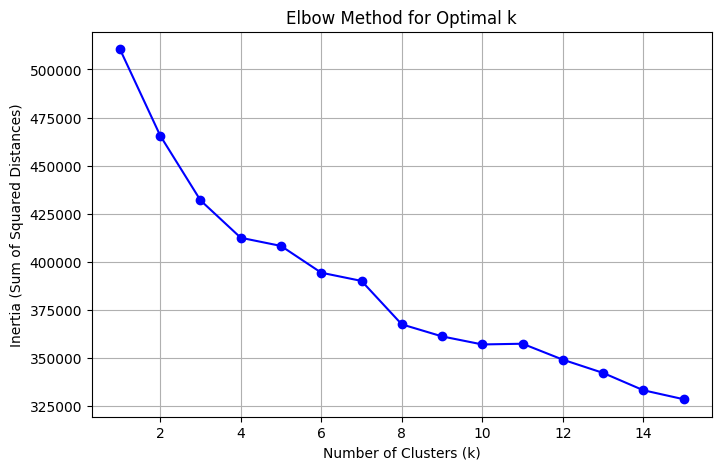

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

X = np.array(ingredient_embeddings)

inertia = []

K_range = range(1, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


Interpret the Elbow Plot
*   The x-axis represents the number of clusters (k).
*   The y-axis shows the inertia, or the within-cluster sum of squared distances.
*   The point where the plot bends, or the "elbow," is the optimal number of clusters. After this point, the rate of improvement in clustering reduces significantly.

Choosing the Optimal Number of Clusters
* Once you identify the "elbow" point from the plot, use that number of clusters in your KMeans clustering process. Let’s assume the elbow occurs at k = 8.

In [ ]:
optimal_k = 8  # Replace this with the number of clusters identified from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
clusters = kmeans.fit_predict(X)

ingredient_cluster_mapping = {ingredient: cluster for ingredient, cluster in zip(all_ingredients, clusters)}


Append Aliases Next to Ingredients
*   Now, you can append aliases to the ingredients as we did before, using the optimal number of clusters.

In [ ]:
from collections import defaultdict

cluster_groups = defaultdict(list)
for ingredient, cluster in ingredient_cluster_mapping.items():
    cluster_groups[cluster].append(ingredient)

def append_aliases(ingredient_list, cluster_mapping, cluster_groups):
    updated_ingredients = []
    for ingredient in ingredient_list.split(", "):
        cluster = cluster_mapping.get(ingredient)
        if cluster is not None:
            aliases = [alias for alias in cluster_groups[cluster] if alias != ingredient]
            if aliases:
                updated_ingredients.append(f"{ingredient}, {', '.join(aliases)}")
            else:
                updated_ingredients.append(ingredient)
        else:
            updated_ingredients.append(ingredient)
    return ", ".join(updated_ingredients)

df['Ingridients'] = df['Ingridients'].apply(append_aliases, cluster_mapping=ingredient_cluster_mapping, cluster_groups=cluster_groups)

df.to_csv("processed_restaurant_data_with_aliases_elbow_method.csv", index=False)


There is one more clustering algorithm which can be used here and i.e. DBSCAN (Density-Based Spatial Clustering of Applications with Noise) which is an excellent clustering algorithm when you don't want to explicitly define the number of clusters. DBSCAN automatically determines clusters based on the density of points and can also identify outliers (points that don't belong to any cluster).

It works differently from KMeans in that it doesn't require you to predefine the number of clusters (k). Instead, it identifies regions of high density (clusters) and isolates regions of low density (noise/outliers).

Objective
*   To handle ingredient aliases using DBSCAN clustering, where we don't want to explicitly define the number of clusters. DBSCAN will group similar ingredients based on their density in the embedding space, and ingredients without strong similarity will remain unclustered.

Why Use DBSCAN?
*   No predefined number of clusters: DBSCAN automatically finds clusters based on density, making it a good fit when you don't want to specify the number of clusters upfront.
*   Handles noise/outliers: DBSCAN can identify outliers (unclustered points), which might represent uncommon or unique ingredients.
*   Works well with embeddings: Since DBSCAN uses distance metrics, it works effectively with embeddings generated from text, like ingredient embeddings.

In [ ]:
import pandas as pd
import spacy
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data_updated_merged.csv")
df['Ingridients'] = df['Ingridients'].fillna('').astype(str)

nlp = spacy.load('en_core_web_md')

all_ingredients = set()
df['Ingridients'].str.split(', ').apply(all_ingredients.update)
all_ingredients = list(all_ingredients)

def get_embedding(ingredient):
    doc = nlp(ingredient)
    return doc.vector

ingredient_embeddings = [get_embedding(ingredient) for ingredient in all_ingredients]
X = np.array(ingredient_embeddings)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=2, metric='euclidean')
clusters_dbscan = dbscan.fit_predict(X_scaled)

ingredient_cluster_mapping_dbscan = {ingredient: cluster for ingredient, cluster in zip(all_ingredients, clusters_dbscan)}

from collections import defaultdict
cluster_groups_dbscan = defaultdict(list)
for ingredient, cluster in ingredient_cluster_mapping_dbscan.items():
    if cluster != -1:
        cluster_groups_dbscan[cluster].append(ingredient)


In [ ]:
def append_aliases_dbscan(ingredient_list, cluster_mapping, cluster_groups):
    updated_ingredients = []
    for ingredient in ingredient_list.split(", "):
        cluster = cluster_mapping.get(ingredient)
        if cluster is not None and cluster != -1:  # Ignore outliers
            aliases = [alias for alias in cluster_groups[cluster] if alias != ingredient]
            if aliases:
                updated_ingredients.append(f"{ingredient}, {', '.join(aliases)}")
            else:
                updated_ingredients.append(ingredient)
        else:
            updated_ingredients.append(ingredient)
    return ", ".join(updated_ingredients)

df['Ingredients_dbscan'] = df['Ingridients'].apply(append_aliases_dbscan, cluster_mapping=ingredient_cluster_mapping_dbscan, cluster_groups=cluster_groups_dbscan)


In [ ]:
df.to_csv("processed_restaurant_data_with_aliases_dbscan.csv", index=False)


# Saving the Aliass provided by Kmeans, kmeans with elbow method and DBSCAN method in one master csv.

In [ ]:
import pandas as pd

df_original = pd.read_csv("/content/data_updated_merged.csv")
df_kmeans_10 = pd.read_csv("/content/processed_restaurant_data_with_aliases_kmeans.csv")
df_kmeans_elbow = pd.read_csv("/content/processed_restaurant_data_with_aliases_elbow_method.csv")
df_dbscan = pd.read_csv("/content/processed_restaurant_data_with_aliases_dbscan.csv")


df_original['Ingredients_with_KMeans_10'] = df_kmeans_10['Ingridients']
df_original['Ingredients_with_KMeans_Elbow'] = df_kmeans_elbow['Ingridients']
df_original['Ingredients_with_DBSCAN'] = df_dbscan['Ingridients']

master_csv = df_original[['Restraunts', 'Dishes', 'Ingridients', 'Ingredients_with_KMeans_10', 'Ingredients_with_KMeans_Elbow', 'Ingredients_with_DBSCAN']]

master_csv.to_csv("master_restaurant_ingredients.csv", index=False)

print("Master CSV created successfully!")


Master CSV created successfully!


In [ ]:
!pip install fitz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.8 MB/s eta 0:00:00
  Created wheel for configobj: filename=configobj-5.0.9-py2.py3-none-any.whl size=35614 sha256=90c8e5365e948564b2f398711e47e8b6f542a3278a6c0954402a197ef82dda27
  Stored in directory: /root/.cache/pip/wheels/a1/6c/03/6c5e3cf1a6e4b9

In [ ]:
pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 47.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import fitz  # PyMuPDF
from fuzzywuzzy import process

menu_df = pd.read_csv('/content/master_restaurant_ingredients.csv')

def extract_products_from_pdf(pdf_path):
    products = []
    with fitz.open(pdf_path) as pdf:
        for page in pdf:
            text = page.get_text()
            for line in text.split('\n'):
                products.append(line.strip())
    return products

pdf_products = extract_products_from_pdf('PremierQualityFoodsBrochure2021.pdf')

def match_ingredients_with_products(menu_df, products):
    matches = []
    for _, row in menu_df.iterrows():
        restaurant = row['Restraunts']
        dishes = row['Dishes']
        ingredients = row['Ingredients_with_DBSCAN'].split(',')  # Assuming ingredients are comma-separated

        for ingredient in ingredients:
            ingredient = ingredient.strip()  # Clean up whitespace
            best_match = process.extractOne(ingredient, products)
            if best_match[1] >= 80:  # You can adjust the threshold as needed
                matches.append({
                    'Restaurant': restaurant,
                    'Dishes': dishes,
                    'Ingredient': ingredient,
                    'Matched Product': best_match[0],
                    'Match Score': best_match[1]
                })

    return pd.DataFrame(matches)

matched_results = match_ingredients_with_products(menu_df, pdf_products)

matched_results.to_csv('matched_ingredients_products.csv', index=False)

print("Matching completed. Results saved to 'matched_ingredients_products.csv'.")


KeyboardInterrupt: 

In [ ]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 61.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import pdfplumber
from fuzzywuzzy import process

menu_df = pd.read_csv('/content/master_restaurant_ingredients.csv')

def extract_products_from_pdf(pdf_path):
    products = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if text:  # Check if there is text on the page
                for line in text.split('\n'):
                    products.append(line.strip())
    print(f"Extracted {len(products)} products from the PDF.")
    return products

pdf_products = extract_products_from_pdf('PremierQualityFoodsBrochure2021.pdf')

def match_ingredients_with_products(menu_df, products):
    matches = []
    for _, row in menu_df.iterrows():
        restaurant = row['Restraunts']
        dishes = row['Dishes']
        ingredients = row['Ingredients_with_DBSCAN'].split(',')  # Assuming ingredients are comma-separated

        print(f"Matching products for {restaurant} - Dishes: {dishes}")

        for ingredient in ingredients:
            ingredient = ingredient.strip()  # Clean up whitespace
            best_match = process.extractOne(ingredient, products)
            print(f"Ingredient: {ingredient} | Best Match: {best_match[0]} | Score: {best_match[1]}")

            if best_match[1] >= 80:  # You can adjust the threshold as needed
                matches.append({
                    'Restaurant': restaurant,
                    'Dishes': dishes,
                    'Ingredient': ingredient,
                    'Matched Product': best_match[0],
                    'Match Score': best_match[1]
                })
                print(f"Match found: {ingredient} -> {best_match[0]}")

    print(f"Total matches found: {len(matches)}")
    return pd.DataFrame(matches)

matched_results = match_ingredients_with_products(menu_df, pdf_products)

matched_results.to_csv('matched_ingredients_products.csv', index=False)

print("Matching completed. Results saved to 'matched_ingredients_products.csv'.")


Extracted 1863 products from the PDF.
Matching products for 6Head - Dishes: Rib-eye, Sydney Rock Lobster, Dry-aged T-bone
Ingredient: rib-eye steak | Best Match: Oakvale Steak & Kidney Pies 12 x 1 ea | Score: 86
Match found: rib-eye steak -> Oakvale Steak & Kidney Pies 12 x 1 ea
Ingredient: seasoning | Best Match: Pulled pork with a blend of BBQ seasoning and sauce | Score: 90
Match found: seasoning -> Pulled pork with a blend of BBQ seasoning and sauce
Ingredient: lobster | Best Match: r | Score: 90
Match found: lobster -> r
Ingredient: garlic butter | Best Match: Garlic Sausage 1.36 kg | Score: 86
Match found: garlic butter -> Garlic Sausage 1.36 kg
Ingredient: T-bone steak | Best Match: Cooked Turkey On The Bone 4.5kg (av) | Score: 86
Match found: T-bone steak -> Cooked Turkey On The Bone 4.5kg (av)
Ingredient: seasoning | Best Match: Pulled pork with a blend of BBQ seasoning and sauce | Score: 90
Match found: seasoning -> Pulled pork with a blend of BBQ seasoning and sauce
Matching

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import pdfplumber
from fuzzywuzzy import process
from tqdm import tqdm

menu_df = pd.read_csv('/content/master_restaurant_ingredients.csv')

def extract_products_from_pdf(pdf_path):
    products = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if text:  # Check if there is text on the page
                for line in text.split('\n'):
                    products.append(line.strip())
    print(f"Extracted {len(products)} products from the PDF.")
    return products

pdf_products = extract_products_from_pdf('PremierQualityFoodsBrochure2021.pdf')

def match_ingredients_with_products(menu_df, products):
    matches = []

    for idx, row in tqdm(menu_df.iterrows(), total=len(menu_df), desc="Matching Products"):
        if idx < 404:  # Skip rows before 404
            continue
        restaurant = row['Restraunts']
        dishes = row['Dishes']
        ingredients = row['Ingredients_with_DBSCAN'].split(',')

        print(f"Matching products for {restaurant} - Dishes: {dishes}")

        for ingredient in ingredients:
            ingredient = ingredient.strip()  # Clean up whitespace
            best_match = process.extractOne(ingredient, products)
            print(f"Ingredient: {ingredient} | Best Match: {best_match[0]} | Score: {best_match[1]}")

            if best_match[1] >= 80:  # You can adjust the threshold as needed
                matches.append({
                    'Restaurant': restaurant,
                    'Dishes': dishes,
                    'Ingredient': ingredient,
                    'Matched Product': best_match[0],
                    'Match Score': best_match[1]
                })
                print(f"Match found: {ingredient} -> {best_match[0]}")

        if (idx + 1) % 20 == 0:
            checkpoint_df = pd.DataFrame(matches)
            checkpoint_df.to_csv(f'matched_ingredients_products_checkpoint_{idx + 1}.csv', index=False)
            print(f"Checkpoint saved after processing {idx + 1} rows.")

    print(f"Total matches found: {len(matches)}")
    return pd.DataFrame(matches)

matched_results = match_ingredients_with_products(menu_df, pdf_products)

matched_results.to_csv('matched_ingredients_products.csv', index=False)

print("Matching completed. Results saved to 'matched_ingredients_products.csv'.")


Extracted 1863 products from the PDF.


Matching Products:   0%|          | 0/606 [00:00<?, ?it/s]

Matching products for The Criterion Hotel - Dishes: Fish & Chips, Steak, Lamb Shanks
Ingredient: Fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: Fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: beef | Best Match: Beef | Score: 100
Match found: beef -> Beef
Ingredient: lamb shanks | Best Match: Minted Lamb S H 1kg | Score: 86
Match found: lamb shanks -> Minted Lamb S H 1kg
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  67%|██████▋   | 405/606 [00:06<00:03, 62.41it/s]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Crooked Pint - Dishes: Burgers, Beer Selection
Ingredient: variety of meats | Best Match: ie | Score: 90
Match found: variety of meats -> ie
Ingredient: variety of beers | Best Match: ie | Score: 90
Match found: variety of beers -> ie
Matching products for The Cuban Cafe - Dishes: Cuban Sandwich, Arroz con Pollo, Empanadas, Tostones, Flan
Ingredient: Pork | Best Match: Pork Soft Cheese & Curd | Score: 90
Match found: Pork -> Pork Soft Cheese & Curd
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Ham | Best Match: ham | Score: 100
Match found: Ham -> ham
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Ingredient: Plantains | Best Match: Plant Based Burger 24 x 113 g | Score: 70
Matching products

Matching Products:  67%|██████▋   | 405/606 [00:24<00:03, 62.41it/s]

Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Ingredient: Premium meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: Premium meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg
Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p


Matching Products:  67%|██████▋   | 409/606 [00:31<00:20,  9.65it/s]

Ingredient: fine dining ingredients | Best Match: ingredients. | Score: 90
Match found: fine dining ingredients -> ingredients.
Matching products for The District - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g


Matching Products:  68%|██████▊   | 410/606 [00:39<00:28,  6.99it/s]

Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Matching products for The Dolphin Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Pasta, Pub Classics, Steak, Seafood
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: c

Matching Products:  68%|██████▊   | 412/606 [00:55<00:48,  3.96it/s]

Ingredient: Plantains | Best Match: Plant Based Burger 24 x 113 g | Score: 70
Matching products for The Dove & Olive - Dishes: Breakfast Plates, Sandwiches, Salads, Pasta, Burgers
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: Bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: Bacon -> Continental Cheese Bacon & Gammon
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p


Matching Products:  68%|██████▊   | 413/606 [01:02<01:00,  3.19it/s]

Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Matching products for The Duke - Dishes: Fish Tacos, Grilled Chicken, Burgers
Ingredient: Fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: Fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: chicken breast | Best Match: Cater Pack Chicken Breast Slices 1 kg | Score: 90
Match found: chicken breast -> Cater Pack Chicken Breast Slices 1 kg
Ingredient: beef patty | Best Match: Beef | Score: 90
Match found: beef patty -> Beef
Ingredient: taco shells | Best Match: Hull | Score: 68
Ingredient: lettuce | Best Match: e | Score: 90
Match found: lettuce -> e
Ingredient: tomato | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: tomato -> Sundried Tomatoes 1 kg
Ingredient: salsa | Best Match: a | Score: 90
Match found: salsa -> a
Ingredient: avocado | Best Match: a | Score: 90
Ma

Matching Products:  68%|██████▊   | 415/606 [01:13<01:27,  2.18it/s]

Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Matching products for The Ecuadorian Restaurant - Dishes: Llapingachos, Seco de Pollo, Empanadas, Ceviche, Pan de Yuca
Ingredient: Potatoes | Best Match: p | Score: 90
Match found: Potatoes -> p
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h


Matching Products:  69%|██████▊   | 416/606 [01:18<01:43,  1.83it/s]

Ingredient: Yuca | Best Match: a | Score: 90
Match found: Yuca -> a
Matching products for The Egyptian Restaurant - Dishes: Koshari, Falafel, Shawarma, Mahshi, Umm Ali
Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Ingredient: Lentils | Best Match: e | Score: 90
Match found: Lentils -> e
Ingredient: Chickpeas | Best Match: Falafel Chick Pea in Roast Pepper Salsa S H V 1kg | Score: 80
Match found: Chickpeas -> Falafel Chick Pea in Roast Pepper Salsa S H V 1kg
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  69%|██████▉   | 417/606 [01:24<02:09,  1.46it/s]

Ingredient: Puff Pastry | Best Match: Wrights Steak Puff Pastry Pies 32 x 200 g | Score: 90
Match found: Puff Pastry -> Wrights Steak Puff Pastry Pies 32 x 200 g
Matching products for The Empire Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Burgers, Sandwiches, Salads, Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef patty | Best Match: Beef | Score: 90
Match found: Beef patty -> Beef
Ingredient: bun | Best Match: u | Score: 90
Match found: bun -> u
Ingredient: lettuce | Best Match: e | Score: 90
Match found: lettuce -> e
Ingredient: tomato | Best Match: Sundri

Matching Products:  69%|██████▉   | 418/606 [01:44<04:23,  1.40s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Enmore - Dishes: Veggie Burger, Fish & Chips, Salads
Ingredient: Veggie patty | Best Match: ie | Score: 90
Match found: Veggie patty -> ie
Ingredient: fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: mixed greens | Best Match: Diced potato mixed with onion and spring onion in a thick and creamy mayonnaise Spicy Rice V 1kg | Score: 86
Match found: mixed greens -> Diced potato mixed with onion and spring onion in a thick and creamy mayonnaise Spicy Rice V 1kg
Ingredient: vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: proteins | 

Matching Products:  69%|██████▉   | 419/606 [01:51<05:12,  1.67s/it]

Ingredient: tomato | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: tomato -> Sundried Tomatoes 1 kg
Matching products for The Enmore Theatre Cafe - Dishes: Breakfast Plates, Sandwiches, Salads, Pastries
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: Bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: Bacon -> Continental Cheese Bacon & Gammon
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg


Matching Products:  69%|██████▉   | 420/606 [01:55<05:41,  1.84s/it]

Ingredient: Pastry | Best Match: p | Score: 90
Match found: Pastry -> p
Checkpoint saved after processing 420 rows.
Matching products for The Equity Hotel - Dishes: Fine Dining, Steak, Seafood
Ingredient: Premium meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: Premium meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg
Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p


Matching Products:  69%|██████▉   | 421/606 [02:05<07:54,  2.56s/it]

Ingredient: fine dining ingredients | Best Match: ingredients. | Score: 90
Match found: fine dining ingredients -> ingredients.
Matching products for The Erko Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pizzas
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken


Matching Products:  70%|██████▉   | 422/606 [02:09<08:14,  2.68s/it]

Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Matching products for The Establishment - Dishes: Oysters, Steak Tartare, Grilled Octopus, Fish of the Day, Lamb Cutlets
Ingredient: Oysters | Best Match: r | Score: 90
Match found: Oysters -> r
Ingredient: Steak | Best Match: e | Score: 90
Match found: Steak -> e
Ingredient: Octopus | Best Match: p | Score: 90
Match found: Octopus -> p
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h


Matching Products:  70%|██████▉   | 423/606 [02:12<08:17,  2.72s/it]

Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Matching products for The Ethiopian Restaurant - Dishes: Injera, Tibs, Misir Wot, Sambusa, Kitfo
Ingredient: Flatbread | Best Match: Bread | Score: 90
Match found: Flatbread -> Bread
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  70%|██████▉   | 424/606 [02:17<09:16,  3.06s/it]

Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Matching products for The Excelsior Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Scor

Matching Products:  70%|███████   | 425/606 [02:28<13:43,  4.55s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Factory - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g


Matching Products:  70%|███████   | 426/606 [02:32<13:50,  4.61s/it]

Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Matching products for The Fat Angel - Dishes: Breakfast Plates, Sandwiches, Salads, Pasta, Burgers
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: Bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: Bacon -> Continental Cheese Bacon & Gammon
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p


Matching Products:  70%|███████   | 427/606 [02:38<14:35,  4.89s/it]

Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Matching products for The Filipino Restaurant - Dishes: Adobo, Lechon, Sinigang, Lumpia, Halo-Halo
Ingredient: Pork | Best Match: Pork Soft Cheese & Curd | Score: 90
Match found: Pork -> Pork Soft Cheese & Curd
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Shrimp | Best Match: h | Score: 90
Match found: Shrimp -> h


Matching Products:  71%|███████   | 428/606 [02:45<15:47,  5.32s/it]

Ingredient: Coconut Milk | Best Match: Brie is a soft cow's-milk cheese named after Brie, the French region from which it originated. o | Score: 86
Match found: Coconut Milk -> Brie is a soft cow's-milk cheese named after Brie, the French region from which it originated. o
Matching products for The Fine Dining Room - Dishes: Grilled Lamb Chops, Pan-Seared Salmon, Beef Stroganoff, Roasted Vegetable Salad, Chicken Tikka Masala
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Salmon | Best Match: a | Score: 90
Match found: Salmon -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Cream | Best Match: Beef Soured

Matching Products:  71%|███████   | 429/606 [02:49<14:54,  5.05s/it]

Ingredient: Spices | Best Match: p | Score: 90
Match found: Spices -> p
Matching products for The Fine Food Store - Dishes: Avocado Toast, Coffee & Croissants, Quiche
Ingredient: Avocado | Best Match: a | Score: 90
Match found: Avocado -> a
Ingredient: sourdough bread | Best Match: Bread | Score: 90
Match found: sourdough bread -> Bread
Ingredient: coffee beans | Best Match: Arabica Coffee Beans 6 x 1 kg | Score: 90
Match found: coffee beans -> Arabica Coffee Beans 6 x 1 kg
Ingredient: croissant pastry | Best Match: Ingredient Pastry & Yorkshire Puddings. . . . . . . . . . . . . . . 53 | Score: 86
Match found: croissant pastry -> Ingredient Pastry & Yorkshire Puddings. . . . . . . . . . . . . . . 53
Ingredient: eggs | Best Match: Poultry Eggs | Score: 90
Match found: eggs -> Poultry Eggs
Ingredient: cream | Best Match: Beef Soured Cream & Yoghurt | Score: 90
Match found: cream -> Beef Soured Cream & Yoghurt


Matching Products:  71%|███████   | 430/606 [02:57<16:53,  5.76s/it]

Ingredient: cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: cheese -> Ham Sliced & Pre-Pack Cheese
Matching products for The Firestone - Dishes: American, Burgers, Sandwiches
Ingredient: Beef patty | Best Match: Beef | Score: 90
Match found: Beef patty -> Beef
Ingredient: bun | Best Match: u | Score: 90
Match found: bun -> u
Ingredient: lettuce | Best Match: e | Score: 90
Match found: lettuce -> e
Ingredient: tomato | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: tomato -> Sundried Tomatoes 1 kg
Ingredient: cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: onion | Best Match: o | Score: 90
Match found: onion -> o
Ingredient: bread | Best Match: Bread | Score: 100
Match found: bread -> Bread
Ingredient: fillings | Best Match: f | Score: 90
Match found: fillings -> f
Ingredient: mixed greens | Best Match: Diced potato mixed with onion and spring onion in a thick and creamy

Matching Products:  71%|███████   | 431/606 [03:07<20:30,  7.03s/it]

Ingredient: vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Matching products for The Fish Shop - Dishes: Seafood, Fish & Chips, Sushi
Ingredient: Seafood mix | Best Match: Seafood | Score: 90
Match found: Seafood mix -> Seafood
Ingredient: fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: sushi rice | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: sushi rice -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: raw fish | Best Match: h | Score: 90
Match found: raw fish -> h
Ingredient: soy sauce | Best Match: Red cabbage, white ca

Matching Products:  71%|███████▏  | 432/606 [03:13<19:08,  6.60s/it]

Ingredient: wasabi | Best Match: w | Score: 90
Match found: wasabi -> w
Matching products for The Food Studio - Dishes: Grilled Chicken, Pan-Seared Salmon, Beef and Mushroom Gravy, Chicken Caesar Salad
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Salmon | Best Match: a | Score: 90
Match found: Salmon -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Mushrooms | Best Match: Sliced Mushrooms 2.5 kg | Score: 90
Match found: Mushrooms -> Sliced Mushrooms 2.5 kg


Matching Products:  71%|███████▏  | 433/606 [03:17<17:25,  6.05s/it]

Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Matching products for The Forbes Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Pub Classics, Steak, Seafood
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra V

Matching Products:  72%|███████▏  | 434/606 [03:28<21:24,  7.47s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Forest Lodge - Dishes: Pub Classics, Craft Beer
Ingredient: variety of dishes | Best Match: customer service at the top of our agenda. | Score: 86
Match found: variety of dishes -> customer service at the top of our agenda.


Matching Products:  72%|███████▏  | 435/606 [03:31<17:17,  6.07s/it]

Ingredient: local brews | Best Match: w | Score: 60
Matching products for The Forresters Hotel - Dishes: Fish & Chips, Steak, Lamb Kofta
Ingredient: Fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: Fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: beef | Best Match: Beef | Score: 100
Match found: beef -> Beef
Ingredient: lamb mince | Best Match: Catering Tray Pie Mince & Onion 1 ea . | Score: 86
Match found: lamb mince -> Catering Tray Pie Mince & Onion 1 ea .
Ingredient: onion | Best Match: o | Score: 90
Match found: onion -> o
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg
Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p


Matching Products:  72%|███████▏  | 436/606 [03:38<18:25,  6.50s/it]

Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Matching products for The Four in Hand - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pizzas
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken


Matching Products:  72%|███████▏  | 437/606 [03:45<17:59,  6.39s/it]

Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Matching products for The French Bistro - Dishes: Pan-Seared Chicken Breast, Grilled Lamb Burgers, Beef and Mushroom Bourguignon, Chicken and Spinach Quiche, Crepes
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Mushrooms | Best Match: Sliced Mushrooms 2.5 kg | Score: 90
Match found: Mushrooms -> Sliced Mushrooms 2.5 kg
Ingredient: Spinach | Best Match: h | Score: 90
Match found: Spinach -> h
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs


Matching Products:  72%|███████▏  | 438/606 [03:49<16:02,  5.73s/it]

Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Matching products for The French Creperie - Dishes: Crepes, Quiche, Baguette, Croissants, Macarons
Ingredient: Crepes | Best Match: p | Score: 90
Match found: Crepes -> p
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: Ham | Best Match: ham | Score: 100
Match found: Ham -> ham
Ingredient: Butter | Best Match: r | Score: 90
Match found: Butter -> r


Matching Products:  72%|███████▏  | 439/606 [03:52<13:58,  5.02s/it]

Ingredient: Sugar | Best Match: r | Score: 90
Match found: Sugar -> r
Matching products for The Gallery Restaurant - Dishes: Grilled Steak, Seafood Paella, Fish of the Day, Vegetarian Skewers, Lamb Chops
Ingredient: Steak | Best Match: e | Score: 90
Match found: Steak -> e
Ingredient: Seafood | Best Match: Seafood | Score: 100
Match found: Seafood -> Seafood
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  73%|███████▎  | 440/606 [03:56<12:54,  4.67s/it]

Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Checkpoint saved after processing 440 rows.
Matching products for The Ganesh - Dishes: Indian, Curries, Tandoori Chicken
Ingredient: Tandoori chicken | Best Match: Marinated Tandoori Chicken H 1kg | Score: 90
Match found: Tandoori chicken -> Marinated Tandoori Chicken H 1kg
Ingredient: curry paste | Best Match: White rice and sultanas in a spicy coronation curry mayonnaise | Score: 86
Match found: curry paste -> White rice and sultanas in a spicy coronation curry mayonnaise
Ingredient: coconut milk | Best Match: Brie is a soft cow's-milk cheese named after Brie, the French region from which it originated. o | Score: 86
Match found: coconut milk -> Brie is a soft cow's-milk cheese named after Brie, the French region from which it originated. o
Ingredient: fish sauce | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: fish sauce -> Canned Fish. . . . . . 

Matching Products:  73%|███████▎  | 441/606 [04:05<16:34,  6.03s/it]

Ingredient: lime leaves | Best Match: Marinated Lime & Coriander Chicken H 1kg Marinated Mexican Chicken S H 1kg | Score: 86
Match found: lime leaves -> Marinated Lime & Coriander Chicken H 1kg Marinated Mexican Chicken S H 1kg
Matching products for The George Street Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  73%|███████▎  | 442/606 [04:10<15:44,  5.76s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Georgian Restaurant - Dishes: Khinkali, Khachapuri, Satsivi, Lobio, Churchkhela
Ingredient: Dumplings | Best Match: Supplying a range of quality mayonnaise products | Score: 61
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: Bread | Best Match: Bread | Score: 100
Match found: Bread -> Bread
Ingredient: Beans | Best Match: e | Score: 90
Match found: Beans -> e


Matching Products:  73%|███████▎  | 443/606 [04:14<13:42,  5.05s/it]

Ingredient: Fruits | Best Match: r | Score: 90
Match found: Fruits -> r
Matching products for The German Beer Garden - Dishes: Bratwurst, Schnitzel, Sauerkraut, Potato Salad, Black Forest Cake
Ingredient: Pork | Best Match: Pork Soft Cheese & Curd | Score: 90
Match found: Pork -> Pork Soft Cheese & Curd
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Potatoes | Best Match: p | Score: 90
Match found: Potatoes -> p


Matching Products:  73%|███████▎  | 444/606 [04:20<14:22,  5.32s/it]

Ingredient: Chocolate | Best Match: Callebaut Milk Chocolate Callets 2.5 kg | Score: 90
Match found: Chocolate -> Callebaut Milk Chocolate Callets 2.5 kg
Matching products for The Glenmore Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings


Matching Products:  73%|███████▎  | 445/606 [04:21<10:43,  4.00s/it]

Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Matching products for The Golden Age Hotel - Dishes: Cocktails, Tapas
Ingredient: Spirits | Best Match: p | Score: 90
Match found: Spirits -> p
Ingredient: mixers | Best Match: r | Score: 90
Match found: mixers -> r
Ingredient: garnishes | Best Match: in mayonnaise and yogannaise Arabiata Meatballs S H 1kg | Score: 61
Ingredient: tapas items (meat | Best Match: many more items required by the catering industry. | Score: 86
Match found: tapas items (meat -> many more items required by the catering industry.
Ingredient: cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: cheese -> Ham Sliced & Pre-Pack Cheese


Matching Products:  74%|███████▎  | 446/606 [04:27<12:49,  4.81s/it]

Ingredient: vegetables) | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: vegetables) -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Matching products for The Golden Century - Dishes: Chinese, Dumplings, Noodles
Ingredient: Dumpling wrappers | Best Match: Pies | Score: 68
Ingredient: pork | Best Match: Pork Soft Cheese & Curd | Score: 90
Match found: pork -> Pork Soft Cheese & Curd
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: noodles | Best Match: e | Score: 90
Match found: noodles -> e
Ingredient: soy sauce | Best Match: Red cabbage, white cabbage, carrot and onion in a minty paprika sauce | Score: 86
Match found: so

Matching Products:  74%|███████▍  | 447/606 [04:33<13:25,  5.07s/it]

Ingredient: ginger | Best Match: r | Score: 90
Match found: ginger -> r
Matching products for The Golden Sheaf - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pizzas
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken


Matching Products:  74%|███████▍  | 448/606 [04:39<13:49,  5.25s/it]

Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Matching products for The Gourmet Grill - Dishes: Grilled Shrimp Skewers, Pan-Seared Duck Breast, Beef and Broccoli Stir-Fry, Chicken Caesar Salad, Vegetable Samosas
Ingredient: Shrimp | Best Match: h | Score: 90
Match found: Shrimp -> h
Ingredient: Duck | Best Match: Savoury Ducks 2 x 15 pk | Score: 90
Match found: Duck -> Savoury Ducks 2 x 15 pk
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Broccoli | Best Match: r | Score: 90
Match found: Broccoli -> r
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e


Matching Products:  74%|███████▍  | 449/606 [04:45<14:53,  5.69s/it]

Ingredient: Croutons | Best Match: r | Score: 90
Match found: Croutons -> r
Matching products for The Gourmet Pizza Kitchen - Dishes: Pizzas, Salads, Pasta, Burgers, Garlic Bread
Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Ingredient: Tomato Sauce | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 90
Match found: Tomato Sauce -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e


Matching Products:  74%|███████▍  | 450/606 [04:49<13:21,  5.14s/it]

Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Matching products for The Gourmet Table - Dishes: Grilled Lamb Chops, Pan-Seared Duck Breast, Beef and Mushroom Gravy, Chicken Caesar Salad
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Duck | Best Match: Savoury Ducks 2 x 15 pk | Score: 90
Match found: Duck -> Savoury Ducks 2 x 15 pk
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Mushrooms | Best Match: Sliced Mushrooms 2.5 kg | Score: 90
Match found: Mushrooms -> Sliced Mushrooms 2.5 kg
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken


Matching Products:  74%|███████▍  | 451/606 [04:53<11:58,  4.64s/it]

Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Matching products for The Grand Central Hotel - Dishes: Burgers, Salads, Fish and Chips, Steak Sandwich, Chicken Parmigiana
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken


Matching Products:  75%|███████▍  | 452/606 [04:58<12:34,  4.90s/it]

Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Matching products for The Grand Hotel - Dishes: Fine Dining, Steak, Seafood
Ingredient: Premium meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: Premium meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg
Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p


Matching Products:  75%|███████▍  | 453/606 [05:07<15:49,  6.21s/it]

Ingredient: fine dining ingredients | Best Match: ingredients. | Score: 90
Match found: fine dining ingredients -> ingredients.
Matching products for The Grand National Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e


Matching Products:  75%|███████▍  | 454/606 [05:11<13:22,  5.28s/it]

Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Matching products for The Grandstand - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  75%|███████▌  | 455/606 [05:17<13:56,  5.54s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Greek Isle - Dishes: Gyro, Moussaka, Greek Salad, Grilled Octopus, Baklava
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Feta Cheese | Best Match: Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18 | Score: 86
Match found: Feta Cheese -> Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18
Ingredient: Honey | Best Match: h | Score: 90
Match found: Honey -> h


Matching Products:  75%|███████▌  | 456/606 [05:24<15:09,  6.06s/it]

Ingredient: Pastry | Best Match: p | Score: 90
Match found: Pastry -> p
Matching products for The Greek Restaurant - Dishes: Gyro, Moussaka, Greek Salad, Grilled Octopus, Baklava
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Feta Cheese | Best Match: Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18 | Score: 86
Match found: Feta Cheese -> Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18
Ingredient: Honey | Best Match: h | Score: 90
Match found: Honey -> h


Matching Products:  75%|███████▌  | 457/606 [05:28<13:38,  5.49s/it]

Ingredient: Pastry | Best Match: p | Score: 90
Match found: Pastry -> p
Matching products for The Greek Taverna - Dishes: Grilled Lamb Chops, Chicken Gyro, Vegetable Moussaka, Greek Salad, Baklava
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Feta Cheese | Best Match: Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18 | Score: 86
Match found: Feta Cheese -> Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18
Ingredient: Honey | Best Match: h | Score: 90
Match found: Honey -> h


Matching Products:  76%|███████▌  | 458/606 [05:32<12:39,  5.13s/it]

Ingredient: Pastry | Best Match: p | Score: 90
Match found: Pastry -> p
Matching products for The Grounds of Alexandria - Dishes: Cafe, Breakfast, Brunch, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g
Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Ingredient: mixe

Matching Products:  76%|███████▌  | 459/606 [05:44<17:09,  7.00s/it]

Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Matching products for The Grounds of the City - Dishes: All-day Breakfast, Pastries,  Specialty Coffee , All-day Breakfast, Pastries, Specialty Coffee, Burgers, Sandwiches, Salads
Ingredient: eggs | Best Match: Poultry Eggs | Score: 90
Match found: eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: avocado | Best Match: a | Score: 90
Match found: avocado -> a
Ingredient: Baked goods | Best Match: will schedule to call you at a convenient able to deliver all goods ordered; if a | Score: 86
Match found: Baked goods -> will schedule to call you at a convenient able to deliver all goods ordered; if a
Ingredient: coffee beans | Best Match: Arabica Coffee Beans 6 x 1 kg | Score: 90
Match found: coffee beans -> Arabica Coffee Beans 6 x 1 kg
Ingredie

Matching Products:  76%|███████▌  | 460/606 [06:05<27:25, 11.27s/it]

Ingredient: vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Checkpoint saved after processing 460 rows.
Matching products for The Guatemalan Restaurant - Dishes: Jocón, Pepián, Chiles Rellenos, Empanadas, Flan
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese


Matching Products:  76%|███████▌  | 461/606 [06:09<21:39,  8.96s/it]

Ingredient: Plantains | Best Match: Plant Based Burger 24 x 113 g | Score: 70
Matching products for The Hamburglar - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h


Matching Products:  76%|███████▌  | 462/606 [06:12<17:19,  7.22s/it]

Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Matching products for The Hamilton - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g


Matching Products:  76%|███████▋  | 463/606 [06:19<16:55,  7.10s/it]

Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Matching products for The Haymarket Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  77%|███████▋  | 464/606 [06:26<16:55,  7.15s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Hazy Rose - Dishes: Craft Cocktails, Bar Snacks
Ingredient: variety of spirits | Best Match: customer service at the top of our agenda. | Score: 86
Match found: variety of spirits -> customer service at the top of our agenda.


Matching Products:  77%|███████▋  | 465/606 [06:29<13:43,  5.84s/it]

Ingredient: small dishes | Best Match: Pork Pies 'Hand Raised' Small 20 x 165 g Quiche Lorraine 26 cm h | Score: 86
Match found: small dishes -> Pork Pies 'Hand Raised' Small 20 x 165 g Quiche Lorraine 26 cm h
Matching products for The Hideaway - Dishes: Grilled Steak, Pan-Seared Fish, Seafood Paella, Shrimp Cocktail, Crab Cakes
Ingredient: Steak | Best Match: e | Score: 90
Match found: Steak -> e
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Seafood | Best Match: Seafood | Score: 100
Match found: Seafood -> Seafood
Ingredient: Saffron | Best Match: r | Score: 90
Match found: Saffron -> r


Matching Products:  77%|███████▋  | 466/606 [06:31<11:29,  4.93s/it]

Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Matching products for The Hill Eatery - Dishes: Breakfast Menu, Dinner Menu
Ingredient: variety of dishes | Best Match: customer service at the top of our agenda. | Score: 86
Match found: variety of dishes -> customer service at the top of our agenda.


Matching Products:  77%|███████▋  | 467/606 [06:35<10:28,  4.52s/it]

Ingredient: seasonal dishes | Best Match: streaky but with even more flavour to further enhance and compliment other dishes. | Score: 86
Match found: seasonal dishes -> streaky but with even more flavour to further enhance and compliment other dishes.
Matching products for The Hive Bar - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  77%|███████▋  | 468/606 [06:44<13:28,  5.86s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Honduran Restaurant - Dishes: Baleadas, Carne Asada, Fried Fish, Yuca Frita, Arroz con Pollo
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Yuca | Best Match: a | Score: 90
Match found: Yuca -> a


Matching Products:  77%|███████▋  | 469/606 [06:47<11:10,  4.89s/it]

Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Matching products for The Hotel CBD - Dishes: Fish Tacos, Chicken Wings, Pizzas, Salads, Burgers, Pub Classics, Steak, Seafood
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingred

Matching Products:  78%|███████▊  | 470/606 [06:56<14:17,  6.30s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Hotel Coronation - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e


Matching Products:  78%|███████▊  | 471/606 [07:02<13:48,  6.14s/it]

Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Matching products for The House of Bentley - Dishes: Fine Dining, Steak, Seafood
Ingredient: Premium meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: Premium meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg
Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p


Matching Products:  78%|███████▊  | 472/606 [07:10<14:45,  6.61s/it]

Ingredient: fine dining ingredients | Best Match: ingredients. | Score: 90
Match found: fine dining ingredients -> ingredients.
Matching products for The Imperial Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  78%|███████▊  | 473/606 [07:15<13:46,  6.22s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Indian Dhaba - Dishes: Butter Chicken, Palak Paneer, Naan Bread, Samosas, Chana Masala
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: h | Score: 90
Match found: Spinach -> h
Ingredient: Paneer | Best Match: p | Score: 90
Match found: Paneer -> p
Ingredient: Chickpeas | Best Match: Falafel Chick Pea in Roast Pepper Salsa S H V 1kg | Score: 80
Match found: Chickpeas -> Falafel Chick Pea in Roast Pepper Salsa S H V 1kg


Matching Products:  78%|███████▊  | 474/606 [07:21<13:50,  6.29s/it]

Ingredient: Naan Bread | Best Match: Bread | Score: 90
Match found: Naan Bread -> Bread
Matching products for The Indian Oven - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas, Butter Chicken
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: h | Score: 90
Match found: Spinach -> h
Ingredient: Paneer | Best Match: p | Score: 90
Match found: Paneer -> p
Ingredient: Chickpeas | Best Match: Falafel Chick Pea in Roast Pepper Salsa S H V 1kg | Score: 80
Match found: Chickpeas -> Falafel Chick Pea in Roast Pepper Salsa S H V 1kg


Matching Products:  78%|███████▊  | 475/606 [07:26<12:56,  5.93s/it]

Ingredient: Naan Bread | Best Match: Bread | Score: 90
Match found: Naan Bread -> Bread
Matching products for The Indian Palace - Dishes: Chicken Tikka Masala, Vegetable Curry, Naan Bread, Samosas, Butter Chicken, Indian, Curries, Tandoori Chicken
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Cream | Best Match: Beef Soured Cream & Yoghurt | Score: 90
Match found: Cream -> Beef Soured Cream & Yoghurt
Ingredient: Spices | Best Match: p | Score: 90
Match found: Spices -> p
Ingredient: Butter | Best Match: r | Score: 90
Match found: Butter -> r
Ingredient: Naan Bread | Best Match: Bread | Score: 90
Match found: Naan Bread -> Bread
Ingredient: Tandoori chicken | Best Match: Marinated Tandoori Chicken H 1kg | Score: 

Matching Products:  79%|███████▊  | 476/606 [07:38<16:32,  7.63s/it]

Ingredient: lime leaves | Best Match: Marinated Lime & Coriander Chicken H 1kg Marinated Mexican Chicken S H 1kg | Score: 86
Match found: lime leaves -> Marinated Lime & Coriander Chicken H 1kg Marinated Mexican Chicken S H 1kg
Matching products for The Iranian Restaurant - Dishes: Kebabs, Ghormeh Sabzi, Fesenjan, Tahdig, Baklava
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Pomegranate | Best Match: Tate & Lyle Granulated Sugar 5 kg | Score: 66


Matching Products:  79%|███████▊  | 477/606 [07:44<15:26,  7.18s/it]

Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Matching products for The Iraqi Restaurant - Dishes: Masgouf, Dolma, Gormeh Sabzi, Falafel, Kleicha
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Chickpeas | Best Match: Falafel Chick Pea in Roast Pepper Salsa S H V 1kg | Score: 80
Match found: Chickpeas -> Falafel Chick Pea in Roast Pepper Salsa S H V 1kg


Matching Products:  79%|███████▉  | 478/606 [07:48<12:51,  6.02s/it]

Ingredient: Dates | Best Match: e | Score: 90
Match found: Dates -> e
Matching products for The Italian Kitchen - Dishes: Chicken and Mushroom Risotto, Beef and Onion Meatball Sub, Vegetable Lasagna, Bruschetta, Tiramisu
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Mushrooms | Best Match: Sliced Mushrooms 2.5 kg | Score: 90
Match found: Mushrooms -> Sliced Mushrooms 2.5 kg
Ingredient: Arborio Rice | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: Arborio Rice -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Onions | Best Match: o | Score: 90
Match found: Onions -> o
Ingredient: Lasagna | Best Match: a | Score: 90
Match found: Lasagna -> a


Matching Products:  79%|███████▉  | 479/606 [07:53<12:07,  5.73s/it]

Ingredient: Bread | Best Match: Bread | Score: 100
Match found: Bread -> Bread
Matching products for The Italian Pizzeria - Dishes: Pizza, Pasta, Bruschetta, Caprese Salad, Tiramisu
Ingredient: Pizza Dough | Best Match: Spam 1.81 kg Spicy Pizza Sauce 2.95 kg | Score: 86
Match found: Pizza Dough -> Spam 1.81 kg Spicy Pizza Sauce 2.95 kg
Ingredient: Tomato Sauce | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 90
Match found: Tomato Sauce -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Ingredient: Mozzarella | Best Match: Mozzarella Block 2.3kg (av) | Score: 90
Match found: Mozzarella -> Mozzarella Block 2.3kg (av)
Ingredient: Basil | Best Match: a | Score: 90
Match found: Basil -> a


Matching Products:  79%|███████▉  | 480/606 [07:58<12:06,  5.76s/it]

Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Checkpoint saved after processing 480 rows.
Matching products for The Japanese Sushi Bar - Dishes: Sushi Rolls, Sashimi, Ramen, Udon Noodles, Tempura
Ingredient: Sushi Rice | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: Sushi Rice -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e
Ingredient: Broth | Best Match: h | Score: 90
Match found: Broth -> h


Matching Products:  79%|███████▉  | 481/606 [08:05<12:36,  6.05s/it]

Ingredient: Batter | Best Match: r | Score: 90
Match found: Batter -> r
Matching products for The Japanese Teppanyaki - Dishes: Teppanyaki Chicken, Shrimp, Beef, Vegetables, Fried Rice
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Shrimp | Best Match: h | Score: 90
Match found: Shrimp -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  80%|███████▉  | 482/606 [08:08<10:45,  5.21s/it]

Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Matching products for The Keg & Brew - Dishes: Burgers, Salads, Fish and Chips, Steak Sandwich, Chicken Parmigiana
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken


Matching Products:  80%|███████▉  | 483/606 [08:12<09:48,  4.78s/it]

Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Matching products for The Kent Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  80%|███████▉  | 484/606 [08:20<11:17,  5.55s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Kitchen Table - Dishes: Grilled Chicken, Pan-Seared Salmon, Beef and Mushroom Gravy, Chicken Caesar Salad
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Salmon | Best Match: a | Score: 90
Match found: Salmon -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Mushrooms | Best Match: Sliced Mushrooms 2.5 kg | Score: 90
Match found: Mushrooms -> Sliced Mushrooms 2.5 kg


Matching Products:  80%|████████  | 485/606 [08:25<10:54,  5.41s/it]

Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Matching products for The Kitchens on Kent - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g


Matching Products:  80%|████████  | 486/606 [08:29<10:27,  5.23s/it]

Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Matching products for The Korean BBQ - Dishes: Grilled Beef Short Ribs, Chicken Bulgogi, Vegetable Skewers, Kimchi, Bibimbap
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Kimchi | Best Match: h | Score: 90
Match found: Kimchi -> h
Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r


Matching Products:  80%|████████  | 487/606 [08:33<09:40,  4.88s/it]

Ingredient: Fried Egg | Best Match: ie | Score: 90
Match found: Fried Egg -> ie
Matching products for The Korean Fried Chicken - Dishes: Fried Chicken, Kimchi, Bulgogi Burger, Bibimbap, Japchae
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Kimchi | Best Match: h | Score: 90
Match found: Kimchi -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  81%|████████  | 488/606 [08:39<09:41,  4.93s/it]

Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Matching products for The Kurrajong Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h


Matching Products:  81%|████████  | 489/606 [08:44<09:54,  5.08s/it]

Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Matching products for The Landsdowne Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e


Matching Products:  81%|████████  | 490/606 [08:47<08:40,  4.49s/it]

Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Matching products for The Langham Sydney - Dishes: Fine Dining, Steak, Seafood
Ingredient: Premium meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: Premium meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg
Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p


Matching Products:  81%|████████  | 491/606 [08:54<09:51,  5.14s/it]

Ingredient: fine dining ingredients | Best Match: ingredients. | Score: 90
Match found: fine dining ingredients -> ingredients.
Matching products for The Lantern - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein, Wonton Soup, Egg Rolls
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Broccoli | Best Match: r | Score: 90
Match found: Broccoli -> r
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  81%|████████  | 492/606 [09:00<10:09,  5.34s/it]

Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e
Matching products for The Larder - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g


Matching Products:  81%|████████▏ | 493/606 [09:06<10:52,  5.77s/it]

Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Matching products for The Light Brigade - Dishes: Fish Tacos, Chicken Wings, Pizzas, Salads, Burgers, Pub Classics, Steak, Seafood
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match:

Matching Products:  82%|████████▏ | 494/606 [09:16<12:57,  6.94s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Lobo - Dishes: Caribbean-inspired cocktails, Tapas
Ingredient: rum | Best Match: r | Score: 90
Match found: rum -> r
Ingredient: fruit | Best Match: r | Score: 90
Match found: fruit -> r


Matching Products:  82%|████████▏ | 495/606 [09:21<11:39,  6.30s/it]

Ingredient: variety of small dishes | Best Match: customer service at the top of our agenda. | Score: 86
Match found: variety of small dishes -> customer service at the top of our agenda.
Matching products for The Local Taphouse - Dishes: Burgers, Salads, Fish and Chips, Steak Sandwich, Chicken Parmigiana, Craft Beer Selection, Pub Classics, Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: local brews | Best Match: w | Score: 60
Ingredient: variety of dish

Matching Products:  82%|████████▏ | 496/606 [09:34<15:10,  8.28s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Lord Nelson Brewery Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Pasta
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg


Matching Products:  82%|████████▏ | 497/606 [09:40<13:48,  7.60s/it]

Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Matching products for The Magistrate's Court - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  82%|████████▏ | 498/606 [09:47<13:20,  7.41s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Malaya - Dishes: Malaysian, Noodles, Curries
Ingredient: Noodle dishes | Best Match: streaky but with even more flavour to further enhance and compliment other dishes. | Score: 86
Match found: Noodle dishes -> streaky but with even more flavour to further enhance and compliment other dishes.
Ingredient: curry paste | Best Match: White rice and sultanas in a spicy coronation curry mayonnaise | Score: 86
Match found: curry paste -> White rice and sultanas in a spicy coronation curry mayonnaise
Ingredient: coconut milk | Best Match: Brie is a soft cow's-milk cheese named after Brie, the French region from which it originated. o | Score: 86
Match found: coconut milk -> Brie is a soft cow's-milk cheese named after Brie, the French region from which it originated. o
Ingredient: fish sauce | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86


Matching Products:  82%|████████▏ | 499/606 [09:52<12:15,  6.88s/it]

Ingredient: lime leaves | Best Match: Marinated Lime & Coriander Chicken H 1kg Marinated Mexican Chicken S H 1kg | Score: 86
Match found: lime leaves -> Marinated Lime & Coriander Chicken H 1kg Marinated Mexican Chicken S H 1kg
Matching products for The Marble Bar - Dishes: Oysters, Steak Tartare, Grilled Octopus, Fish of the Day, Lamb Cutlets, Pub Classics, Steak, Seafood
Ingredient: Oysters | Best Match: r | Score: 90
Match found: Oysters -> r
Ingredient: Steak | Best Match: e | Score: 90
Match found: Steak -> e
Ingredient: Octopus | Best Match: p | Score: 90
Match found: Octopus -> p
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: ol

Matching Products:  83%|████████▎ | 500/606 [10:05<14:58,  8.48s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Checkpoint saved after processing 500 rows.
Matching products for The Marlborough Hotel - Dishes: Burgers, Sandwiches, Salads
Ingredient: Beef patty | Best Match: Beef | Score: 90
Match found: Beef patty -> Beef
Ingredient: bun | Best Match: u | Score: 90
Match found: bun -> u
Ingredient: lettuce | Best Match: e | Score: 90
Match found: lettuce -> e
Ingredient: tomato | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: tomato -> Sundried Tomatoes 1 kg
Ingredient: cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: onion | Best Match: o | Score: 90
Match found: onion -> o
Ingredient: bread | Best Match: Bread | Score: 100
Match found: bread -> Bread
Ingredient: fillings | Best Match: f | Score: 90
Match found: fillings -> f
Ingredient: mixed greens | Best Match: Diced potato mixed with onion and spring onion in a thick and creamy m

Matching Products:  83%|████████▎ | 501/606 [10:12<14:12,  8.12s/it]

Ingredient: vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Matching products for The Marly Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h


Matching Products:  83%|████████▎ | 502/606 [10:16<11:47,  6.81s/it]

Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Matching products for The Meat & Wine Co - Dishes: Steak, Seafood, Fine Dining
Ingredient: Premium meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: Premium meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg
Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p


Matching Products:  83%|████████▎ | 503/606 [10:26<13:32,  7.88s/it]

Ingredient: fine dining ingredients | Best Match: ingredients. | Score: 90
Match found: fine dining ingredients -> ingredients.
Matching products for The Mediterranean Grill - Dishes: Grilled Lamb Chops, Chicken Shawarma, Falafel, Hummus, Tabouleh
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Chickpeas | Best Match: Falafel Chick Pea in Roast Pepper Salsa S H V 1kg | Score: 80
Match found: Chickpeas -> Falafel Chick Pea in Roast Pepper Salsa S H V 1kg
Ingredient: Tahini | Best Match: h | Score: 90
Match found: Tahini -> h


Matching Products:  83%|████████▎ | 504/606 [10:29<11:01,  6.49s/it]

Ingredient: Parsley | Best Match: p | Score: 90
Match found: Parsley -> p
Matching products for The Metropolitan - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g


Matching Products:  83%|████████▎ | 505/606 [10:34<10:07,  6.02s/it]

Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Matching products for The Mexican Cantina - Dishes: Chicken Quesadilla, Beef Tacos, Vegetable Fajitas, Guacamole, Nachos
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Peppers | Best Match: p | Score: 90
Match found: Peppers -> p
Ingredient: Onions | Best Match: o | Score: 90
Match found: Onions -> o
Ingredient: Tortillas | Best Match: til | Score: 90
Match found: Tortillas -> til
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese


Matching Products:  83%|████████▎ | 506/606 [10:42<10:58,  6.58s/it]

Ingredient: Avocado | Best Match: a | Score: 90
Match found: Avocado -> a
Matching products for The Mexican Taqueria - Dishes: Tacos, Burritos, Quesadillas, Nachos, Guacamole
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Peppers | Best Match: p | Score: 90
Match found: Peppers -> p
Ingredient: Onions | Best Match: o | Score: 90
Match found: Onions -> o
Ingredient: Tortillas | Best Match: til | Score: 90
Match found: Tortillas -> til
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese


Matching Products:  84%|████████▎ | 507/606 [10:48<10:27,  6.34s/it]

Ingredient: Avocado | Best Match: a | Score: 90
Match found: Avocado -> a
Matching products for The Middle Eastern Restaurant - Dishes: Shawarma, Falafel, Hummus, Tabouleh, Kebabs
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Chickpeas | Best Match: Falafel Chick Pea in Roast Pepper Salsa S H V 1kg | Score: 80
Match found: Chickpeas -> Falafel Chick Pea in Roast Pepper Salsa S H V 1kg
Ingredient: Tahini | Best Match: h | Score: 90
Match found: Tahini -> h


Matching Products:  84%|████████▍ | 508/606 [10:51<08:50,  5.42s/it]

Ingredient: Parsley | Best Match: p | Score: 90
Match found: Parsley -> p
Matching products for The Mint Bar - Dishes: Cocktails, Tapas
Ingredient: Spirits | Best Match: p | Score: 90
Match found: Spirits -> p
Ingredient: mixers | Best Match: r | Score: 90
Match found: mixers -> r
Ingredient: garnishes | Best Match: in mayonnaise and yogannaise Arabiata Meatballs S H 1kg | Score: 61
Ingredient: tapas items (meat | Best Match: many more items required by the catering industry. | Score: 86
Match found: tapas items (meat -> many more items required by the catering industry.
Ingredient: cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: cheese -> Ham Sliced & Pre-Pack Cheese


Matching Products:  84%|████████▍ | 509/606 [10:57<09:15,  5.73s/it]

Ingredient: vegetables) | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: vegetables) -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Matching products for The Mongolian BBQ - Dishes: Beef and Vegetable Stir-Fry, Chicken and Shrimp Skewers, Naan Bread, Fried Rice
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Shrimp | Best Match: h | Score: 90
Match found: Shrimp -> h
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  84%|████████▍ | 510/606 [11:04<09:29,  5.93s/it]

Ingredient: Soy Sauce | Best Match: Red cabbage, white cabbage, carrot and onion in a minty paprika sauce | Score: 86
Match found: Soy Sauce -> Red cabbage, white cabbage, carrot and onion in a minty paprika sauce
Matching products for The Moroccan Restaurant - Dishes: Tagine, Couscous, Harira Soup, Falafel, Baklava, Moroccan, Tagines, Couscous
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Couscous | Best Match: o | Score: 90
Match found: Couscous -> o
Ingredient: Chickpeas | Best Match: Falafel Chick Pea in Roast Pepper Salsa S H V 1kg | Score: 80
Match found: Chickpeas -> Falafel Chick Pea in Roast Pepper Salsa S H V 1kg
Ingredient: Tagine mea

Matching Products:  84%|████████▍ | 511/606 [11:12<10:39,  6.73s/it]

Ingredient: preserved lemon | Best Match: Marinated Lemon & Black Pepper Chicken H 1kg | Score: 86
Match found: preserved lemon -> Marinated Lemon & Black Pepper Chicken H 1kg
Matching products for The Morrison Bar & Oyster Room - Dishes: Fresh Oysters, Lobster Roll, Tempura Soft Shell Crab
Ingredient: oysters | Best Match: r | Score: 90
Match found: oysters -> r
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: lobster | Best Match: r | Score: 90
Match found: lobster -> r
Ingredient: mayonnaise | Best Match: Cabbage, carrot and onion in a thick and creamy mayonnaise | Score: 90
Match found: mayonnaise -> Cabbage, carrot and onion in a thick and creamy mayonnaise
Ingredient: soft shell crab | Best Match: Pork Soft Cheese & Curd | Score: 86
Match found: soft shell crab -> Pork Soft Cheese & Curd


Matching Products:  84%|████████▍ | 512/606 [11:20<10:43,  6.84s/it]

Ingredient: batter | Best Match: r | Score: 90
Match found: batter -> r
Matching products for The Nelson Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  85%|████████▍ | 513/606 [11:27<10:50,  6.99s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Noodle House - Dishes: Ramen, Udon Noodles, Soba Noodles, Dumplings, Bao
Ingredient: Pork | Best Match: Pork Soft Cheese & Curd | Score: 90
Match found: Pork -> Pork Soft Cheese & Curd
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e


Matching Products:  85%|████████▍ | 514/606 [11:31<09:15,  6.04s/it]

Ingredient: Broth | Best Match: h | Score: 90
Match found: Broth -> h
Matching products for The Observer Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pizzas
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken


Matching Products:  85%|████████▍ | 515/606 [11:34<08:04,  5.33s/it]

Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Matching products for The Oceanic - Dishes: Seafood, Fish & Chips, Sushi
Ingredient: Seafood mix | Best Match: Seafood | Score: 90
Match found: Seafood mix -> Seafood
Ingredient: fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: sushi rice | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: sushi rice -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: raw fish | Best Match: h | Score: 90
Match found: raw fish -> h
Ingredient: soy sauce | Best Match: Red cabbage, white cabbage, carrot and onion in a minty paprika sauce | Score: 86
Match found: soy sauce -> Red cabbage, white cabbage, carrot and onion in a minty paprika sauce


Matching Products:  85%|████████▌ | 516/606 [11:44<09:47,  6.53s/it]

Ingredient: wasabi | Best Match: w | Score: 90
Match found: wasabi -> w
Matching products for The Old Fitzroy Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  85%|████████▌ | 517/606 [11:49<09:19,  6.28s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Oxford Art Factory Cafe - Dishes: Breakfast Plates, Sandwiches, Salads, Pastries
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: Bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: Bacon -> Continental Cheese Bacon & Gammon
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg


Matching Products:  85%|████████▌ | 518/606 [11:53<07:50,  5.35s/it]

Ingredient: Pastry | Best Match: p | Score: 90
Match found: Pastry -> p
Matching products for The Oxford Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pizzas, Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin O

Matching Products:  86%|████████▌ | 519/606 [12:06<11:10,  7.70s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Paddington Inn - Dishes: Grilled Steak, Seafood Paella, Fish of the Day, Vegetarian Skewers, Lamb Chops
Ingredient: Steak | Best Match: e | Score: 90
Match found: Steak -> e
Ingredient: Seafood | Best Match: Seafood | Score: 100
Match found: Seafood -> Seafood
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  86%|████████▌ | 520/606 [12:09<09:02,  6.31s/it]

Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Checkpoint saved after processing 520 rows.
Matching products for The Pavilion - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g


Matching Products:  86%|████████▌ | 521/606 [12:14<08:19,  5.87s/it]

Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Matching products for The Pearl - Dishes: Grilled Steak, Pan-Seared Fish, Seafood Paella, Shrimp Cocktail, Crab Cakes, Chinese, Dumplings, Noodles
Ingredient: Steak | Best Match: e | Score: 90
Match found: Steak -> e
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Seafood | Best Match: Seafood | Score: 100
Match found: Seafood -> Seafood
Ingredient: Saffron | Best Match: r | Score: 90
Match found: Saffron -> r
Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Ingredient: Dumpling wrappers | Best Match: Pies | Score: 68
Ingredient: pork | Best Match: Pork Soft Cheese & Curd | Score: 90
Match found: pork -> Pork Soft Cheese & Curd
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredie

Matching Products:  86%|████████▌ | 522/606 [12:27<11:10,  7.99s/it]

Ingredient: ginger | Best Match: r | Score: 90
Match found: ginger -> r
Matching products for The Peruvian Restaurant - Dishes: Ceviche, Lomo Saltado, Anticuchos, Aji de Gallina, Picarones
Ingredient: Raw Fish | Best Match: h | Score: 90
Match found: Raw Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Potatoes | Best Match: p | Score: 90
Match found: Potatoes -> p
Ingredient: Corn | Best Match: Sliced Corned Beef 500 g | Score: 90
Match found: Corn -> Sliced Corned Beef 500 g


Matching Products:  86%|████████▋ | 523/606 [12:31<09:21,  6.76s/it]

Ingredient: Sugar | Best Match: r | Score: 90
Match found: Sugar -> r
Matching products for The Phoenix - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  86%|████████▋ | 524/606 [12:36<08:32,  6.25s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Porteño - Dishes: Argentine, Steak, Seafood
Ingredient: Premium meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: Premium meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  87%|████████▋ | 525/606 [12:44<09:21,  6.93s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Quarryman's Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  87%|████████▋ | 526/606 [12:50<08:53,  6.66s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Redoak Boutique Beer Cafe - Dishes: Burgers, Salads, Fish and Chips, Steak Sandwich, Chicken Parmigiana
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken


Matching Products:  87%|████████▋ | 527/606 [12:54<07:37,  5.79s/it]

Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Matching products for The Republic - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g


Matching Products:  87%|████████▋ | 528/606 [13:01<07:50,  6.04s/it]

Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Matching products for The Republic Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pizzas
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken


Matching Products:  87%|████████▋ | 529/606 [13:07<07:44,  6.04s/it]

Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Matching products for The Restaurant at The House - Dishes: Pan-Seared Scallops, Grilled Chicken, Fish & Chips
Ingredient: Scallops | Best Match: p | Score: 90
Match found: Scallops -> p
Ingredient: chicken breast | Best Match: Cater Pack Chicken Breast Slices 1 kg | Score: 90
Match found: chicken breast -> Cater Pack Chicken Breast Slices 1 kg
Ingredient: fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg
Ingredient: parsley | Best Ma

Matching Products:  87%|████████▋ | 530/606 [13:14<08:03,  6.36s/it]

Ingredient: beer batter | Best Match: McDougalls Fish Batter Mix 4 x 3.5 kg | Score: 86
Match found: beer batter -> McDougalls Fish Batter Mix 4 x 3.5 kg
Matching products for The Rice Bowl - Dishes: Sushi Rolls, Sashimi, Ramen, Udon Noodles, Tempura
Ingredient: Sushi Rice | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: Sushi Rice -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e


Matching Products:  88%|████████▊ | 531/606 [13:18<07:13,  5.79s/it]

Ingredient: Broth | Best Match: h | Score: 90
Match found: Broth -> h
Matching products for The Riverview Hotel - Dishes: Grilled Steak, Seafood Paella, Fish of the Day, Vegetarian Skewers, Lamb Chops, Fish & Chips, Steak, Lamb Shanks
Ingredient: Steak | Best Match: e | Score: 90
Match found: Steak -> e
Ingredient: Seafood | Best Match: Seafood | Score: 100
Match found: Seafood -> Seafood
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: Fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredie

Matching Products:  88%|████████▊ | 532/606 [13:30<09:24,  7.63s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Rocks Brewing Co. - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h


Matching Products:  88%|████████▊ | 533/606 [13:33<07:37,  6.27s/it]

Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Matching products for The Rocks Cafe - Dishes: Breakfast Plates, Sandwiches, Salads, Pasta, Burgers, Avocado Toast, Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: Bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: Bacon -> Continental Cheese Bacon & Gammon
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Avocado | Best Match: a | Score: 90
Match found: Avocado -> a
Ingredient: bread | Best Match: Bread | Score: 100
Match found: bread -> Bread
Ingredient: seeds | Best Match: e | Score: 90
M

Matching Products:  88%|████████▊ | 534/606 [13:48<10:30,  8.76s/it]

Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Matching products for The Rook - Dishes: Charcuterie Board, Cocktail Menu
Ingredient: cured meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: cured meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: cheeses | Best Match: h | Score: 90
Match found: cheeses -> h


Matching Products:  88%|████████▊ | 535/606 [13:51<08:30,  7.18s/it]

Ingredient: variety of spirits | Best Match: customer service at the top of our agenda. | Score: 86
Match found: variety of spirits -> customer service at the top of our agenda.
Matching products for The Roosevelt - Dishes: American, Burgers, Sandwiches, American-Style BBQ, Ribs, Burgers, Sandwiches
Ingredient: Beef patty | Best Match: Beef | Score: 90
Match found: Beef patty -> Beef
Ingredient: bun | Best Match: u | Score: 90
Match found: bun -> u
Ingredient: lettuce | Best Match: e | Score: 90
Match found: lettuce -> e
Ingredient: tomato | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: tomato -> Sundried Tomatoes 1 kg
Ingredient: cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: onion | Best Match: o | Score: 90
Match found: onion -> o
Ingredient: bread | Best Match: Bread | Score: 100
Match found: bread -> Bread
Ingredient: fillings | Best Match: f | Score: 90
Match found: fillings -> f
Ingredie

Matching Products:  88%|████████▊ | 536/606 [14:09<12:12, 10.46s/it]

Ingredient: bread | Best Match: Bread | Score: 100
Match found: bread -> Bread
Matching products for The Rose Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  89%|████████▊ | 537/606 [14:14<10:10,  8.85s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Royal - Dishes: Chicken Parmigiana, Fish & Chips, Burgers
Ingredient: Chicken breast | Best Match: Cater Pack Chicken Breast Slices 1 kg | Score: 90
Match found: Chicken breast -> Cater Pack Chicken Breast Slices 1 kg
Ingredient: tomato sauce | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 90
Match found: tomato sauce -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Ingredient: mozzarella cheese | Best Match: Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18 | Score: 86
Match found: mozzarella cheese -> Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18
Ingredient: fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . .

Matching Products:  89%|████████▉ | 538/606 [14:26<10:50,  9.57s/it]

Ingredient: lettuce | Best Match: e | Score: 90
Match found: lettuce -> e
Matching products for The Royal George - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h


Matching Products:  89%|████████▉ | 539/606 [14:29<08:31,  7.64s/it]

Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Matching products for The Royal George Hotel - Dishes: Fine Dining, Steak, Seafood
Ingredient: Premium meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: Premium meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg
Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p


Matching Products:  89%|████████▉ | 540/606 [14:35<08:04,  7.35s/it]

Ingredient: fine dining ingredients | Best Match: ingredients. | Score: 90
Match found: fine dining ingredients -> ingredients.
Checkpoint saved after processing 540 rows.
Matching products for The Royal Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Pasta, Pub Classics, Steak, Seafood
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best

Matching Products:  89%|████████▉ | 541/606 [14:49<09:55,  9.16s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Royal Oak - Dishes: Steak Sandwich, Fish Tacos
Ingredient: steak | Best Match: e | Score: 90
Match found: steak -> e
Ingredient: bread | Best Match: Bread | Score: 100
Match found: bread -> Bread
Ingredient: fish | Best Match: h | Score: 90
Match found: fish -> h


Matching Products:  89%|████████▉ | 542/606 [14:51<07:37,  7.14s/it]

Ingredient: tortillas | Best Match: til | Score: 90
Match found: tortillas -> til
Matching products for The Sardine Room - Dishes: Seafood, Fish & Chips, Sushi
Ingredient: Seafood mix | Best Match: Seafood | Score: 90
Match found: Seafood mix -> Seafood
Ingredient: fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: sushi rice | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: sushi rice -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: raw fish | Best Match: h | Score: 90
Match found: raw fish -> h
Ingredient: soy sauce | Best Match: Red cabbage, white cabbage, carrot and onion in a minty paprika sauce | Score: 86
Match found: soy sauce -> Red cabbage, white cabbage, carrot and onion in a mint

Matching Products:  90%|████████▉ | 543/606 [14:57<07:08,  6.80s/it]

Ingredient: wasabi | Best Match: w | Score: 90
Match found: wasabi -> w
Matching products for The Savoy Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  90%|████████▉ | 544/606 [15:07<07:51,  7.60s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Seafood Restaurant - Dishes: Seafood Paella, Grilled Salmon Fillet, Fish Tacos, Shrimp and Vegetable Stir-Fry, Crab Cakes
Ingredient: Seafood | Best Match: Seafood | Score: 100
Match found: Seafood -> Seafood
Ingredient: Saffron | Best Match: r | Score: 90
Match found: Saffron -> r
Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Ingredient: Salmon | Best Match: a | Score: 90
Match found: Salmon -> a
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Shrimp | Best Match: h | Score: 90
Match found: Shrimp -> h


Matching Products:  90%|████████▉ | 545/606 [15:11<06:40,  6.56s/it]

Ingredient: Crab | Best Match: r | Score: 90
Match found: Crab -> r
Matching products for The Shakespeare Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Pasta, Pub Classics, Steak, Seafood
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match

Matching Products:  90%|█████████ | 546/606 [15:22<07:48,  7.81s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Society - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g


Matching Products:  90%|█████████ | 547/606 [15:29<07:30,  7.64s/it]

Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Matching products for The Soda Factory - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h


Matching Products:  90%|█████████ | 548/606 [15:32<06:04,  6.29s/it]

Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Matching products for The Somerset - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g


Matching Products:  91%|█████████ | 549/606 [15:37<05:33,  5.85s/it]

Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Matching products for The Spanish Tapas Bar - Dishes: Paella, Tapas, Gazpacho, Empanadas, Churros
Ingredient: Seafood | Best Match: Seafood | Score: 100
Match found: Seafood -> Seafood
Ingredient: Saffron | Best Match: r | Score: 90
Match found: Saffron -> r
Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken


Matching Products:  91%|█████████ | 550/606 [15:44<05:47,  6.20s/it]

Ingredient: Chocolate | Best Match: Callebaut Milk Chocolate Callets 2.5 kg | Score: 90
Match found: Chocolate -> Callebaut Milk Chocolate Callets 2.5 kg
Matching products for The Spice Room - Dishes: Lamb Shank Rogan Josh, Butter Chicken, Biryani, Indian, Curries, Tandoori Chicken
Ingredient: Lamb Shank | Best Match: Minted Lamb S H 1kg | Score: 86
Match found: Lamb Shank -> Minted Lamb S H 1kg
Ingredient: Yogurt | Best Match: r | Score: 90
Match found: Yogurt -> r
Ingredient: Spices | Best Match: p | Score: 90
Match found: Spices -> p
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: cream | Best Match: Beef Soured Cream & Yoghurt | Score: 90
Match found: cream -> Beef Soured Cream & Yoghurt
Ingredient: rice | Best Match: r | Score: 90
Match found: rice -> r
Ingredient: spices | Best Match: p | Score: 90
Match found: spices -> p
Ingredient: Tandoori chicken | Best Match: Marinated Tandoori Chicken H 1kg | Score: 90
Match found: Tandoor

Matching Products:  91%|█████████ | 551/606 [15:56<07:12,  7.86s/it]

Ingredient: lime leaves | Best Match: Marinated Lime & Coriander Chicken H 1kg Marinated Mexican Chicken S H 1kg | Score: 86
Match found: lime leaves -> Marinated Lime & Coriander Chicken H 1kg Marinated Mexican Chicken S H 1kg
Matching products for The Sportsman's Arms - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  91%|█████████ | 552/606 [16:03<07:01,  7.81s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Star Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  91%|█████████▏| 553/606 [16:10<06:41,  7.57s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Stinking Bishops - Dishes: Cheese Board, Wine Selection
Ingredient: variety of cheeses | Best Match: customer service at the top of our agenda. | Score: 86
Match found: variety of cheeses -> customer service at the top of our agenda.


Matching Products:  91%|█████████▏| 554/606 [16:14<05:29,  6.33s/it]

Ingredient: variety of wines | Best Match: ie | Score: 90
Match found: variety of wines -> ie
Matching products for The Strand Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Pasta, Fish & Chips, Steak, Lamb Kofta
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Ingredient: Fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: Fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: beef | Best Matc

Matching Products:  92%|█████████▏| 555/606 [16:27<07:10,  8.44s/it]

Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Matching products for The Sugar Mill Hotel - Dishes: Burgers, Sandwiches, Salads
Ingredient: Beef patty | Best Match: Beef | Score: 90
Match found: Beef patty -> Beef
Ingredient: bun | Best Match: u | Score: 90
Match found: bun -> u
Ingredient: lettuce | Best Match: e | Score: 90
Match found: lettuce -> e
Ingredient: tomato | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: tomato -> Sundried Tomatoes 1 kg
Ingredient: cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: onion | Best Match: o | Score: 90
Match found: onion -> o
Ingredient: bread | Best Match: Bread | Score: 100
Match found: bread -> Bread
Ingredient: fillings | Best Match: f | Score: 90
Match found: fillings -> f
Ingredient: mixed greens | Best Match: Diced potato mixed with onion and spring onion in a thick

Matching Products:  92%|█████████▏| 556/606 [16:35<06:47,  8.15s/it]

Ingredient: vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Matching products for The Sugarloaf - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  92%|█████████▏| 557/606 [16:41<06:15,  7.65s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Sushi Bar - Dishes: Sushi Rolls, Sashimi, Ramen, Udon Noodles, Tempura
Ingredient: Sushi Rice | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: Sushi Rice -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e


Matching Products:  92%|█████████▏| 558/606 [16:47<05:49,  7.28s/it]

Ingredient: Broth | Best Match: h | Score: 90
Match found: Broth -> h
Matching products for The Sussex Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Pub Classics, Steak, Seafood
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgi

Matching Products:  92%|█████████▏| 559/606 [16:56<05:56,  7.58s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Sydney Collective - Dishes: Charcuterie Board, Seasonal Salad
Ingredient: cured meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: cured meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: cheeses | Best Match: h | Score: 90
Match found: cheeses -> h


Matching Products:  92%|█████████▏| 560/606 [17:01<05:15,  6.85s/it]

Ingredient: variety of vegetables | Best Match: customer service at the top of our agenda. | Score: 86
Match found: variety of vegetables -> customer service at the top of our agenda.
Checkpoint saved after processing 560 rows.
Matching products for The Taphouse - Dishes: Burgers, Salads, Fish and Chips, Steak Sandwich, Chicken Parmigiana, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Be

Matching Products:  93%|█████████▎| 561/606 [17:15<06:45,  9.01s/it]

Ingredient: mixed greens | Best Match: Diced potato mixed with onion and spring onion in a thick and creamy mayonnaise Spicy Rice V 1kg | Score: 86
Match found: mixed greens -> Diced potato mixed with onion and spring onion in a thick and creamy mayonnaise Spicy Rice V 1kg
Matching products for The Temple Bar - Dishes: Cocktails, Tapas
Ingredient: Spirits | Best Match: p | Score: 90
Match found: Spirits -> p
Ingredient: mixers | Best Match: r | Score: 90
Match found: mixers -> r
Ingredient: garnishes | Best Match: in mayonnaise and yogannaise Arabiata Meatballs S H 1kg | Score: 61
Ingredient: tapas items (meat | Best Match: many more items required by the catering industry. | Score: 86
Match found: tapas items (meat -> many more items required by the catering industry.
Ingredient: cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: cheese -> Ham Sliced & Pre-Pack Cheese


Matching Products:  93%|█████████▎| 562/606 [17:23<06:18,  8.59s/it]

Ingredient: vegetables) | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: vegetables) -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Matching products for The Thai Kitchen - Dishes: Pad Thai, Green Curry, Massaman Curry, Tom Yum Soup, Spring Rolls
Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Coconut Milk | Best Match: Brie is a soft cow's-milk cheese named after Brie, the French region from which it originated. o | Score: 86
Match found: Coconut Milk -> Brie is a soft cow

Matching Products:  93%|█████████▎| 563/606 [17:30<05:48,  8.11s/it]

Ingredient: Curry Powder | Best Match: White rice and sultanas in a spicy coronation curry mayonnaise | Score: 86
Match found: Curry Powder -> White rice and sultanas in a spicy coronation curry mayonnaise
Matching products for The Thai Street Food - Dishes: Pad Thai, Tom Yum Soup, Green Curry, Massaman Curry, Spring Rolls
Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Coconut Milk | Best Match: Brie is a soft cow's-milk cheese named after Brie, the French region from which it originated. o | Score: 86
Match found: Coconut Milk -> Brie is a soft cow's-milk cheese nam

Matching Products:  93%|█████████▎| 564/606 [17:35<05:02,  7.21s/it]

Ingredient: Curry Powder | Best Match: White rice and sultanas in a spicy coronation curry mayonnaise | Score: 86
Match found: Curry Powder -> White rice and sultanas in a spicy coronation curry mayonnaise
Matching products for The Three Wise Monkeys - Dishes: Asian Fusion, Dumplings, Noodles
Ingredient: Dumpling wrappers | Best Match: Pies | Score: 68
Ingredient: pork | Best Match: Pork Soft Cheese & Curd | Score: 90
Match found: pork -> Pork Soft Cheese & Curd
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: noodles | Best Match: e | Score: 90
Match found: noodles -> e
Ingredient: soy sauce | Best Match: Red cabbage, white cabbage, carrot and onion in a minty paprika sauce | Score: 86
Match found: soy sauce -> Re

Matching Products:  93%|█████████▎| 565/606 [17:43<05:05,  7.46s/it]

Ingredient: ginger | Best Match: r | Score: 90
Match found: ginger -> r
Matching products for The Turkish Doner - Dishes: Doner Kebab, Lahmacun, Baklava, Turkish Delight, Coffee
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Pastry | Best Match: p | Score: 90
Match found: Pastry -> p


Matching Products:  93%|█████████▎| 566/606 [17:48<04:28,  6.70s/it]

Ingredient: Sugar | Best Match: r | Score: 90
Match found: Sugar -> r
Matching products for The Union Hotel - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg
Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Ingredient: steak | Best Match: e | Score: 90
Match found: steak -> e
Ingredient: burgers | Best Match: burgers | Score: 100
Match found: burgers -> burgers


Matching Products:  94%|█████████▎| 567/606 [17:55<04:32,  6.98s/it]

Ingredient: mixed greens | Best Match: Diced potato mixed with onion and spring onion in a thick and creamy mayonnaise Spicy Rice V 1kg | Score: 86
Match found: mixed greens -> Diced potato mixed with onion and spring onion in a thick and creamy mayonnaise Spicy Rice V 1kg
Matching products for The Victoria Room - Dishes: High Tea, Sandwiches, Salads, Pastries
Ingredient: Tea | Best Match: e | Score: 90
Match found: Tea -> e
Ingredient: Sandwiches | Best Match: sandwiches. The perfect solution for any application. o | Score: 90
Match found: Sandwiches -> sandwiches. The perfect solution for any application. o
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg


Matching Products:  94%|█████████▎| 568/606 [18:00<03:58,  6.27s/it]

Ingredient: Pastry | Best Match: p | Score: 90
Match found: Pastry -> p
Matching products for The Vietnamese Pho - Dishes: Pho, Banh Mi, Spring Rolls, Goi Cuon, Bun Bo Hue
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Pork | Best Match: Pork Soft Cheese & Curd | Score: 90
Match found: Pork -> Pork Soft Cheese & Curd
Ingredient: Rice Noodles | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: Rice Noodles -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  94%|█████████▍| 569/606 [18:08<04:08,  6.73s/it]

Ingredient: Fish Sauce | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: Fish Sauce -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Matching products for The Vietnamese Restaurant - Dishes: Pho, Banh Mi, Spring Rolls, Goi Cuon, Bun Bo Hue
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Pork | Best Match: Pork Soft Cheese & Curd | Score: 90
Match found: Pork -> Pork Soft Cheese & Curd
Ingredient: Rice Noodles | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: Rice Noodles -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetabl

Matching Products:  94%|█████████▍| 570/606 [18:13<03:42,  6.17s/it]

Ingredient: Fish Sauce | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: Fish Sauce -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Matching products for The Village Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pizzas, Fine Dining, Steak, Seafood, Burgers, Sandwiches, Salads, Fish & Chips, Chicken Wings
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Ingredient: Premium meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . 

Matching Products:  94%|█████████▍| 571/606 [18:35<06:29, 11.12s/it]

Ingredient: chips | Best Match: h | Score: 90
Match found: chips -> h
Matching products for The Welcome Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 100
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  94%|█████████▍| 572/606 [18:43<05:44, 10.13s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Westin Sydney - Dishes: Modern Australian, Steak, Seafood
Ingredient: Premium meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: Premium meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  95%|█████████▍| 573/606 [18:50<05:01,  9.13s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for The Wine Cellar - Dishes: Grilled Steak, Pan-Seared Salmon, Beef and Mushroom Gravy, Chicken Caesar Salad
Ingredient: Steak | Best Match: e | Score: 90
Match found: Steak -> e
Ingredient: Salmon | Best Match: a | Score: 90
Match found: Salmon -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Mushrooms | Best Match: Sliced Mushrooms 2.5 kg | Score: 90
Match found: Mushrooms -> Sliced Mushrooms 2.5 kg
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken


Matching Products:  95%|█████████▍| 574/606 [18:54<04:01,  7.54s/it]

Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Matching products for The Wine Keller - Dishes: Wine Bar, Cheese & Charcuterie
Ingredient: Wine selection | Best Match: Mini Bruschetta Selection 72 x 38 g | Score: 86
Match found: Wine selection -> Mini Bruschetta Selection 72 x 38 g
Ingredient: cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: cured meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: cured meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: crackers | Best Match: r | Score: 90
Match found: crackers -> r


Matching Products:  95%|█████████▍| 575/606 [19:00<03:39,  7.09s/it]

Ingredient: fruit | Best Match: r | Score: 90
Match found: fruit -> r
Matching products for The Woollahra Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Pasta
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg


Matching Products:  95%|█████████▌| 576/606 [19:06<03:27,  6.91s/it]

Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Matching products for The Wynyard - Dishes: Fish & Chips, Steak & Kidney Pie, Seafood Platter
Ingredient: Fish fillet | Best Match: Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 86
Match found: Fish fillet -> Canned Fish. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: beef | Best Match: Beef | Score: 100
Match found: beef -> Beef
Ingredient: kidney | Best Match: e | Score: 90
Match found: kidney -> e
Ingredient: pastry | Best Match: p | Score: 90
Match found: pastry -> p
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: vinegar | Best Match: r | Score: 90
Match found: vinegar -> r


Matching Products:  95%|█████████▌| 577/606 [19:13<03:17,  6.82s/it]

Ingredient: shallots | Best Match: h | Score: 90
Match found: shallots -> h
Matching products for The York by Swiss-Belhotel - Dishes: Modern Australian, Steak, Seafood
Ingredient: Premium meats | Best Match: Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13 | Score: 86
Match found: Premium meats -> Sliced & Pulled Meats . . . . . . . . . . . . . . . . . . . . . . . . . . 13
Ingredient: seafood mix | Best Match: Seafood | Score: 90
Match found: seafood mix -> Seafood
Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Ingredient: lemon | Best Match: e | Score: 90
Match found: lemon -> e
Ingredient: garlic | Best Match: Garlic Sausage 1.36 kg | Score: 90
Match found: garlic -> Garlic Sausage 1.36 kg


Matching Products:  95%|█████████▌| 578/606 [19:18<03:00,  6.44s/it]

Ingredient: parsley | Best Match: p | Score: 90
Match found: parsley -> p
Matching products for Three Blue Ducks - Dishes: Modern Australian, Breakfast, Brunch, Lunch
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: bacon -> Continental Cheese Bacon & Gammon
Ingredient: sausage | Best Match: Sausage | Score: 100
Match found: sausage -> Sausage
Ingredient: toast | Best Match: a | Score: 90
Match found: toast -> a
Ingredient: hash browns | Best Match: Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g | Score: 90
Match found: hash browns -> Farm Frites Hash Browns 4 x 2.5 kg Quick Cook Long Grain Rice 36 x 200 g
Ingredient: grilled tomatoes | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 86
Match found: grilled tomatoes -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Ingredient

Matching Products:  96%|█████████▌| 579/606 [19:30<03:32,  7.88s/it]

Ingredient: olive oil | Best Match: Extra Virgin Olive Oil 5 ltr | Score: 90
Match found: olive oil -> Extra Virgin Olive Oil 5 ltr
Matching products for Toko Sydney - Dishes: Sushi, Sashimi, Yakitori
Ingredient: rice | Best Match: r | Score: 90
Match found: rice -> r
Ingredient: fish | Best Match: h | Score: 90
Match found: fish -> h
Ingredient: raw fish | Best Match: h | Score: 90
Match found: raw fish -> h


Matching Products:  96%|█████████▌| 580/606 [19:33<02:50,  6.56s/it]

Ingredient: grilled chicken skewers | Best Match: chicken | Score: 90
Match found: grilled chicken skewers -> chicken
Checkpoint saved after processing 580 rows.
Matching products for Tokyo Bay - Dishes: Sushi Rolls, Sashimi, Ramen, Udon Noodles, Tempura
Ingredient: Sushi Rice | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: Sushi Rice -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e
Ingredient: Broth | Best Match: h | Score: 90
Match found: Broth -> h
Ingredient: Sushi Rice | Best Match: Dried Pasta & Rice. . . . . . . . . 

Matching Products:  96%|█████████▌| 581/606 [19:40<02:45,  6.63s/it]

Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient:  | Best Match: Product guide | Score: 0
Matching products for Tokyo Grill - Dishes: Teriyaki Chicken, Shrimp Tempura, Beef and Vegetable Skewers, Edamame, Miso Soup
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Shrimp | Best Match: h | Score: 90
Match found: Shrimp -> h
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  96%|█████████▌| 582/606 [19:46<02:36,  6.54s/it]

Ingredient: Soy Sauce | Best Match: Red cabbage, white cabbage, carrot and onion in a minty paprika sauce | Score: 86
Match found: Soy Sauce -> Red cabbage, white cabbage, carrot and onion in a minty paprika sauce
Matching products for Tokyo Sushi - Dishes: Sushi Rolls, Sashimi, Ramen, Udon Noodles, Tempura
Ingredient: Sushi Rice | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: Sushi Rice -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: Fish | Best Match: h | Score: 90
Match found: Fish -> h
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e


Matching Products:  96%|█████████▌| 583/606 [19:51<02:15,  5.89s/it]

Ingredient: Broth | Best Match: h | Score: 90
Match found: Broth -> h
Matching products for Tuscany Bistro - Dishes: Pasta, Bruschetta, Chicken Parmesan, Caprese Salad
Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Ingredient: Ground Beef | Best Match: Beef | Score: 90
Match found: Ground Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg


Matching Products:  96%|█████████▋| 584/606 [19:55<01:57,  5.34s/it]

Ingredient: Mozzarella | Best Match: Mozzarella Block 2.3kg (av) | Score: 90
Match found: Mozzarella -> Mozzarella Block 2.3kg (av)
Matching products for Tuscany Italian - Dishes: Spaghetti Bolognese, Bruschetta, Chicken Parmesan, Caprese Salad, Tiramisu, Spaghetti Bolognese, Bruschetta, Chicken Parmesan, Tiramisu
Ingredient: Spaghetti | Best Match: Spaghetti 4 x 3 kg | Score: 90
Match found: Spaghetti -> Spaghetti 4 x 3 kg
Ingredient: Ground Beef | Best Match: Beef | Score: 90
Match found: Ground Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Ingredient: Mozzarella | Best Match: Mozzarella Block 2.3kg (av) | Score: 90
Match found: Mozzarella -> Mozzarella Block 2.3kg (av)
Ingredient: Spaghetti | Best Match: Spaghetti 4 x 3 kg | Score: 90
Match found: Spaghetti -> Spaghetti 4 x 3 kg
Ingredient: Ground Beef | Best Matc

Matching Products:  97%|█████████▋| 585/606 [20:06<02:28,  7.06s/it]

Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Matching products for Uccello - Dishes: Pasta, Pizzas, Bruschetta, Caprese Salad, Chicken Parmigiana, Fettuccine Carbonara, Tiramisu
Ingredient: Pasta | Best Match: p | Score: 90
Match found: Pasta -> p
Ingredient: Tomato Sauce | Best Match: Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce | Score: 90
Match found: Tomato Sauce -> Pasta, tomatoes, onion and mixed peppers in a herby tomato sauce
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: Flour | Best Match: r | Score: 90
Match found: Flour -> r
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: parmesan cheese | Best Match: Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18 | Score: 86
Match found: parmesan cheese -> Cheese . . . . . . . 

Matching Products:  97%|█████████▋| 586/606 [20:15<02:31,  7.59s/it]

Ingredient: mascarpone cheese | Best Match: Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18 | Score: 86
Match found: mascarpone cheese -> Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18
Matching products for Udupi Indian - Dishes: Dosa, Idli, Vada, Sambhar, Chutney
Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Ingredient: Lentils | Best Match: e | Score: 90
Match found: Lentils -> e
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Coconut | Best Match: o | Score: 90
Match found: Coconut -> o


Matching Products:  97%|█████████▋| 587/606 [20:18<02:03,  6.49s/it]

Ingredient: Chutney | Best Match: h | Score: 90
Match found: Chutney -> h
Matching products for Urban Bistro - Dishes: Grilled Steak, Pan-Seared Salmon, Beef and Mushroom Gravy, Chicken Caesar Salad
Ingredient: Steak | Best Match: e | Score: 90
Match found: Steak -> e
Ingredient: Salmon | Best Match: a | Score: 90
Match found: Salmon -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Mushrooms | Best Match: Sliced Mushrooms 2.5 kg | Score: 90
Match found: Mushrooms -> Sliced Mushrooms 2.5 kg


Matching Products:  97%|█████████▋| 588/606 [20:24<01:50,  6.13s/it]

Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Matching products for Valencia Spanish - Dishes: Paella, Tapas, Gazpacho, Empanadas, Churros
Ingredient: Seafood | Best Match: Seafood | Score: 100
Match found: Seafood -> Seafood
Ingredient: Saffron | Best Match: r | Score: 90
Match found: Saffron -> r
Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  97%|█████████▋| 589/606 [20:29<01:41,  5.95s/it]

Ingredient: Chocolate | Best Match: Callebaut Milk Chocolate Callets 2.5 kg | Score: 90
Match found: Chocolate -> Callebaut Milk Chocolate Callets 2.5 kg
Matching products for Valencia Tapas - Dishes: Paella, Tapas, Gazpacho, Empanadas, Churros
Ingredient: Seafood | Best Match: Seafood | Score: 100
Match found: Seafood -> Seafood
Ingredient: Saffron | Best Match: r | Score: 90
Match found: Saffron -> r
Ingredient: Rice | Best Match: r | Score: 90
Match found: Rice -> r
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  97%|█████████▋| 590/606 [20:33<01:23,  5.24s/it]

Ingredient: Chocolate | Best Match: Callebaut Milk Chocolate Callets 2.5 kg | Score: 90
Match found: Chocolate -> Callebaut Milk Chocolate Callets 2.5 kg
Matching products for Vienna Cafe - Dishes: Coffee, Pastries, Sandwiches, Salads, Strudel
Ingredient: Coffee | Best Match: e | Score: 90
Match found: Coffee -> e
Ingredient: Bread | Best Match: Bread | Score: 100
Match found: Bread -> Bread
Ingredient: Meat | Best Match: Sliced & Pulled Meats Pork Pies | Score: 90
Match found: Meat -> Sliced & Pulled Meats Pork Pies
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese


Matching Products:  98%|█████████▊| 591/606 [20:36<01:08,  4.58s/it]

Ingredient: Pastry | Best Match: p | Score: 90
Match found: Pastry -> p
Matching products for Vienna Deli - Dishes: Sandwiches, Salads, Soups, Pastries, Coffee
Ingredient: Bread | Best Match: Bread | Score: 100
Match found: Bread -> Bread
Ingredient: Meat | Best Match: Sliced & Pulled Meats Pork Pies | Score: 90
Match found: Meat -> Sliced & Pulled Meats Pork Pies
Ingredient: Cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: Cheese -> Ham Sliced & Pre-Pack Cheese
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e


Matching Products:  98%|█████████▊| 592/606 [20:40<01:01,  4.38s/it]

Ingredient: Tomatoes | Best Match: Sundried Tomatoes 1 kg | Score: 90
Match found: Tomatoes -> Sundried Tomatoes 1 kg
Matching products for Vietnam House - Dishes: Pho, Banh Mi, Spring Rolls, Goi Cuon, Bun Bo Hue
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Pork | Best Match: Pork Soft Cheese & Curd | Score: 90
Match found: Pork -> Pork Soft Cheese & Curd
Ingredient: Rice Noodles | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: Rice Noodles -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36


Matching Products:  98%|█████████▊| 593/606 [20:46<01:05,  5.07s/it]

Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Matching products for Wang's Chinese - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Broccoli | Best Match: r | Score: 90
Match found: Broccoli -> r
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  98%|█████████▊| 594/606 [20:51<00:57,  4.81s/it]

Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e
Matching products for Wang's Szechuan - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Broccoli | Best Match: r | Score: 90
Match found: Broccoli -> r
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  98%|█████████▊| 595/606 [20:54<00:48,  4.44s/it]

Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e
Matching products for Xanadu Chinese - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein, Wonton Soup, Egg Rolls
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Broccoli | Best Match: r | Score: 90
Match found: Broccoli -> r
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31


Matching Products:  98%|█████████▊| 596/606 [20:58<00:41,  4.17s/it]

Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e
Matching products for Xanthi Greek - Dishes: Gyro, Moussaka, Greek Salad, Grilled Octopus, Baklava
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Feta Cheese | Best Match: Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18 | Score: 86
Match found: Feta Cheese -> Cheese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 16-18


Matching Products:  99%|█████████▊| 597/606 [21:04<00:42,  4.71s/it]

Ingredient: Honey | Best Match: h | Score: 90
Match found: Honey -> h
Matching products for Xian Chinese - Dishes: Dumplings, Noodle Soup, Vegetable Stir-Fry, Wontons
Ingredient: Pork | Best Match: Pork Soft Cheese & Curd | Score: 90
Match found: Pork -> Pork Soft Cheese & Curd
Ingredient: Vegetables | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: Vegetables -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Ingredient: Noodles | Best Match: e | Score: 90
Match found: Noodles -> e


Matching Products:  99%|█████████▊| 598/606 [21:09<00:39,  4.88s/it]

Ingredient: Wonton Wrappers | Best Match: Pies | Score: 68
Matching products for Yarra Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: h | Score: 90
Match found: Spinach -> h
Ingredient: Paneer | Best Match: p | Score: 90
Match found: Paneer -> p
Ingredient: Chickpeas | Best Match: Falafel Chick Pea in Roast Pepper Salsa S H V 1kg | Score: 80
Match found: Chickpeas -> Falafel Chick Pea in Roast Pepper Salsa S H V 1kg


Matching Products:  99%|█████████▉| 599/606 [21:13<00:32,  4.60s/it]

Ingredient: Naan Bread | Best Match: Bread | Score: 90
Match found: Naan Bread -> Bread
Matching products for Yellowstone Grill - Dishes: Grilled Steak, Pan-Seared Salmon, Beef and Mushroom Gravy
Ingredient: Steak | Best Match: e | Score: 90
Match found: Steak -> e
Ingredient: Salmon | Best Match: a | Score: 90
Match found: Salmon -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef


Matching Products:  99%|█████████▉| 600/606 [21:15<00:23,  3.95s/it]

Ingredient: Mushrooms | Best Match: Sliced Mushrooms 2.5 kg | Score: 90
Match found: Mushrooms -> Sliced Mushrooms 2.5 kg
Checkpoint saved after processing 600 rows.
Matching products for Yummy Cafe - Dishes: Breakfast Plates, Sandwiches, Salads, Pastries, Coffee
Ingredient: Eggs | Best Match: Poultry Eggs | Score: 90
Match found: Eggs -> Poultry Eggs
Ingredient: Bacon | Best Match: Continental Cheese Bacon & Gammon | Score: 90
Match found: Bacon -> Continental Cheese Bacon & Gammon
Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e


Matching Products:  99%|█████████▉| 601/606 [21:18<00:17,  3.42s/it]

Ingredient: Tom | Best Match: customer base. | Score: 90
Match found: Tom -> customer base.
Matching products for Zara Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: h | Score: 90
Match found: Spinach -> h
Ingredient: Paneer | Best Match: p | Score: 90
Match found: Paneer -> p
Ingredient: Chickpeas | Best Match: Falafel Chick Pea in Roast Pepper Salsa S H V 1kg | Score: 80
Match found: Chickpeas -> Falafel Chick Pea in Roast Pepper Salsa S H V 1kg


Matching Products:  99%|█████████▉| 602/606 [21:24<00:17,  4.28s/it]

Ingredient: Naan Bread | Best Match: Bread | Score: 90
Match found: Naan Bread -> Bread
Matching products for Zaytuna Middle Eastern - Dishes: Shawarma, Falafel, Hummus, Tabouleh, Kebabs
Ingredient: Lamb | Best Match: a | Score: 90
Match found: Lamb -> a
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Chickpeas | Best Match: Falafel Chick Pea in Roast Pepper Salsa S H V 1kg | Score: 80
Match found: Chickpeas -> Falafel Chick Pea in Roast Pepper Salsa S H V 1kg
Ingredient: Tahini | Best Match: h | Score: 90
Match found: Tahini -> h


Matching Products: 100%|█████████▉| 603/606 [21:29<00:13,  4.53s/it]

Ingredient: Parsley | Best Match: p | Score: 90
Match found: Parsley -> p
Matching products for Zephyr Bar - Dishes: Cocktails, Tapas
Ingredient: Spirits | Best Match: p | Score: 90
Match found: Spirits -> p
Ingredient: mixers | Best Match: r | Score: 90
Match found: mixers -> r
Ingredient: garnishes | Best Match: in mayonnaise and yogannaise Arabiata Meatballs S H 1kg | Score: 61
Ingredient: tapas items (meat | Best Match: many more items required by the catering industry. | Score: 86
Match found: tapas items (meat -> many more items required by the catering industry.
Ingredient: cheese | Best Match: Ham Sliced & Pre-Pack Cheese | Score: 90
Match found: cheese -> Ham Sliced & Pre-Pack Cheese


Matching Products: 100%|█████████▉| 604/606 [21:34<00:09,  4.77s/it]

Ingredient: vegetables) | Best Match: Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31 | Score: 90
Match found: vegetables) -> Canned Vegetables . . . . . . . . . . . . . . . . . . . . . . . . . . . 31
Matching products for Zest Bistro - Dishes: Grilled Chicken, Pan-Seared Salmon, Beef and Mushroom Gravy, Chicken Caesar Salad
Ingredient: Chicken | Best Match: chicken | Score: 100
Match found: Chicken -> chicken
Ingredient: Salmon | Best Match: a | Score: 90
Match found: Salmon -> a
Ingredient: Beef | Best Match: Beef | Score: 100
Match found: Beef -> Beef
Ingredient: Mushrooms | Best Match: Sliced Mushrooms 2.5 kg | Score: 90
Match found: Mushrooms -> Sliced Mushrooms 2.5 kg


Matching Products: 100%|█████████▉| 605/606 [21:38<00:04,  4.29s/it]

Ingredient: Lettuce | Best Match: e | Score: 90
Match found: Lettuce -> e
Matching products for Zushi - Dishes: Sushi, Sashimi, Ramen
Ingredient: Sushi rice | Best Match: Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36 | Score: 86
Match found: Sushi rice -> Dried Pasta & Rice. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 36
Ingredient: raw fish | Best Match: h | Score: 90
Match found: raw fish -> h
Ingredient: ramen noodles | Best Match: Medium Egg Noodles 3 kg | Score: 86
Match found: ramen noodles -> Medium Egg Noodles 3 kg
Ingredient: pork broth | Best Match: Pork Soft Cheese & Curd | Score: 86
Match found: pork broth -> Pork Soft Cheese & Curd
Ingredient: soy sauce | Best Match: Red cabbage, white cabbage, carrot and onion in a minty paprika sauce | Score: 86
Match found: soy sauce -> Red cabbage, white cabbage, carrot and onion in a minty paprika sauce


Matching Products: 100%|██████████| 606/606 [21:47<00:00,  2.16s/it]

Ingredient: wasabi | Best Match: w | Score: 90
Match found: wasabi -> w
Total matches found: 1358
Matching completed. Results saved to 'matched_ingredients_products.csv'.


In [ ]:
import pandas as pd
import pdfplumber
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

menu_df = pd.read_csv('/content/master_restaurant_ingredients.csv')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def extract_products_from_pdf(pdf_path):
    products = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if text:  # Check if there is text on the page
                for line in text.split('\n'):
                    products.append(line.strip())
    print(f"Extracted {len(products)} products from the PDF.")
    return products

pdf_products = extract_products_from_pdf('PremierQualityFoodsBrochure2021.pdf')

def get_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Get the [CLS] token embedding

def match_ingredients_with_products(menu_df, products):
    matches = []

    product_embeddings = get_embeddings(products)

    for idx in tqdm(range(len(menu_df)), desc="Matching Products"):
        row = menu_df.iloc[idx]
        restaurant = row['Restraunts']
        dishes = row['Dishes']
        ingredients = row['Ingredients_with_DBSCAN'].split(',')  # Assuming ingredients are comma-separated

        print(f"Matching products for {restaurant} - Dishes: {dishes}")

        try:
            for ingredient in ingredients:
                ingredient = ingredient.strip()  # Clean up whitespace

                ingredient_embedding = get_embeddings([ingredient])

                cosine_similarities = (ingredient_embedding @ product_embeddings.T).flatten()
                best_match_idx = cosine_similarities.argmax()
                best_score = cosine_similarities[best_match_idx]

                print(f"Ingredient: {ingredient} | Best Match: {products[best_match_idx]} | Score: {best_score}")

                if best_score >= 0.8:  # Adjust the threshold for a good match
                    matches.append({
                        'Restaurant': restaurant,
                        'Dishes': dishes,
                        'Ingredient': ingredient,
                        'Matched Product': products[best_match_idx],
                        'Match Score': best_score
                    })
                    print(f"Match found: {ingredient} -> {products[best_match_idx]}")

        except Exception as e:
            print(f"Error processing row {idx + 1}: {e}")
            continue  # Skip to the next row if an error occurs

        if (idx + 1) % 20 == 0:
            checkpoint_df = pd.DataFrame(matches)
            checkpoint_df.to_csv(f'matched_ingredients_products_checkpoint_{idx + 1}.csv', index=False)
            print(f"Checkpoint saved after processing {idx + 1} rows.")

    print(f"Total matches found: {len(matches)}")
    return pd.DataFrame(matches)

matched_results = match_ingredients_with_products(menu_df, pdf_products)

matched_results.to_csv('matched_ingredients_products.csv', index=False)

print("Matching completed. Results saved to 'matched_ingredients_products.csv'.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Extracted 1863 products from the PDF.


Matching Products:   0%|          | 0/606 [00:00<?, ?it/s]

Matching products for 6Head - Dishes: Rib-eye, Sydney Rock Lobster, Dry-aged T-bone
Ingredient: rib-eye steak | Best Match: tomato chutney | Score: 192.0722198486328
Match found: rib-eye steak -> tomato chutney
Ingredient: seasoning | Best Match: Oils | Score: 190.83920288085938
Match found: seasoning -> Oils
Ingredient: lobster | Best Match: m | Score: 204.32618713378906
Match found: lobster -> m


Matching Products:   0%|          | 1/606 [00:00<06:52,  1.47it/s]

Ingredient: garlic butter | Best Match: Block Cheese | Score: 204.3923797607422
Match found: garlic butter -> Block Cheese
Ingredient: T-bone steak | Best Match: tomato chutney | Score: 195.96200561523438
Match found: T-bone steak -> tomato chutney
Ingredient: seasoning | Best Match: Oils | Score: 190.83920288085938
Match found: seasoning -> Oils
Matching products for Abode Bistro & Bar - Dishes: Grilled Salmon, Wagyu Beef Burger, Pan-Seared Scallops, Roasted Vegetables, Crème Brûlée
Ingredient: Salmon fillet | Best Match: Grated Cheese Savouries | Score: 205.04238891601562
Match found: Salmon fillet -> Grated Cheese Savouries
Ingredient: wagyu beef | Best Match: Canned Vegetables Oils | Score: 190.96356201171875
Match found: wagyu beef -> Canned Vegetables Oils
Ingredient: scallops | Best Match: Canned Meat Canned Vegetables | Score: 194.48019409179688
Match found: scallops -> Canned Meat Canned Vegetables
Ingredient: mixed vegetables | Best Match: Canned Meat Canned Vegetables | Scor

Matching Products:   0%|          | 2/606 [00:01<09:43,  1.04it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Ace's Cafe - Dishes: Breakfast, Brunch, Sandwiches
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:   0%|          | 3/606 [00:02<07:48,  1.29it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Akis Indian - Dishes: Butter Chicken, Palak Paneer, Tandoori Chicken
Ingredient: Indian spices | Best Match: Continental Cheese | Score: 190.28330993652344
Match found: Indian spices -> Continental Cheese
Ingredient: basmati rice | Best Match: Speciality Cheese Quiche | Score: 204.7353973388672
Match found: basmati rice -> Speciality Cheese Quiche
Ingredient: naan bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: naan bread -> Grated Cheese m
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken


Matching Products:   1%|          | 4/606 [00:03<07:06,  1.41it/s]

Ingredient: spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: spinach -> Speciality Cheese Quiche
Ingredient: paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: paneer -> Kinsley
Matching products for Aladdin's Middle Eastern - Dishes: Shawarma, Falafel, Hummus, Tabouleh, Kebabs
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:   1%|          | 5/606 [00:03<07:04,  1.42it/s]

Ingredient: Tahini | Best Match: elli | Score: 193.7938690185547
Match found: Tahini -> elli
Ingredient: Parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: Parsley -> Nottingham
Matching products for Albert's Cafe - Dishes: Breakfast, Brunch, Sandwiches
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread


Matching Products:   1%|          | 6/606 [00:04<07:48,  1.28it/s]

Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Alberto's Lounge - Dishes: Rigatoni alla Carbonara, Vitello Tonnato
Ingredient: pasta | Best Match: chicken | Score: 201.95263671875
Match found: pasta -> chicken
Ingredient: egg | Best Match: Lincoln | Score: 203.7861328125
Match found: egg -> Lincoln
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: veal | Best Match: Lincoln | Score: 201.76788330078125
Match found: veal -> Lincoln


Matching Products:   1%|          | 7/606 [00:05<07:33,  1.32it/s]

Ingredient: tuna sauce | Best Match: Mayonnaise & Salad Cream | Score: 206.48272705078125
Match found: tuna sauce -> Mayonnaise & Salad Cream
Matching products for Alberto's Pizza - Dishes: Pizza, Pasta, Italian
Ingredient: Pizza dough | Best Match: Sausage | Score: 183.81387329101562
Match found: Pizza dough -> Sausage
Ingredient: tomato sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: tomato sauce -> creamy mayonnaise
Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality Cheese Quiche


Matching Products:   1%|▏         | 8/606 [00:05<07:09,  1.39it/s]

Ingredient: pasta dishes | Best Match: Sweet Pastries | Score: 196.24111938476562
Match found: pasta dishes -> Sweet Pastries
Matching products for Alderman's Bakehouse - Dishes: Bakery, Sandwiches, Salads
Ingredient: Bread | Best Match: Bread | Score: 207.74407958984375
Match found: Bread -> Bread
Ingredient: pastries | Best Match: Sweet Pastries | Score: 202.10841369628906
Match found: pastries -> Sweet Pastries
Ingredient: fillings | Best Match: Breakfast Cereals | Score: 197.66062927246094
Match found: fillings -> Breakfast Cereals
Ingredient: meats | Best Match: Sandwich Fillings, Marinated Meats and | Score: 201.2304229736328
Match found: meats -> Sandwich Fillings, Marinated Meats and
Ingredient: cheeses | Best Match: Sandwich Fillings, Marinated Meats and | Score: 209.58192443847656
Match found: cheeses -> Sandwich Fillings, Marinated Meats and


Matching Products:   1%|▏         | 9/606 [00:06<07:30,  1.33it/s]

Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Matching products for Alhambra Spanish - Dishes: Paella, Tapas, Gazpacho, Empanadas, Churros
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: Saffron -> Kinsley
Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils


Matching Products:   2%|▏         | 10/606 [00:07<07:30,  1.32it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Chocolate | Best Match: chicken | Score: 205.0515594482422
Match found: Chocolate -> chicken
Matching products for Alpha - Dishes: Spanakopita, Moussaka, Slow-roasted Lamb
Ingredient: spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: spinach -> Speciality Cheese Quiche
Ingredient: feta cheese | Best Match: Continental Cheese | Score: 220.8966064453125
Match found: feta cheese -> Continental Cheese
Ingredient: phyllo pastry | Best Match: Nottingham | Score: 200.52645874023438
Match found: phyllo pastry -> Nottingham
Ingredient: eggplant | Best Match: Block Cheese | Score: 189.09103393554688
Match found: eggplant -> Block Cheese
Ingredient: minced lamb | Best Match: Prawn Mayonnaise 1kg | Score: 199.1470184326172
Match found: minced lamb -> Prawn Mayonnaise 1kg
Ingredient: béchamel | Best 

Matching Products:   2%|▏         | 11/606 [00:09<09:42,  1.02it/s]

Ingredient: rosemary | Best Match: 32 | Score: 207.05084228515625
Match found: rosemary -> 32
Matching products for Amalfi Italian - Dishes: Spaghetti Bolognese, Bruschetta, Chicken Parmesan, Tiramisu
Ingredient: Spaghetti | Best Match: chilled | Score: 205.01087951660156
Match found: Spaghetti -> chilled
Ingredient: Ground Beef | Best Match: Block Cheese | Score: 202.67852783203125
Match found: Ground Beef -> Block Cheese
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:   2%|▏         | 12/606 [00:09<08:42,  1.14it/s]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for Anason - Dishes: Turkish Bread, Lamb Kofta, Grilled Chicken, Salads
Ingredient: Bread | Best Match: Bread | Score: 207.74407958984375
Match found: Bread -> Bread
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:   2%|▏         | 13/606 [00:10<08:34,  1.15it/s]

Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for Aria - Dishes: Yellowfin Tuna, Steamed Murray Cod, Wagyu Short Rib
Ingredient: tuna | Best Match: chicken | Score: 203.29672241210938
Match found: tuna -> chicken
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Ingredient: cod | Best Match: m | Score: 201.74749755859375
Match found: cod -> m
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables


Matching Products:   2%|▏         | 14/606 [00:11<09:01,  1.09it/s]

Ingredient: Wagyu beef | Best Match: Canned Vegetables Oils | Score: 190.96356201171875
Match found: Wagyu beef -> Canned Vegetables Oils
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Matching products for Aria Restaurant - Dishes: Modern Australian, Steak, Seafood
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:   2%|▏         | 15/606 [00:12<09:26,  1.04it/s]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Ariel Bookshop Cafe - Dishes: Avocado Toast, Grilled Chicken Sandwich, Quiche Lorraine, Fisherman's Basket, Greek Salad
Ingredient: Avocado | Best Match: Speciality Cheese Quiche | Score: 203.2613525390625
Match found: Avocado -> Speciality Cheese Quiche
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: eggs | Best Match: Oils | Score: 197.65582275390625
Match found: eggs -> Oils
Ingredient: chicken breast | Best Match: Meatballs | Score: 196.35546875
Match found: chicken breast -> Meatballs
Ingredient: bun | Best Match: m | Score: 201.83477783203125
Match found: bun -> m
Ingredient: lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: lettuce -> Prawn Mayonnaise 1kg
Ingredie

Matching Products:   3%|▎         | 16/606 [00:15<15:26,  1.57s/it]

Ingredient: tomato | Best Match: chicken | Score: 202.46142578125
Match found: tomato -> chicken
Matching products for Ash St Cellar - Dishes: Wine Bar, Cheese & Charcuterie
Ingredient: Wine selection | Best Match: contents | Score: 196.25643920898438
Match found: Wine selection -> contents
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese


Matching Products:   3%|▎         | 17/606 [00:16<12:08,  1.24s/it]

Ingredient: cured meats | Best Match: Sandwich Fillings, Marinated Meats and | Score: 215.19271850585938
Match found: cured meats -> Sandwich Fillings, Marinated Meats and
Ingredient: crackers | Best Match: Sandwich Fillings, Marinated Meats and | Score: 207.20730590820312
Match found: crackers -> Sandwich Fillings, Marinated Meats and
Ingredient: fruit | Best Match: Fruit Juice | Score: 204.04742431640625
Match found: fruit -> Fruit Juice
Matching products for Ash St. Cellar - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils


Matching Products:   3%|▎         | 18/606 [00:16<11:08,  1.14s/it]

Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Australasian Cafe - Dishes: Breakfast, Brunch, Sandwiches
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:   3%|▎         | 19/606 [00:17<09:21,  1.04it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Azure Bistro - Dishes: Grilled Salmon, Steak Frites, Pan-Seared Chicken, Vegetable Quiche, Creme Brulee
Ingredient: Salmon | Best Match: Seafood | Score: 195.75758361816406
Match found: Salmon -> Seafood
Ingredient: Steak | Best Match: chicken | Score: 202.39801025390625
Match found: Steak -> chicken


Matching Products:   3%|▎         | 20/606 [00:17<07:50,  1.24it/s]

Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Cream | Best Match: Beef | Score: 203.11276245117188
Match found: Cream -> Beef
Checkpoint saved after processing 20 rows.
Matching products for Azurea - Dishes: Grilled Shrimp, Pan-Seared Chicken, Vegetable Quiche, Creme Brulee
Ingredient: Shrimp | Best Match: chicken | Score: 203.15042114257812
Match found: Shrimp -> chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:   3%|▎         | 21/606 [00:18<06:32,  1.49it/s]

Ingredient: Cream | Best Match: Beef | Score: 203.11276245117188
Match found: Cream -> Beef
Matching products for Babylon Rooftop - Dishes: Mezze Platters, Lamb Kofta, Halloumi
Ingredient: hummus | Best Match: ham | Score: 204.81277465820312
Match found: hummus -> ham
Ingredient: tabbouleh | Best Match: ambient | Score: 189.7349090576172
Match found: tabbouleh -> ambient
Ingredient: ground lamb | Best Match: q | Score: 196.9758758544922
Match found: ground lamb -> q
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken


Matching Products:   4%|▎         | 22/606 [00:18<06:17,  1.55it/s]

Ingredient: halloumi cheese | Best Match: Continental Cheese | Score: 214.87643432617188
Match found: halloumi cheese -> Continental Cheese
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Matching products for Bacco Osteria - Dishes: Lasagna, Tiramisu, Italian, Pasta, Pizza
Ingredient: pasta | Best Match: chicken | Score: 201.95263671875
Match found: pasta -> chicken
Ingredient: meat | Best Match: chicken | Score: 202.70542907714844
Match found: meat -> chicken
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: coffee | Best Match: chicken | Score: 205.0296630859375
Match found: coffee -> chicken
Ingredient: mascarpone | Best Match: ambient | Score: 197.88961791992188
Match found: mascarpone -> ambient
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: pizza dough | Best Match: Sausage | Score: 183.8138732910156

Matching Products:   4%|▍         | 23/606 [00:19<07:04,  1.37it/s]

Ingredient: tomato sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: tomato sauce -> creamy mayonnaise
Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality Cheese Quiche
Ingredient: basil | Best Match: Sheffield | Score: 203.14794921875
Match found: basil -> Sheffield
Matching products for Bacco Wine Bar - Dishes: Italian, Wine Bar, Small Plates
Ingredient: Pasta dishes | Best Match: Sweet Pastries | Score: 196.24111938476562
Match found: Pasta dishes -> Sweet Pastries
Ingredient: wine selection | Best Match: contents | Score: 196.25643920898438
Match found: wine selection -> contents
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese


Matching Products:   4%|▍         | 24/606 [00:20<06:16,  1.55it/s]

Ingredient: cured meats | Best Match: Sandwich Fillings, Marinated Meats and | Score: 215.19271850585938
Match found: cured meats -> Sandwich Fillings, Marinated Meats and
Ingredient: olives | Best Match: grilled to produce a hot, flat sandwich. virgin olive oil. | Score: 209.9302978515625
Match found: olives -> grilled to produce a hot, flat sandwich. virgin olive oil.
Matching products for Bamboo Garden - Dishes: Vegetable Stir-Fry, Tofu, Dumplings, Wonton Soup
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:   4%|▍         | 25/606 [00:20<05:31,  1.75it/s]

Ingredient: Tofu | Best Match: ham | Score: 202.6844024658203
Match found: Tofu -> ham
Ingredient: Dumplings | Best Match: Meatballs | Score: 198.20021057128906
Match found: Dumplings -> Meatballs
Ingredient: Wonton Wrappers | Best Match: Continental Cheese Bacon & Gammon | Score: 194.01739501953125
Match found: Wonton Wrappers -> Continental Cheese Bacon & Gammon
Matching products for Bangkok Street - Dishes: Pad Thai, Tom Yum Soup, Green Curry, Massaman Curry
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:   4%|▍         | 26/606 [00:21<05:10,  1.87it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Coconut Milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut Milk -> Dried Pasta & Rice
Matching products for Bar 77 - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pizzas, Fish & Chips, Grilled Steak, Seafood Platter, Chicken Parmigiana, Caesar Salad
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match 

Matching Products:   5%|▍         | 28/606 [00:23<07:24,  1.30it/s]

Ingredient: Caesar dressing | Best Match: ambient | Score: 200.60458374023438
Match found: Caesar dressing -> ambient
Matching products for Bar 83 - Dishes: Seasonal Cocktails, Tapas
Ingredient: variety of ingredients | Best Match: Canned Meat Canned Vegetables | Score: 199.77816772460938
Match found: variety of ingredients -> Canned Meat Canned Vegetables
Ingredient: small dishes | Best Match: Sweet Pastries lit | Score: 198.78025817871094
Match found: small dishes -> Sweet Pastries lit
Matching products for Bar Luca - Dishes: Classic Cheeseburger, BL Beef Burger, Truffle Fries, Burgers, Sandwiches, Salads, Spaghetti Bolognese, Margherita Pizza, Grilled Chicken Caesar, Fettuccine Carbonara, Bruschetta
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: bun | Best Match: m | Score: 201.83477783203125
Match found: bun -> m
Ingred

Matching Products:   5%|▍         | 29/606 [00:27<17:23,  1.81s/it]

Ingredient: basil | Best Match: Sheffield | Score: 203.14794921875
Match found: basil -> Sheffield
Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality Cheese Quiche
Matching products for Bar M - Dishes: Gnocchi Gorgonzola, Octopus Carpaccio, Panna Cotta
Ingredient: potatoes | Best Match: Beef | Score: 206.17608642578125
Match found: potatoes -> Beef
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: octopus | Best Match: Nottingham | Score: 205.41888427734375
Match found: octopus -> Nottingham
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils


Matching Products:   5%|▍         | 30/606 [00:28<14:35,  1.52s/it]

Ingredient: cream | Best Match: Beef | Score: 203.11276245117188
Match found: cream -> Beef
Ingredient: sugar | Best Match: Lincoln | Score: 203.35647583007812
Match found: sugar -> Lincoln
Matching products for Bar Ten - Dishes: Cocktails, Tapas, Small Plates
Ingredient: Mixed tapas dishes | Best Match: Grated Cheese Savouries | Score: 186.94393920898438
Match found: Mixed tapas dishes -> Grated Cheese Savouries
Ingredient: premium spirits | Best Match: Speciality Cheese | Score: 189.1580047607422
Match found: premium spirits -> Speciality Cheese


Matching Products:   5%|▌         | 31/606 [00:28<11:26,  1.19s/it]

Ingredient: mixers | Best Match: Carbonated Beverages | Score: 200.80470275878906
Match found: mixers -> Carbonated Beverages
Matching products for Bar Totti's - Dishes: Wood-fired Bread, Burrata, Prosciutto
Ingredient: bread | Best Match: Bread | Score: 207.74407958984375
Match found: bread -> Bread
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: mozzarella | Best Match: Bread | Score: 199.21170043945312
Match found: mozzarella -> Bread


Matching Products:   5%|▌         | 32/606 [00:29<10:08,  1.06s/it]

Ingredient: cream | Best Match: Beef | Score: 203.11276245117188
Match found: cream -> Beef
Ingredient: cured ham | Best Match: Chicken Bread | Score: 197.1103057861328
Match found: cured ham -> Chicken Bread
Matching products for Bathers Pavilion - Dishes: Grilled King Prawn, Snapper, Sydney Rock Oysters
Ingredient: king prawns | Best Match: Canned Meat Canned Vegetables | Score: 186.2008056640625
Match found: king prawns -> Canned Meat Canned Vegetables
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Ingredient: snapper | Best Match: Traybakes | Score: 199.62840270996094
Match found: snapper -> Traybakes
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables


Matching Products:   5%|▌         | 33/606 [00:30<09:47,  1.03s/it]

Ingredient: oysters | Best Match: Canned Meat Canned Vegetables | Score: 195.2900390625
Match found: oysters -> Canned Meat Canned Vegetables
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Matching products for Bavarian Bier Cafe - Dishes: German, Sausages, Schnitzel
Ingredient: Sausage meat | Best Match: creamy mayonnaise | Score: 200.00936889648438
Match found: Sausage meat -> creamy mayonnaise
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: breadcrumbs | Best Match: Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping, | Score: 204.40255737304688
Match found: breadcrumbs -> Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping,


Matching Products:   6%|▌         | 34/606 [00:31<09:42,  1.02s/it]

Ingredient: egg | Best Match: Lincoln | Score: 203.7861328125
Match found: egg -> Lincoln
Ingredient: flour | Best Match: Speciality Cheese | Score: 196.6814727783203
Match found: flour -> Speciality Cheese
Matching products for Bayside Grill - Dishes: Grilled Steak, Pan-Seared Fish, Seafood Paella, Shrimp Cocktail, Crab Cakes
Ingredient: Steak | Best Match: chicken | Score: 202.39801025390625
Match found: Steak -> chicken
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: Saffron -> Kinsley


Matching Products:   6%|▌         | 35/606 [00:32<08:57,  1.06it/s]

Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils
Matching products for Bayswater Cafe - Dishes: Breakfast, Brunch, Sandwiches
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:   6%|▌         | 36/606 [00:33<09:04,  1.05it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Beach House Restaurant - Dishes: Seafood, Steak, Fine Dining
Ingredient: Premium seafood | Best Match: Seafood | Score: 194.48486328125
Match found: Premium seafood -> Seafood
Ingredient: premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: premium meats -> high quality ingredients.
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:   6%|▌         | 37/606 [00:34<09:20,  1.02it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Bella Italia - Dishes: Spaghetti Carbonara, Bruschetta, Chicken Parmesan, Tiramisu, Lasagna
Ingredient: Spaghetti | Best Match: chilled | Score: 205.01087951660156
Match found: Spaghetti -> chilled
Ingredient: Bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: Bacon -> Sausage
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Mozzarella | Best Match: Bread | Score: 199.21170043945312
Match found: Mozzarella -> Bread


Matching Products:   6%|▋         | 38/606 [00:35<09:31,  1.01s/it]

Ingredient: Lasagna | Best Match: Continental Cheese Bacon & Gammon | Score: 205.16720581054688
Match found: Lasagna -> Continental Cheese Bacon & Gammon
Matching products for Bella Vita - Dishes: Spaghetti Bolognese, Bruschetta, Chicken Parmesan, Tiramisu
Ingredient: Spaghetti | Best Match: chilled | Score: 205.01087951660156
Match found: Spaghetti -> chilled
Ingredient: Ground Beef | Best Match: Block Cheese | Score: 202.67852783203125
Match found: Ground Beef -> Block Cheese
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:   6%|▋         | 39/606 [00:36<08:36,  1.10it/s]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for Bennelong - Dishes: Lamb Shoulder, Steamed Oysters, Vegetable Salad
Ingredient: Lamb shoulder | Best Match: Hull | Score: 194.28854370117188
Match found: Lamb shoulder -> Hull
Ingredient: oysters | Best Match: Canned Meat Canned Vegetables | Score: 195.2900390625
Match found: oysters -> Canned Meat Canned Vegetables
Ingredient: heirloom vegetables | Best Match: Confectionery | Score: 204.85073852539062
Match found: heirloom vegetables -> Confectionery
Ingredient: goat cheese | Best Match: Canned Vegetables Oils | Score: 213.69993591308594
Match found: goat cheese -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:   7%|▋         | 40/606 [00:37<08:49,  1.07it/s]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Checkpoint saved after processing 40 rows.
Matching products for Bennelong Restaurant - Dishes: Lamb Cutlets, Scallops, Fish of the Day, Vegetarian Risotto, Beef Tenderloin
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Scallops | Best Match: Canned Meat Canned Vegetables | Score: 194.48019409179688
Match found: Scallops -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Arborio Rice | Best Match: Speciality Cheese | Score: 196.12167358398438
Match found: Arborio Rice -> Speciality Cheese


Matching Products:   7%|▋         | 41/606 [00:37<07:50,  1.20it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Beef Tenderloin | Best Match: Pasta and tuna mixed with sweetcorn and peppers in a traditional salad mayonnaise | Score: 205.213134765625
Match found: Beef Tenderloin -> Pasta and tuna mixed with sweetcorn and peppers in a traditional salad mayonnaise
Matching products for Bentley Restaurant & Bar - Dishes: Wagyu Beef Tartare, Mussel Custard
Ingredient: Wagyu beef | Best Match: Canned Vegetables Oils | Score: 190.96356201171875
Match found: Wagyu beef -> Canned Vegetables Oils
Ingredient: egg yolk | Best Match: Speciality Cheese Quiche | Score: 202.90953063964844
Match found: egg yolk -> Speciality Cheese Quiche
Ingredient: condiments | Best Match: Condiments & Sauces | Score: 211.5155487060547
Match found: condiments -> Condiments & Sauces
Ingredient: mussels | Best Match: Carbonated Beverages | Score: 200.57940673828125

Matching Products:   7%|▋         | 42/606 [00:38<07:07,  1.32it/s]


Match found: mussels -> Carbonated Beverages
Ingredient: cream | Best Match: Beef | Score: 203.11276245117188
Match found: cream -> Beef
Ingredient: egg | Best Match: Lincoln | Score: 203.7861328125
Match found: egg -> Lincoln
Matching products for Bistecca - Dishes: Fiorentina T-bone Steak, Negroni, Chianti wines
Ingredient: T-bone steak | Best Match: tomato chutney | Score: 195.96200561523438
Match found: T-bone steak -> tomato chutney
Ingredient: seasoning | Best Match: Oils | Score: 190.83920288085938
Match found: seasoning -> Oils
Ingredient: gin | Best Match: Beef | Score: 205.3097686767578
Match found: gin -> Beef


Matching Products:   7%|▋         | 43/606 [00:38<06:39,  1.41it/s]

Ingredient: vermouth | Best Match: Grimsby | Score: 208.55511474609375
Match found: vermouth -> Grimsby
Ingredient: Campari | Best Match: ambient | Score: 187.5363006591797
Match found: Campari -> ambient
Ingredient: Chianti grapes | Best Match: Continental Cheese | Score: 200.42160034179688
Match found: Chianti grapes -> Continental Cheese
Matching products for Bistro Bliss - Dishes: Spaghetti Bolognese, Chicken Fajitas, Vegetable Curry, Grilled Steak Sandwich, Fish and Chips
Ingredient: Spaghetti | Best Match: chilled | Score: 205.01087951660156
Match found: Spaghetti -> chilled
Ingredient: Ground Beef | Best Match: Block Cheese | Score: 202.67852783203125
Match found: Ground Beef -> Block Cheese
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Peppers | Best Match: ambient | Score: 204.7975311279297
Match found: Peppers -> ambient
Ingredient: Onions | Best Match: Canned Vegetables Oils | Score: 201.73988342285156
Match

Matching Products:   7%|▋         | 44/606 [00:39<06:27,  1.45it/s]

Ingredient: Batter | Best Match: Lincoln | Score: 205.10169982910156
Match found: Batter -> Lincoln
Matching products for Bistro Bruno - Dishes: Coq au Vin, Bouillabaisse, Duck Confit
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: mushrooms | Best Match: chicken | Score: 202.6090545654297
Match found: mushrooms -> chicken
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: fish stew | Best Match: Canned Meat Canned Vegetables | Score: 205.67782592773438
Match found: fish stew -> Canned Meat Canned Vegetables
Ingredient: duck leg | Best Match: Sausage | Score: 174.25743103027344
Match found: duck leg -> Sausage


Matching Products:   7%|▋         | 45/606 [00:40<06:17,  1.49it/s]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Bistro Molines - Dishes: Steak Frites, Fish of the Day, Vegetarian Tart, Chicken Cacciatore, Lamb Shanks, Escargots, Duck Confit, Grilled Salmon, Ratatouille, Crème Caramel
Ingredient: Steak | Best Match: chicken | Score: 202.39801025390625
Match found: Steak -> chicken
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Snails | Best Match: Poultry | Score

Matching Products:   8%|▊         | 46/606 [00:42<09:18,  1.00it/s]

Ingredient: sugar | Best Match: Lincoln | Score: 203.35647583007812
Match found: sugar -> Lincoln
Ingredient: eggs | Best Match: Oils | Score: 197.65582275390625
Match found: eggs -> Oils
Ingredient: vanilla | Best Match: chicken | Score: 205.22975158691406
Match found: vanilla -> chicken
Matching products for Bistro Moncur - Dishes: Duck Pâté, Beef Bourguignon, French, Fine Dining
Ingredient: duck | Best Match: Beef | Score: 200.57508850097656
Match found: duck -> Beef
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: red wine | Best Match: Sweet Pastries lit | Score: 204.60223388671875
Match found: red wine -> Sweet Pastries lit
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings 

Matching Products:   8%|▊         | 47/606 [00:43<09:20,  1.00s/it]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Blackbird Cafe - Dishes: Breakfast, Brunch, Sandwiches
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread


Matching Products:   8%|▊         | 48/606 [00:43<08:03,  1.15it/s]

Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Blackwater Cafe - Dishes: Eggs Benedict, Avocado Toast, Grilled Chicken Wrap, Quiche Lorraine, Greek Salad
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: hollandaise sauce | Best Match: Continental Cheese | Score: 200.3634796142578
Match found: hollandaise sauce -> Continental Cheese
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: avocado | Best Match: Speciality Cheese Quiche | Score: 203.2613525390625
Match found: avocado -> Speciality Cheese Quiche
Ingredient: toast | Best Match: Bre

Matching Products:   8%|▊         | 49/606 [00:45<10:58,  1.18s/it]

Ingredient: olives | Best Match: grilled to produce a hot, flat sandwich. virgin olive oil. | Score: 209.9302978515625
Match found: olives -> grilled to produce a hot, flat sandwich. virgin olive oil.
Ingredient: cucumber | Best Match: creamy mayonnaise | Score: 199.83358764648438
Match found: cucumber -> creamy mayonnaise
Ingredient: tomato | Best Match: chicken | Score: 202.46142578125
Match found: tomato -> chicken
Matching products for Blue Eye Dragon - Dishes: Asian Fusion, Dumplings, Noodles
Ingredient: Dumpling wrappers | Best Match: Soup Traybakes | Score: 199.5320587158203
Match found: Dumpling wrappers -> Soup Traybakes
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: noodle

Matching Products:   8%|▊         | 50/606 [00:46<09:30,  1.03s/it]

Ingredient: ginger | Best Match: ham | Score: 205.15823364257812
Match found: ginger -> ham
Matching products for Bodega - Dishes: Tapas, Spanish, Paella, Patatas Bravas, Croquetas, Grilled Octopus, Tortilla Española, Paella
Ingredient: Tapas items (meat | Best Match: Canned Meat Canned Vegetables | Score: 194.79684448242188
Match found: Tapas items (meat -> Canned Meat Canned Vegetables
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: vegetables) | Best Match: q | Score: 197.08619689941406
Match found: vegetables) -> q
Ingredient: paella rice | Best Match: Speciality Cheese Quiche | Score: 202.05361938476562
Match found: paella rice -> Speciality Cheese Quiche
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: saffron -> Kinsley
Ingredient: Fried potato

Matching Products:   8%|▊         | 51/606 [00:49<14:59,  1.62s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Matching products for Bombay Bistro - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:   9%|▊         | 52/606 [00:49<12:18,  1.33s/it]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Bondi Hardware - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingr

Matching Products:   9%|▊         | 53/606 [00:51<12:46,  1.39s/it]

Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Bondi Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:   9%|▉         | 54/606 [00:52<11:57,  1.30s/it]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Bondi Pizza - Dishes: Pizza, Pasta
Ingredient: variety of toppings | Best Match: Speciality Cheese Quiche | Score: 208.20574951171875
Match found: variety of toppings -> Speciality Cheese Quiche


Matching Products:   9%|▉         | 55/606 [00:52<09:17,  1.01s/it]

Ingredient: variety of sauces | Best Match: Speciality Cheese Quiche | Score: 203.24789428710938
Match found: variety of sauces -> Speciality Cheese Quiche
Matching products for Bondi Trattoria - Dishes: Italian, Pasta, Pizza
Ingredient: Pasta dishes | Best Match: Sweet Pastries | Score: 196.24111938476562
Match found: Pasta dishes -> Sweet Pastries
Ingredient: pizza dough | Best Match: Sausage | Score: 183.81387329101562
Match found: pizza dough -> Sausage
Ingredient: tomato sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: tomato sauce -> creamy mayonnaise


Matching Products:   9%|▉         | 56/606 [00:53<08:09,  1.12it/s]

Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality Cheese Quiche
Matching products for Bopp & Tone - Dishes: Lamb Shoulder, Seared Scallops, Roast Chicken
Ingredient: lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: lamb -> Lincoln
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Ingredient: scallops | Best Match: Canned Meat Canned Vegetables | Score: 194.48019409179688
Match found: scallops -> Canned Meat Canned Vegetables
Ingredient: butter | Best Match: chicken | Score: 204.73397827148438
Match found: butter -> chicken
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken


Matching Products:   9%|▉         | 57/606 [00:54<08:25,  1.09it/s]

Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Matching products for Bourke Street Bakery - Dishes: Bakery, Sandwiches, Salads
Ingredient: Bread | Best Match: Bread | Score: 207.74407958984375
Match found: Bread -> Bread
Ingredient: pastries | Best Match: Sweet Pastries | Score: 202.10841369628906
Match found: pastries -> Sweet Pastries
Ingredient: fillings | Best Match: Breakfast Cereals | Score: 197.66062927246094
Match found: fillings -> Breakfast Cereals
Ingredient: meats | Best Match: Sandwich Fillings, Marinated Meats and | Score: 201.2304229736328
Match found: meats -> Sandwich Fillings, Marinated Meats and
Ingredient: cheeses | Best Match: Sandwich Fillings, Marinated Meats and | Score: 209.58192443847656
Match found: cheeses -> Sandwich Fillings, Marinated Meats and


Matching Products:  10%|▉         | 58/606 [00:55<08:31,  1.07it/s]

Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Matching products for Bowery Lane - Dishes: Grilled Chicken, Pan-Seared Salmon, Wagyu Beef Burger, Roasted Vegetables, Crème Brûlée
Ingredient: Chicken breast | Best Match: Meatballs | Score: 196.35546875
Match found: Chicken breast -> Meatballs
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: salmon fillet | Best Match: Grated Cheese Savouries | Score: 205.04238891601562
Match found: salmon fillet -> Grated Cheese Savouries
Ingredient: wag

Matching Products:  10%|▉         | 59/606 [00:57<12:49,  1.41s/it]

Ingredient: vanilla | Best Match: chicken | Score: 205.22975158691406
Match found: vanilla -> chicken
Matching products for Brewhouse - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  10%|▉         | 60/606 [00:59<12:18,  1.35s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Checkpoint saved after processing 60 rows.
Matching products for Brewtown Newtown - Dishes: Cafe, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread


Matching Products:  10%|█         | 61/606 [00:59<10:31,  1.16s/it]

Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Buffalo Dining Club - Dishes: Italian, Pasta, Pizza
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: pizza dough | Best Match: Sausage | Score: 183.81387329101562
Match found: pizza dough -> Sausage
Ingredient: tomato sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: tomato sauce -> creamy mayonnaise
Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality Cheese Quiche


Matching Products:  10%|█         | 62/606 [01:00<08:35,  1.06it/s]

Ingredient: basil | Best Match: Sheffield | Score: 203.14794921875
Match found: basil -> Sheffield
Matching products for Cafe 32 - Dishes: Breakfast, Brunch, Sandwiches
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:  10%|█         | 63/606 [01:00<07:28,  1.21it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Cafe Mocha - Dishes: Breakfast Plates, Sandwiches, Salads, Pastries, Coffee
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: Bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: Bacon -> Sausage


Matching Products:  11%|█         | 64/606 [01:01<06:25,  1.41it/s]

Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Mocha | Best Match: Sweet Pastries lit | Score: 191.030517578125
Match found: Mocha -> Sweet Pastries lit
Matching products for Cafe Sydney - Dishes: Black Angus Beef Carpaccio, Grilled Prawn, Salt Cod Croquette, Breakfast Plate, Fish & Chips, Grilled Chicken, Modern Australian, Breakfast, Lunch
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: prawn | Best Match: Prawn Mayonnaise 1kg | Score: 188.79708862304688
Match found: prawn -> Prawn Mayonnaise 1kg
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820

Matching Products:  11%|█         | 65/606 [01:03<09:35,  1.06s/it]

Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for CafÃ© Del Mar - Dishes: Seafood Paella, Grilled Calamari
Ingredient: rice | Best Match: Oils | Score: 202.47625732421875
Match found: rice -> Oils
Ingredient: seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: seafood -> Seafood
Ingredient: calamari | Best Match: Nottingham | Score: 195.0977325439453
Match found: calamari -> Nottingham


Matching Products:  11%|█         | 66/606 [01:03<07:41,  1.17it/s]

Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Matching products for Café Del Mar - Dishes: Seafood Paella, Grilled Calamari
Ingredient: rice | Best Match: Oils | Score: 202.47625732421875
Match found: rice -> Oils
Ingredient: seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: seafood -> Seafood


Matching Products:  11%|█         | 67/606 [01:03<06:21,  1.41it/s]

Ingredient: calamari | Best Match: Nottingham | Score: 195.0977325439453
Match found: calamari -> Nottingham
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Matching products for Café Ish - Dishes: Japanese, Breakfast, Brunch
Ingredient: Japanese-style breakfast dishes | Best Match: Carbonated Beverages | Score: 201.00823974609375
Match found: Japanese-style breakfast dishes -> Carbonated Beverages

Matching Products:  11%|█         | 68/606 [01:04<05:17,  1.70it/s]


Ingredient: sushi rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: sushi rice -> Canned Meat Canned Vegetables
Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Matching products for Café Sydney - Dishes: Modern Australian, Breakfast, Lunch, Modern Australian, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72

Matching Products:  11%|█▏        | 69/606 [01:05<06:55,  1.29it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Ingredient: mixed vegetables | Best Match: Canned Meat Canned Vegetables | Score: 217.05947875976562
Match found: mixed vegetables -> Canned Meat Canned Vegetables
Matching products for Cambridge Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils


Matching Products:  12%|█▏        | 70/606 [01:06<06:33,  1.36it/s]

Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Casa Blanca - Dishes: Tacos, Burritos, Quesadillas, Nachos, Guacamole
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Peppers | Best Match: ambient | Score: 204.7975311279297
Match found: Peppers -> ambient


Matching Products:  12%|█▏        | 71/606 [01:06<06:03,  1.47it/s]

Ingredient: Onions | Best Match: Canned Vegetables Oils | Score: 201.73988342285156
Match found: Onions -> Canned Vegetables Oils
Ingredient: Tortillas | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 208.32005310058594
Match found: Tortillas -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Matching products for Casa Del Sol - Dishes: Tacos, Burritos, Quesadillas, Nachos, Guacamole
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Peppers | Best Match: ambient | Score: 204.7975311279297
Match found: Peppers -> ambient


Matching Products:  12%|█▏        | 72/606 [01:07<05:44,  1.55it/s]

Ingredient: Onions | Best Match: Canned Vegetables Oils | Score: 201.73988342285156
Match found: Onions -> Canned Vegetables Oils
Ingredient: Tortillas | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 208.32005310058594
Match found: Tortillas -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Matching products for Casa Grande - Dishes: Tacos, Burritos, Quesadillas, Nachos, Guacamole
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Peppers | Best Match: ambient | Score: 204.7975311279297
Match found: Peppers -> ambient


Matching Products:  12%|█▏        | 73/606 [01:07<05:26,  1.63it/s]

Ingredient: Onions | Best Match: Canned Vegetables Oils | Score: 201.73988342285156
Match found: Onions -> Canned Vegetables Oils
Ingredient: Tortillas | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 208.32005310058594
Match found: Tortillas -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Matching products for Casa Latina - Dishes: Empanadas, Churrasco, Feijoada, Acai Bowl, Tres Leches Cake
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:  12%|█▏        | 74/606 [01:08<05:18,  1.67it/s]

Ingredient: Beans | Best Match: chicken | Score: 205.31639099121094
Match found: Beans -> chicken
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Ingredient: Coconut Milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut Milk -> Dried Pasta & Rice
Matching products for Casoni - Dishes: Spaghetti Carbonara, Bruschetta, Margherita Pizza
Ingredient: Spaghetti | Best Match: chilled | Score: 205.01087951660156
Match found: Spaghetti -> chilled
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: eggs | Best Match: Oils | Score: 197.65582275390625
Match found: eggs -> Oils
Ingredient: tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: tomatoes -> Canned Meat Canned Vegetables
Ingredient: basil | Best Match: Sheffield | Score: 203.14794921875
Match found: basil -> Sheffield
Ingredient: mozzarella cheese

Matching Products:  12%|█▏        | 75/606 [01:08<05:28,  1.62it/s]

Ingredient: pizza dough | Best Match: Sausage | Score: 183.81387329101562
Match found: pizza dough -> Sausage
Matching products for Chat Thai - Dishes: Pad Thai, Green Curry, Massaman Curry, Satay, Tom Yum Soup, Pad Thai, Thai, Noodles, Curries, Pad Thai, Tom Yum Soup, Massaman Curry
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Coconut Milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut Milk -> Dried Pasta & Rice
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Rice Noodles | Best Match: Canned Meat Canned Vegetables | Score: 203.60986328125
Match found: Rice Noodles -> Canned Meat 

Matching Products:  13%|█▎        | 76/606 [01:11<10:44,  1.22s/it]

Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Matching products for Chester White - Dishes: American, Burgers, Sandwiches, American-Style BBQ, Ribs, Burgers, Sandwiches
Ingredient: Beef patty | Best Match: Block Cheese | Score: 205.5882568359375
Match found: Beef patty -> Block Cheese
Ingredient: bun | Best Match: m | Score: 201.83477783203125
Match found: bun -> m
Ingredient: lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: lettuce -> Prawn Mayonnaise 1kg
Ingredient: tomato | Best Match: chicken | Score: 202.46142578125
Match found: tomato -> chicken
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: onion | Best Match: m | Score: 205.58099365234375
Match found: onion -> m
Ingredient: bread | Best Match: Bread | Score: 207.74407958984375
Match found: bread -> Bread
Ingredient: fillings | Best Match: Breakfast Cereals | Score: 197.6606292

Matching Products:  13%|█▎        | 77/606 [01:14<15:52,  1.80s/it]

Ingredient: bread | Best Match: Bread | Score: 207.74407958984375
Match found: bread -> Bread
Matching products for Chin Chin Sydney - Dishes: Kingfish Sashimi, Pad Thai, BBQ Pork Belly
Ingredient: kingfish | Best Match: Blue Stilton | Score: 188.99069213867188
Match found: kingfish -> Blue Stilton
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Ingredient: noodles | Best Match: chicken | Score: 203.15261840820312
Match found: noodles -> chicken
Ingredient: shrimp | Best Match: chicken | Score: 203.15042114257812
Match found: shrimp -> chicken
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef


Matching Products:  13%|█▎        | 78/606 [01:17<17:23,  1.98s/it]

Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Matching products for China Lane - Dishes: Dumplings, Wonton Soup, Fried Rice, Beef and Broccoli
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils


Matching Products:  13%|█▎        | 79/606 [01:19<17:20,  1.97s/it]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Matching products for Cho Cho San - Dishes: Pork Katsu, Tuna Tartare, Miso Cod
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef
Ingredient: breadcrumbs | Best Match: Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping, | Score: 204.40255737304688
Match found: breadcrumbs -> Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping,
Ingredient: tuna | Best Match: chicken | Score: 203.29672241210938
Match found: tuna -> chicken
Ingredient: avocado | Best Match: Speciality Cheese Quiche | Score: 203.2613525390625
Match found: avocado -> Speciality Cheese Quiche
Ingredient: cod | Best Match: m | Score: 201.74749755859375
Match found: cod -> m


Matching Products:  13%|█▎        | 80/606 [01:21<18:29,  2.11s/it]

Ingredient: miso | Best Match: chicken | Score: 200.20751953125
Match found: miso -> chicken
Checkpoint saved after processing 80 rows.
Matching products for Choc Affair - Dishes: Chocolate Fondue, Hot Chocolate
Ingredient: chocolate | Best Match: chicken | Score: 205.0515594482422
Match found: chocolate -> chicken
Ingredient: fruit | Best Match: Fruit Juice | Score: 204.04742431640625
Match found: fruit -> Fruit Juice
Ingredient: milk | Best Match: chicken | Score: 204.10203552246094
Match found: milk -> chicken
Ingredient: chocolate | Best Match: chicken | Score: 205.0515594482422
Match found: chocolate -> chicken
Ingredient: chocolate | Best Match: chicken | Score: 205.0515594482422
Match found: chocolate -> chicken
Ingredient: fruit | Best Match: Fruit Juice | Score: 204.04742431640625
Match found: fruit -> Fruit Juice


Matching Products:  13%|█▎        | 81/606 [01:22<16:18,  1.86s/it]

Ingredient: milk | Best Match: chicken | Score: 204.10203552246094
Match found: milk -> chicken
Matching products for Chocolatier - Dishes: Chocolate Truffles, Macarons
Ingredient: chocolate | Best Match: chicken | Score: 205.0515594482422
Match found: chocolate -> chicken
Ingredient: cream | Best Match: Beef | Score: 203.11276245117188
Match found: cream -> Beef
Ingredient: almond flour | Best Match: Plain Flour 16 kg | Score: 209.0576934814453
Match found: almond flour -> Plain Flour 16 kg


Matching Products:  14%|█▎        | 82/606 [01:23<13:06,  1.50s/it]

Ingredient: sugar | Best Match: Lincoln | Score: 203.35647583007812
Match found: sugar -> Lincoln
Matching products for Cibo - Dishes: Italian, Pasta, Pizza
Ingredient: Pasta dishes | Best Match: Sweet Pastries | Score: 196.24111938476562
Match found: Pasta dishes -> Sweet Pastries
Ingredient: pizza dough | Best Match: Sausage | Score: 183.81387329101562
Match found: pizza dough -> Sausage
Ingredient: tomato sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: tomato sauce -> creamy mayonnaise


Matching Products:  14%|█▎        | 83/606 [01:24<10:58,  1.26s/it]

Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality Cheese Quiche
Matching products for City Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  14%|█▍        | 84/606 [01:25<10:48,  1.24s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Continental Deli Bar Bistro - Dishes: Tinned Fish, Charcuterie, Duck Liver Parfait
Ingredient: variety of fish | Best Match: Canned Fish Dried Pasta & Rice | Score: 207.77938842773438
Match found: variety of fish -> Canned Fish Dried Pasta & Rice
Ingredient: cured meats | Best Match: Sandwich Fillings, Marinated Meats and | Score: 215.19271850585938
Match found: cured meats -> Sandwich Fillings, Marinated Meats and
Ingredient: cheeses | Best Match: Sandwich Fillings, Marinated Meats and | Score: 209.58192443847656
Match found: cheeses -> Sandwich Fillings, Marinated Meats and
Ingredient: duck liver | Best Match: creamy mayonnaise | Score: 193.13250732421875
Match found: duck liver -> creamy mayonnaise


Matching Products:  14%|█▍        | 85/606 [01:26<09:51,  1.13s/it]

Ingredient: cream | Best Match: Beef | Score: 203.11276245117188
Match found: cream -> Beef
Matching products for Crown Hotel - Dishes: Pub Classics, Steak, Seafood, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: Beef | B

Matching Products:  14%|█▍        | 86/606 [01:28<13:02,  1.51s/it]

Ingredient: steak | Best Match: chicken | Score: 202.39801025390625
Match found: steak -> chicken
Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Crown Street Cafe - Dishes: Breakfast, Brunch, Sandwiches
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage


Matching Products:  14%|█▍        | 87/606 [01:29<10:33,  1.22s/it]

Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Danks Street Depot - Dishes: Cafe, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage


Matching Products:  15%|█▍        | 88/606 [01:29<08:44,  1.01s/it]

Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Darling Mills - Dishes: Modern Australian, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: 

Matching Products:  15%|█▍        | 89/606 [01:30<07:49,  1.10it/s]

Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Darlinghurst Cafe - Dishes: Breakfast, Brunch, Sandwiches, Cafe, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:  15%|█▍        | 90/606 [01:30<06:51,  1.25it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Darlinghurst Thai - Dishes: Thai, Noodles, Curries
Ingredient: Noodle dishes | Best Match: Dried Pasta & Rice | Score: 195.83642578125
Match found: Noodle dishes -> Dried Pasta & Rice
Ingredient: curry paste | Best Match: Canned Vegetables Oils | Score: 210.69540405273438
Match found: curry paste -> Canned Vegetables Oils
Ingredient: coconut milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: coconut milk -> Dried Pasta & Rice
Ingredient: fish sauce | Best Match: Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping, | Score: 205.90679931640625
Match found: fish sauce -> Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping,


Matching Products:  15%|█▌        | 91/606 [01:31<06:02,  1.42it/s]

Ingredient: lime leaves | Best Match: Canned & Dried Fruit | Score: 197.0818328857422
Match found: lime leaves -> Canned & Dried Fruit
Matching products for Darlo Bar - Dishes: Classic Cocktails, Share Plates
Ingredient: spirits | Best Match: chilled | Score: 201.12318420410156
Match found: spirits -> chilled
Ingredient: mixers | Best Match: Carbonated Beverages | Score: 200.80470275878906
Match found: mixers -> Carbonated Beverages


Matching Products:  15%|█▌        | 92/606 [01:31<04:55,  1.74it/s]

Ingredient: variety of dishes | Best Match: Canned Meat Canned Vegetables | Score: 206.6165771484375
Match found: variety of dishes -> Canned Meat Canned Vegetables
Matching products for Delhi Bazaar - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  15%|█▌        | 93/606 [01:32<04:40,  1.83it/s]

Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Delhi Darbar - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche


Matching Products:  16%|█▌        | 94/606 [01:32<04:27,  1.92it/s]

Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Dhaba Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:  16%|█▌        | 95/606 [01:33<04:18,  1.97it/s]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for District Brasserie - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage


Matching Products:  16%|█▌        | 96/606 [01:33<04:28,  1.90it/s]

Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for District Dining - Dishes: Modern Australian, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match

Matching Products:  16%|█▌        | 97/606 [01:34<04:50,  1.75it/s]

Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Dosa Place - Dishes: Dosas, Idlis, Vadas, Sambhar, Chutney
Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils
Ingredient: Lentils | Best Match: creamy mayonnaise | Score: 204.32086181640625
Match found: Lentils -> creamy mayonnaise


Matching Products:  16%|█▌        | 98/606 [01:34<04:31,  1.87it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Coconut | Best Match: chicken | Score: 204.7500762939453
Match found: Coconut -> chicken
Ingredient: Chutney | Best Match: Beef | Score: 192.58433532714844
Match found: Chutney -> Beef
Matching products for Doyles on the Beach - Dishes: Fish and Chips, Seafood Platter
Ingredient: fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: fish -> Nottingham
Ingredient: batter | Best Match: Lincoln | Score: 205.10169982910156
Match found: batter -> Lincoln
Ingredient: fries | Best Match: Bread | Score: 200.98818969726562
Match found: fries -> Bread


Matching Products:  16%|█▋        | 99/606 [01:35<04:05,  2.06it/s]

Ingredient: variety of seafood | Best Match: Vegetables & Fruit | Score: 205.31394958496094
Match found: variety of seafood -> Vegetables & Fruit
Matching products for Drummer Boy Cafe - Dishes: Cafe, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread


Matching Products:  17%|█▋        | 100/606 [01:35<04:19,  1.95it/s]

Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Checkpoint saved after processing 100 rows.
Matching products for Earl's Juke Joint - Dishes: American-Style BBQ, Ribs, Burgers, Sandwiches
Ingredient: Pork ribs | Best Match: Meatballs | Score: 206.63514709472656
Match found: Pork ribs -> Meatballs
Ingredient: BBQ sauce | Best Match: tomato chutney | Score: 194.3460235595703
Match found: BBQ sauce -> tomato chutney
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: bun | Best Match: m | Score: 201.83477783203125
Match found: bun -> m
Ingredient: lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: lettuce -> Prawn Mayonnaise 1kg
Ingredient: tomato | Best Match: chicken | Score: 202.

Matching Products:  17%|█▋        | 101/606 [01:36<05:11,  1.62it/s]

Ingredient: bread | Best Match: Bread | Score: 207.74407958984375
Match found: bread -> Bread
Matching products for East Village Hotel - Dishes: Pub Classics, Steak, Seafood, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient:

Matching Products:  17%|█▋        | 102/606 [01:38<07:43,  1.09it/s]

Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Eastside Grill - Dishes: Steak, Seafood, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:  17%|█▋        | 103/606 [01:38<07:32,  1.11it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Edition Coffee Roasters - Dishes: Cafe, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:  17%|█▋        | 104/606 [01:39<07:30,  1.11it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Efendy - Dishes: Doner Kebab, Lahmacun, Adana Kebab
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: Turkish bread | Best Match: Chicken Bread | Score: 202.9697723388672
Match found: Turkish bread -> Chicken Bread
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:  17%|█▋        | 105/606 [01:40<07:24,  1.13it/s]

Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Matching products for El Camino Cantina - Dishes: Mexican, Tacos, Burritos
Ingredient: Taco shells | Best Match: Block Cheese | Score: 193.82489013671875
Match found: Taco shells -> Block Cheese
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: salsa | Best Match: ambient | Score: 197.53097534179688
Match found: salsa -> ambient
Ingredient: avocado | Best Match: Speciality Cheese Quiche | Score: 203.2613525390625
Match found: avocado -> Speciality Cheese Quiche
Ingredient: sour cream | Best Match: Sweet Pastries | Score: 207.146728515625
Match found: sour cream -> Sweet Pastries
Ingredient

Matching Products:  17%|█▋        | 106/606 [01:42<09:53,  1.19s/it]

Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Matching products for El Fuego - Dishes: Tacos, Burritos, Quesadillas, Nachos, Guacamole
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Peppers | Best Match: ambient | Score: 204.7975311279297
Match found: Peppers -> ambient
Ingredient: Onions | Best Match: Canned Vegetables Oils | Score: 201.73988342285156
Match found: Onions -> Canned Vegetables Oils
Ingredient: Tortillas | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 208.32005310058594
Match found: Tortillas -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt


Matching Products:  18%|█▊        | 107/606 [01:43<09:17,  1.12s/it]

Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Matching products for El Patio - Dishes: Empanadas, Churrasco, Feijoada, Acai Bowl, Tres Leches Cake
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beans | Best Match: chicken | Score: 205.31639099121094
Match found: Beans -> chicken
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese


Matching Products:  18%|█▊        | 108/606 [01:44<08:51,  1.07s/it]

Ingredient: Coconut Milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut Milk -> Dried Pasta & Rice
Matching products for Emerald Thai - Dishes: Pad Thai, Tom Yum Soup, Green Curry, Massaman Curry
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  18%|█▊        | 109/606 [01:45<08:14,  1.01it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Coconut Milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut Milk -> Dried Pasta & Rice
Matching products for Esteban - Dishes: Tacos, Grilled Corn, Mezcal Cocktails
Ingredient: tortillas | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 208.32005310058594
Match found: tortillas -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: fillings | Best Match: Breakfast Cereals | Score: 197.66062927246094
Match found: fillings -> Breakfast Cereals
Ingredient: corn | Best Match: chicken | Score: 203.49136352539062
Match found: corn -> chicken
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken


Matching Products:  18%|█▊        | 110/606 [01:46<08:15,  1.00it/s]

Ingredient: mezcal | Best Match: ham | Score: 196.0479278564453
Match found: mezcal -> ham
Ingredient: mixers | Best Match: Carbonated Beverages | Score: 200.80470275878906
Match found: mixers -> Carbonated Beverages
Matching products for Estelle - Dishes: French, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingh

Matching Products:  18%|█▊        | 111/606 [01:47<08:44,  1.06s/it]

Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Ester Restaurant - Dishes: Modern Australian, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:  18%|█▊        | 112/606 [01:48<08:56,  1.09s/it]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Everest Nepali - Dishes: Momo, Thukpa, Gorkhali Lamb, Vegetable Curry
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:  19%|█▊        | 113/606 [01:49<07:37,  1.08it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Matching products for Excelsior Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:  19%|█▉        | 114/606 [01:50<08:13,  1.00s/it]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Felipe's - Dishes: Mexican, Tacos, Burritos
Ingredient: Taco shells | Best Match: Block Cheese | Score: 193.82489013671875
Match found: Taco shells -> Block Cheese
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: salsa | Best Match: ambient | Score: 197.53097534179688
Match found: salsa -> ambient


Matching Products:  19%|█▉        | 115/606 [01:51<07:20,  1.12it/s]

Ingredient: avocado | Best Match: Speciality Cheese Quiche | Score: 203.2613525390625
Match found: avocado -> Speciality Cheese Quiche
Ingredient: sour cream | Best Match: Sweet Pastries | Score: 207.146728515625
Match found: sour cream -> Sweet Pastries
Matching products for Felix - Dishes: Steak Frites, Duck Confit, Bouillabaisse
Ingredient: steak | Best Match: chicken | Score: 202.39801025390625
Match found: steak -> chicken
Ingredient: fries | Best Match: Bread | Score: 200.98818969726562
Match found: fries -> Bread
Ingredient: duck | Best Match: Beef | Score: 200.57508850097656
Match found: duck -> Beef
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken


Matching Products:  19%|█▉        | 116/606 [01:51<06:15,  1.31it/s]

Ingredient: fish stew | Best Match: Canned Meat Canned Vegetables | Score: 205.67782592773438
Match found: fish stew -> Canned Meat Canned Vegetables
Matching products for Felix Bar & Restaurant - Dishes: Modern Australian, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:  19%|█▉        | 117/606 [01:52<05:58,  1.36it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Fiesta Mexican - Dishes: Tacos, Burritos, Quesadillas, Nachos, Guacamole
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Peppers | Best Match: ambient | Score: 204.7975311279297
Match found: Peppers -> ambient
Ingredient: Onions | Best Match: Canned Vegetables Oils | Score: 201.73988342285156
Match found: Onions -> Canned Vegetables Oils


Matching Products:  19%|█▉        | 118/606 [01:52<05:27,  1.49it/s]

Ingredient: Tortillas | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 208.32005310058594
Match found: Tortillas -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Matching products for Finn's Playroom - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score:

Matching Products:  20%|█▉        | 119/606 [01:53<06:00,  1.35it/s]

Ingredient: steak | Best Match: chicken | Score: 202.39801025390625
Match found: steak -> chicken
Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Firedoor - Dishes: Whole Flathead, Lamb Rump
Ingredient: fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: fish -> Nottingham
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Ingredient: lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: lamb -> Lincoln


Matching Products:  20%|█▉        | 120/606 [01:54<05:05,  1.59it/s]

Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Checkpoint saved after processing 120 rows.
Matching products for Fix Wine Bar + Restaurant - Dishes: Duck Breast, Yellowfin Tuna Tartare
Ingredient: duck | Best Match: Beef | Score: 200.57508850097656
Match found: duck -> Beef


Matching Products:  20%|█▉        | 121/606 [01:54<04:27,  1.82it/s]

Ingredient: sauce | Best Match: chicken | Score: 204.38543701171875
Match found: sauce -> chicken
Ingredient: tuna | Best Match: chicken | Score: 203.29672241210938
Match found: tuna -> chicken
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Matching products for Flamingo Grill - Dishes: Grilled Steak, Pan-Seared Salmon, Beef and Mushroom Gravy
Ingredient: Steak | Best Match: chicken | Score: 202.39801025390625
Match found: Steak -> chicken
Ingredient: Salmon | Best Match: Seafood | Score: 195.75758361816406
Match found: Salmon -> Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  20%|██        | 122/606 [01:54<03:58,  2.03it/s]

Ingredient: Mushrooms | Best Match: chicken | Score: 202.6090545654297
Match found: Mushrooms -> chicken
Matching products for Flavors of China - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  20%|██        | 123/606 [01:55<03:54,  2.06it/s]

Ingredient: Broccoli | Best Match: Grated Cheese Savouries | Score: 196.34573364257812
Match found: Broccoli -> Grated Cheese Savouries
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Matching products for Flying Fish - Dishes: Seafood, Steak, Fine Dining
Ingredient: Premium seafood | Best Match: Seafood | Score: 194.48486328125
Match found: Premium seafood -> Seafood
Ingredient: premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: premium meats -> high quality ingredients.
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils


Matching Products:  20%|██        | 124/606 [01:55<04:02,  1.99it/s]

Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Fourth Village - Dishes: Italian, Pasta, Pizza
Ingredient: Pasta dishes | Best Match: Sweet Pastries | Score: 196.24111938476562
Match found: Pasta dishes -> Sweet Pastries
Ingredient: pizza dough | Best Match: Sausage | Score: 183.81387329101562
Match found: pizza dough -> Sausage
Ingredient: tomato sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: tomato sauce -> creamy mayonnaise


Matching Products:  21%|██        | 125/606 [01:56<03:46,  2.12it/s]

Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality Cheese Quiche
Matching products for Fratelli Fresh - Dishes: Wood-fired Pizza, Calamari, Antipasto
Ingredient: pizza | Best Match: chicken | Score: 204.56350708007812
Match found: pizza -> chicken
Ingredient: toppings | Best Match: Grated Cheese m | Score: 196.49072265625
Match found: toppings -> Grated Cheese m
Ingredient: squid | Best Match: chicken | Score: 204.081787109375
Match found: squid -> chicken
Ingredient: batter | Best Match: Lincoln | Score: 205.10169982910156
Match found: batter -> Lincoln


Matching Products:  21%|██        | 126/606 [01:56<03:51,  2.08it/s]

Ingredient: variety of cured meats and cheeses | Best Match: Canned Meat Canned Vegetables | Score: 206.96629333496094
Match found: variety of cured meats and cheeses -> Canned Meat Canned Vegetables
Matching products for Freds - Dishes: Wood-fired Lamb, Seasonal Vegetables, Fresh Seafood
Ingredient: lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: lamb -> Lincoln
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken


Matching Products:  21%|██        | 127/606 [01:57<03:33,  2.24it/s]

Ingredient: variety of vegetables | Best Match: Vegetables & Fruit | Score: 222.17808532714844
Match found: variety of vegetables -> Vegetables & Fruit
Ingredient: variety of seafood | Best Match: Vegetables & Fruit | Score: 205.31394958496094
Match found: variety of seafood -> Vegetables & Fruit
Matching products for Gandhi Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas, Butter Chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:  21%|██        | 128/606 [01:57<03:40,  2.16it/s]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Gandhi's Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  21%|██▏       | 129/606 [01:57<03:41,  2.16it/s]

Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Gastro Park - Dishes: Modern Australian, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:  21%|██▏       | 130/606 [01:58<04:08,  1.91it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Gazebo Wine Garden - Dishes: Wine Bar, Cheese & Charcuterie
Ingredient: Wine selection | Best Match: contents | Score: 196.25643920898438
Match found: Wine selection -> contents
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: cured meats | Best Match: Sandwich Fillings, Marinated Meats and | Score: 215.19271850585938
Match found: cured meats -> Sandwich Fillings, Marinated Meats and
Ingredient: crackers | Best Match: Sandwich Fillings, Marinated Meats and | Score: 207.20730590820312
Match found: crackers -> Sandwich Fillings, Marinated Meats and


Matching Products:  22%|██▏       | 131/606 [01:59<04:02,  1.96it/s]

Ingredient: fruit | Best Match: Fruit Juice | Score: 204.04742431640625
Match found: fruit -> Fruit Juice
Matching products for Gelato Messina - Dishes: Vegan Chocolate Gelato
Ingredient: Cocoa | Best Match: chicken | Score: 204.74981689453125
Match found: Cocoa -> chicken
Ingredient: almond milk | Best Match: Flavoured Milk | Score: 215.20672607421875
Match found: almond milk -> Flavoured Milk


Matching Products:  22%|██▏       | 132/606 [01:59<03:30,  2.25it/s]

Ingredient: sugar | Best Match: Lincoln | Score: 203.35647583007812
Match found: sugar -> Lincoln
Matching products for Ginger & Mint - Dishes: Pho Ga, Banh Mi, Goi Cuon
Ingredient: Chicken broth | Best Match: Mayonnaise & Salad Cream | Score: 209.0013885498047
Match found: Chicken broth -> Mayonnaise & Salad Cream
Ingredient: rice noodles | Best Match: Canned Meat Canned Vegetables | Score: 203.60986328125
Match found: rice noodles -> Canned Meat Canned Vegetables
Ingredient: banh mi bread | Best Match: Bread | Score: 193.6232452392578
Match found: banh mi bread -> Bread
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef
Ingredient: shrimp | Best Match: chicken | Score: 203.15042114257812
Match found: shrimp -> chicken


Matching Products:  22%|██▏       | 133/606 [01:59<03:47,  2.08it/s]

Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Matching products for Glass Brasserie - Dishes: Modern Australian, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham


Matching Products:  22%|██▏       | 134/606 [02:00<04:29,  1.75it/s]

Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Glebe Hotel - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredie

Matching Products:  22%|██▏       | 135/606 [02:02<06:36,  1.19it/s]

Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Golden Dragon - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein, Wonton Soup, Egg Rolls, Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Broccoli | Best Match: Grated Cheese Savouries | Score: 196.34573364257812
Match found: Broccoli -> Grated Cheese Savouries


Matching Products:  22%|██▏       | 136/606 [02:03<06:24,  1.22it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Matching products for Golden Wok - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Broccoli | Best Match: Grated Cheese Savouries | Score: 196.34573364257812
Match found: Broccoli -> Grated Cheese Savouries
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  23%|██▎       | 137/606 [02:03<06:16,  1.24it/s]

Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Matching products for Gourmet Grill - Dishes: Grilled Steak, Pan-Seared Salmon, Beef and Mushroom Gravy
Ingredient: Steak | Best Match: chicken | Score: 202.39801025390625
Match found: Steak -> chicken
Ingredient: Salmon | Best Match: Seafood | Score: 195.75758361816406
Match found: Salmon -> Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  23%|██▎       | 138/606 [02:04<05:46,  1.35it/s]

Ingredient: Mushrooms | Best Match: chicken | Score: 202.6090545654297
Match found: Mushrooms -> chicken
Matching products for Governor's Pub & Dining - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:  23%|██▎       | 139/606 [02:05<05:52,  1.32it/s]

Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for Grand National - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
M

Matching Products:  23%|██▎       | 140/606 [02:06<07:58,  1.03s/it]

Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Checkpoint saved after processing 140 rows.
Matching products for Grand National Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  23%|██▎       | 141/606 [02:07<08:10,  1.06s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Grandstand Restaurant - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread


Matching Products:  23%|██▎       | 142/606 [02:08<07:56,  1.03s/it]

Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Gumption Coffee - Dishes: Cafe, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread


Matching Products:  24%|██▎       | 143/606 [02:09<07:57,  1.03s/it]

Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Hanoi Vietnamese - Dishes: Pho, Banh Mi, Spring Rolls, Goi Cuon, Bun Bo Hue
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Rice Noodles | Best Match: Canned Meat Canned Vegetables | Score: 203.60986328125
Match found: Rice Noodles -> Canned Meat Canned Vegetables


Matching Products:  24%|██▍       | 144/606 [02:10<07:15,  1.06it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Matching products for Haven Speciality Coffee - Dishes: Cafe, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:  24%|██▍       | 145/606 [02:11<07:28,  1.03it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Henry Deane - Dishes: Modern Australian, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham


Matching Products:  24%|██▍       | 146/606 [02:12<07:49,  1.02s/it]

Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Himalayan Cafe - Dishes: Momo, Thukpa, Gorkhali Lamb, Vegetable Curry
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln


Matching Products:  24%|██▍       | 147/606 [02:13<06:26,  1.19it/s]

Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Matching products for Himalayan Haven - Dishes: Momo, Thukpa, Gorkhali Lamb, Vegetable Curry
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  24%|██▍       | 148/606 [02:13<05:20,  1.43it/s]

Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Matching products for Himalayan Nepali - Dishes: Momo, Thukpa, Gorkhali Lamb, Vegetable Curry
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:  25%|██▍       | 149/606 [02:14<04:32,  1.68it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Matching products for Hotel CBD - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chick

Matching Products:  25%|██▍       | 150/606 [02:14<05:15,  1.44it/s]

Ingredient: steak | Best Match: chicken | Score: 202.39801025390625
Match found: steak -> chicken
Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Hotel Palisade - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: g

Matching Products:  25%|██▍       | 151/606 [02:15<05:07,  1.48it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Hotel Unwind - Dishes: Japanese, Sushi, Ramen
Ingredient: Sushi rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi rice -> Canned Meat Canned Vegetables
Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Ingredient: ramen noodles | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 214.0716094970703
Match found: ramen noodles -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: pork broth | Best Match: Mayonnaise & Salad Cream | Score: 205.91839599609375
Match found: pork broth -> Mayonnaise & Salad Cream
Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche


Matching Products:  25%|██▌       | 152/606 [02:16<04:53,  1.55it/s]

Ingredient: wasabi | Best Match: m | Score: 194.9751739501953
Match found: wasabi -> m
Matching products for House of Crabs - Dishes: Seafood Platter, Fish Tacos, Burgers, Salads, Singapore Chilli Crab, Lobster Roll, Garlic Prawns
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: crab | Best Match: m | Score: 206.30746459960938
Match found: crab -> m
Ingredient: chili sauce | Best Match: creamy mayonnaise | Score: 209.66641235351562
Match found: chili sauce -> cre

Matching Products:  25%|██▌       | 153/606 [02:17<05:44,  1.32it/s]

Ingredient: bun | Best Match: m | Score: 201.83477783203125
Match found: bun -> m
Ingredient: prawns | Best Match: Prawn Mayonnaise 1kg | Score: 193.90524291992188
Match found: prawns -> Prawn Mayonnaise 1kg
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Matching products for Hummingbird Bakery - Dishes: Vegan Cupcake
Ingredient: Flour | Best Match: Speciality Cheese | Score: 196.6814727783203
Match found: Flour -> Speciality Cheese
Ingredient: sugar | Best Match: Lincoln | Score: 203.35647583007812
Match found: sugar -> Lincoln
Ingredient: almond milk | Best Match: Flavoured Milk | Score: 215.20672607421875
Match found: almond milk -> Flavoured Milk


Matching Products:  25%|██▌       | 154/606 [02:17<04:53,  1.54it/s]

Ingredient: baking soda | Best Match: Continental Cheese | Score: 203.66159057617188
Match found: baking soda -> Continental Cheese
Matching products for Hurricane's Grill - Dishes: Pork Ribs, Prawns
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef
Ingredient: BBQ sauce | Best Match: tomato chutney | Score: 194.3460235595703
Match found: BBQ sauce -> tomato chutney


Matching Products:  26%|██▌       | 155/606 [02:17<04:15,  1.77it/s]

Ingredient: prawns | Best Match: Prawn Mayonnaise 1kg | Score: 193.90524291992188
Match found: prawns -> Prawn Mayonnaise 1kg
Ingredient: garlic butter | Best Match: Block Cheese | Score: 204.3923797607422
Match found: garlic butter -> Block Cheese
Matching products for I'm Nguyen - Dishes: Pho, Banh Mi, Spring Rolls, Dumplings, Vietnamese Salad
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Rice Noodles | Best Match: Canned Meat Canned Vegetables | Score: 203.60986328125
Match found: Rice Noodles -> Canned Meat Canned Vegetables


Matching Products:  26%|██▌       | 156/606 [02:18<03:59,  1.88it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Matching products for Icebergs Dining Room - Dishes: Grilled Barramundi
Ingredient: Barramundi | Best Match: Gravy & Bouillon | Score: 190.2096710205078
Match found: Barramundi -> Gravy & Bouillon


Matching Products:  26%|██▌       | 157/606 [02:18<03:29,  2.14it/s]

Ingredient: Lemon | Best Match: chicken | Score: 205.89808654785156
Match found: Lemon -> chicken
Ingredient: Olive Oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: Olive Oil -> Canned Vegetables Oils
Matching products for Ichi Ban Boshi - Dishes: Japanese, Sushi, Ramen
Ingredient: Sushi rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi rice -> Canned Meat Canned Vegetables
Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Ingredient: ramen noodles | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 214.0716094970703
Match found: ramen noodles -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: pork broth | Best Match: Mayonnaise & Salad Cream | Score: 205.91839599609375
Match found: pork broth -> Mayonnaise & Salad Cream


Matching Products:  26%|██▌       | 158/606 [02:19<03:44,  1.99it/s]

Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche
Ingredient: wasabi | Best Match: m | Score: 194.9751739501953
Match found: wasabi -> m
Matching products for Il Bacio - Dishes: Pasta, Pizzas, Bruschetta, Caprese Salad, Italian, Pasta, Pizza
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: Tomato Sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: Tomato Sauce -> creamy mayonnaise
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Ingredient: Flour | Best Match: Speciality Cheese | Score: 196.6814727783203
Match found: Flour -> Speciality Cheese
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: pizza dough | Best Match: Sausage | Score: 183.81387329101562
Match found: pizza dough -> Sausage
Ingredient:

Matching Products:  26%|██▌       | 159/606 [02:20<04:31,  1.65it/s]

Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality Cheese Quiche
Ingredient: basil | Best Match: Sheffield | Score: 203.14794921875
Match found: basil -> Sheffield
Matching products for Il Baretto - Dishes: Italian, Pasta, Pizza
Ingredient: Pasta dishes | Best Match: Sweet Pastries | Score: 196.24111938476562
Match found: Pasta dishes -> Sweet Pastries


Matching Products:  26%|██▋       | 160/606 [02:20<04:03,  1.83it/s]

Ingredient: pizza dough | Best Match: Sausage | Score: 183.81387329101562
Match found: pizza dough -> Sausage
Ingredient: tomato sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: tomato sauce -> creamy mayonnaise
Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality Cheese Quiche
Checkpoint saved after processing 160 rows.
Matching products for Il Porcellino - Dishes: Fettuccine Alfredo, Pizza Quattro Formaggi
Ingredient: Fettuccine | Best Match: Continental Cheese Bacon & Gammon | Score: 203.4175262451172
Match found: Fettuccine -> Continental Cheese Bacon & Gammon
Ingredient: parmesan cheese | Best Match: Continental Cheese | Score: 218.4386444091797
Match found: parmesan cheese -> Continental Cheese
Ingredient: pizza dough | Best Match: Sausage | Score: 183.81387329101562
Match found: pizza dough -> Sausage
Ingredient: mozzarella cheese | Best Match: Speciality Cheese 

Matching Products:  27%|██▋       | 161/606 [02:21<03:58,  1.87it/s]

Ingredient: tomato sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: tomato sauce -> creamy mayonnaise
Matching products for Island Breeze - Dishes: Grilled Fish, Seafood Paella, Shrimp Cocktail, Crab Cakes
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood


Matching Products:  27%|██▋       | 162/606 [02:21<03:36,  2.05it/s]

Ingredient: Saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: Saffron -> Kinsley
Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils
Matching products for Istanbul Palace - Dishes: Doner Kebab, Lahmacun, Baklava, Turkish Delight
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Pastry | Best Match: chicken | Score: 204.3445281982422
Match found: Pastry -> chicken


Matching Products:  27%|██▋       | 163/606 [02:21<03:32,  2.09it/s]

Ingredient: Sugar | Best Match: Lincoln | Score: 203.35647583007812
Match found: Sugar -> Lincoln
Matching products for Istanbul Turkish - Dishes: Doner Kebab, Lahmacun, Baklava, Turkish Delight, Coffee
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  27%|██▋       | 164/606 [02:22<03:26,  2.14it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Pastry | Best Match: chicken | Score: 204.3445281982422
Match found: Pastry -> chicken
Ingredient: Sugar | Best Match: Lincoln | Score: 203.35647583007812
Match found: Sugar -> Lincoln
Matching products for Jade Garden - Dishes: Vegetable Stir-Fry, Tofu, Dumplings, Wonton Soup
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Tofu | Best Match: ham | Score: 202.6844024658203
Match found: Tofu -> ham
Ingredient: Dumplings | Best Match: Meatballs | Score: 198.20021057128906
Match found: Dumplings -> Meatballs


Matching Products:  27%|██▋       | 165/606 [02:22<03:18,  2.22it/s]

Ingredient: Wonton Wrappers | Best Match: Continental Cheese Bacon & Gammon | Score: 194.01739501953125
Match found: Wonton Wrappers -> Continental Cheese Bacon & Gammon
Matching products for Jade Palace - Dishes: Vegetable Stir-Fry, Tofu, Dumplings, Wonton Soup
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Tofu | Best Match: ham | Score: 202.6844024658203
Match found: Tofu -> ham


Matching Products:  27%|██▋       | 166/606 [02:23<03:16,  2.24it/s]

Ingredient: Dumplings | Best Match: Meatballs | Score: 198.20021057128906
Match found: Dumplings -> Meatballs
Ingredient: Wonton Wrappers | Best Match: Continental Cheese Bacon & Gammon | Score: 194.01739501953125
Match found: Wonton Wrappers -> Continental Cheese Bacon & Gammon
Matching products for Jalsa Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  28%|██▊       | 167/606 [02:23<03:55,  1.86it/s]

Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Jamie's Italian - Dishes: Pasta, Pizzas, Bruschetta, Caprese Salad
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: Tomato Sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: Tomato Sauce -> creamy mayonnaise
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese


Matching Products:  28%|██▊       | 168/606 [02:24<03:54,  1.87it/s]

Ingredient: Flour | Best Match: Speciality Cheese | Score: 196.6814727783203
Match found: Flour -> Speciality Cheese
Matching products for Jangling Jack's - Dishes: Pub Classics, Steak, Seafood, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> No

Matching Products:  28%|██▊       | 169/606 [02:26<08:05,  1.11s/it]

Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Jasmine Garden - Dishes: Vegetable Stir-Fry, Tofu, Dumplings, Wonton Soup
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Tofu | Best Match: ham | Score: 202.6844024658203
Match found: Tofu -> ham


Matching Products:  28%|██▊       | 170/606 [02:27<07:00,  1.04it/s]

Ingredient: Dumplings | Best Match: Meatballs | Score: 198.20021057128906
Match found: Dumplings -> Meatballs
Ingredient: Wonton Wrappers | Best Match: Continental Cheese Bacon & Gammon | Score: 194.01739501953125
Match found: Wonton Wrappers -> Continental Cheese Bacon & Gammon
Matching products for Jasmine Restaurant - Dishes: Kung Pao Chicken, Mapo Tofu, Dumplings
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: peanuts | Best Match: m | Score: 205.35794067382812
Match found: peanuts -> m
Ingredient: tofu | Best Match: ham | Score: 202.6844024658203
Match found: tofu -> ham
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche


Matching Products:  28%|██▊       | 171/606 [02:28<07:05,  1.02it/s]

Ingredient: sesame oil | Best Match: Canned Vegetables Oils | Score: 214.13836669921875
Match found: sesame oil -> Canned Vegetables Oils
Matching products for Jasmine Thai - Dishes: Pad Thai, Tom Yum Soup, Green Curry, Massaman Curry, Spring Rolls
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Coconut Milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut Milk -> Dried Pasta & Rice


Matching Products:  28%|██▊       | 172/606 [02:29<06:57,  1.04it/s]

Ingredient: Curry Powder | Best Match: creamy mayonnaise | Score: 197.86761474609375
Match found: Curry Powder -> creamy mayonnaise
Matching products for Jed's Food Store - Dishes: Cafe, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:  29%|██▊       | 173/606 [02:30<06:58,  1.03it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Kabab Corner - Dishes: Shawarma, Falafel, Hummus, Tabouleh, Kebabs
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  29%|██▊       | 174/606 [02:31<06:36,  1.09it/s]

Ingredient: Tahini | Best Match: elli | Score: 193.7938690185547
Match found: Tahini -> elli
Ingredient: Parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: Parsley -> Nottingham
Matching products for Karma Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  29%|██▉       | 175/606 [02:32<06:30,  1.10it/s]

Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Karma Kitchen - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:  29%|██▉       | 176/606 [02:33<06:28,  1.11it/s]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Kaveri Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  29%|██▉       | 177/606 [02:33<06:27,  1.11it/s]

Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Kazbah - Dishes: Middle Eastern, Kebabs, Falafel, Middle Eastern, Breakfast, Brunch
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: falafel mix | Best Match: ambient | Score: 188.84780883789062
Match found: falafel mix -> ambient
Ingredient: pita bread | Best Match: Chicken Bread | Score: 202.14730834960938
Match found: pita bread -> Chicken Bread
Ingredient: hummus | Best Match: ham | Score: 204.81277465820312
Match found: hummus -> ham
Ingredient: tabbouleh | Best Match: ambient | Score: 189.7349090576172
Match found: tabbouleh -> ambient
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.59

Matching Products:  29%|██▉       | 178/606 [02:35<08:43,  1.22s/it]

Ingredient: hummus | Best Match: ham | Score: 204.81277465820312
Match found: hummus -> ham
Matching products for Kazbah Balmain - Dishes: Shakshuka, Falafel, Lamb Kofta
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: tomatoes -> Canned Meat Canned Vegetables
Ingredient: chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: chickpeas -> tomato chutney
Ingredient: lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: lamb -> Lincoln
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken


Matching Products:  30%|██▉       | 179/606 [02:36<07:16,  1.02s/it]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Kensington Street Social - Dishes: Pork Belly, Roasted Beetroot, Chargrilled Octopus
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Ingredient: beetroot | Best Match: tomato chutney | Score: 182.85403442382812
Match found: beetroot -> tomato chutney
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Ingredient: octopus | Best Match: Nottingham | Score: 205.41888427734375
Match found: octopus -> Nottingham


Matching Products:  30%|██▉       | 180/606 [02:37<06:18,  1.13it/s]

Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Checkpoint saved after processing 180 rows.
Matching products for Kings Cross Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pub Classics, Steak, Seafood, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best

Matching Products:  30%|██▉       | 181/606 [02:39<08:46,  1.24s/it]

Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Kingsley's Australian Steakhouse - Dishes: Steak, Seafood, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:  30%|███       | 182/606 [02:39<07:31,  1.06s/it]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Koi Dessert Bar - Dishes: Matcha Cheesecake, Chocolate Fondant
Ingredient: cream cheese | Best Match: creamy mayonnaise | Score: 213.52542114257812
Match found: cream cheese -> creamy mayonnaise
Ingredient: matcha | Best Match: d | Score: 199.69212341308594
Match found: matcha -> d
Ingredient: chocolate | Best Match: chicken | Score: 205.0515594482422
Match found: chocolate -> chicken


Matching Products:  30%|███       | 183/606 [02:40<06:04,  1.16it/s]

Ingredient: flour | Best Match: Speciality Cheese | Score: 196.6814727783203
Match found: flour -> Speciality Cheese
Matching products for Kyoto Japanese - Dishes: Sushi Rolls, Sashimi, Ramen, Udon Noodles, Tempura
Ingredient: Sushi Rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi Rice -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham


Matching Products:  30%|███       | 184/606 [02:40<05:10,  1.36it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Broth | Best Match: Fruit Juice | Score: 197.99905395507812
Match found: Broth -> Fruit Juice
Matching products for La Bella Italia - Dishes: Pasta, Pizzas, Bruschetta, Caprese Salad, Tiramisu
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: Tomato Sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: Tomato Sauce -> creamy mayonnaise
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese


Matching Products:  31%|███       | 185/606 [02:41<04:36,  1.52it/s]

Ingredient: Flour | Best Match: Speciality Cheese | Score: 196.6814727783203
Match found: Flour -> Speciality Cheese
Ingredient: Coffee | Best Match: chicken | Score: 205.0296630859375
Match found: Coffee -> chicken
Matching products for La Buvette - Dishes: Quiche, Duck Confit
Ingredient: eggs | Best Match: Oils | Score: 197.65582275390625
Match found: eggs -> Oils


Matching Products:  31%|███       | 186/606 [02:41<03:59,  1.75it/s]

Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: duck | Best Match: Beef | Score: 200.57508850097656
Match found: duck -> Beef
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Matching products for La Casa - Dishes: Mexican, Tacos, Burritos, Paella Valenciana, Tortilla Española, Gazpacho
Ingredient: Taco shells | Best Match: Block Cheese | Score: 193.82489013671875
Match found: Taco shells -> Block Cheese
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: salsa | Best Match: ambient | Score: 197.53097534179688
Match found: salsa -> ambient
Ingredient: avocado | Best 

Matching Products:  31%|███       | 187/606 [02:42<05:16,  1.33it/s]

Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Matching products for La Casa Mexican - Dishes: Tacos, Burritos, Quesadillas, Nachos, Guacamole
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Peppers | Best Match: ambient | Score: 204.7975311279297
Match found: Peppers -> ambient


Matching Products:  31%|███       | 188/606 [02:43<04:49,  1.44it/s]

Ingredient: Onions | Best Match: Canned Vegetables Oils | Score: 201.73988342285156
Match found: Onions -> Canned Vegetables Oils
Ingredient: Tortillas | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 208.32005310058594
Match found: Tortillas -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Matching products for La Dolce Vita - Dishes: Pasta, Bruschetta, Chicken Parmesan, Caprese Salad
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: Ground Beef | Best Match: Block Cheese | Score: 202.67852783203125
Match found: Ground Beef -> Block Cheese
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:  31%|███       | 189/606 [02:43<04:21,  1.60it/s]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Mozzarella | Best Match: Bread | Score: 199.21170043945312
Match found: Mozzarella -> Bread
Matching products for La Giara - Dishes: Italian Restaurant, Pasta, Pizzas
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken


Matching Products:  31%|███▏      | 190/606 [02:43<03:50,  1.81it/s]

Ingredient: Tomato Sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: Tomato Sauce -> creamy mayonnaise
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Ingredient: Flour | Best Match: Speciality Cheese | Score: 196.6814727783203
Match found: Flour -> Speciality Cheese
Matching products for La Piazza - Dishes: Pasta, Bruschetta, Chicken Parmesan, Caprese Salad
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: Ground Beef | Best Match: Block Cheese | Score: 202.67852783203125
Match found: Ground Beef -> Block Cheese
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:  32%|███▏      | 191/606 [02:44<03:36,  1.92it/s]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Mozzarella | Best Match: Bread | Score: 199.21170043945312
Match found: Mozzarella -> Bread
Matching products for La Rosa - Dishes: Pasta, Pizzas, Bruschetta, Caprese Salad, Tacos, Quesadillas, Italian, Pasta, Pizza
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: Tomato Sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: Tomato Sauce -> creamy mayonnaise
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Ingredient: Flour | Best Match: Speciality Cheese | Score: 196.6814727783203
Match found: Flour -> Speciality Cheese
Ingredient: tortillas | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 208.32005310058594
Match found: tortillas -> Sliced & Pre-Pack Cheese Soured 

Matching Products:  32%|███▏      | 192/606 [02:46<06:16,  1.10it/s]

Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality Cheese Quiche
Ingredient: basil | Best Match: Sheffield | Score: 203.14794921875
Match found: basil -> Sheffield
Matching products for Le Bistro Francais - Dishes: Coq au Vin, Bouillabaisse, Ratatouille, Tarte Tatin, Crème Brûlée
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese


Matching Products:  32%|███▏      | 193/606 [02:47<05:58,  1.15it/s]

Ingredient: Cream | Best Match: Beef | Score: 203.11276245117188
Match found: Cream -> Beef
Matching products for Lemon Grass Thai - Dishes: Pad Thai, Tom Yum Soup, Green Curry, Massaman Curry
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  32%|███▏      | 194/606 [02:47<05:43,  1.20it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Coconut Milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut Milk -> Dried Pasta & Rice
Matching products for Lemon Tree - Dishes: Grilled Fish, Seafood Paella, Shrimp Cocktail, Crab Cakes
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood


Matching Products:  32%|███▏      | 195/606 [02:48<05:07,  1.34it/s]

Ingredient: Saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: Saffron -> Kinsley
Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils
Matching products for Longrain - Dishes: Green Curry, Massaman Curry, Grilled Octopus
Ingredient: Coconut milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut milk -> Dried Pasta & Rice
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: octopus | Best Match: Nottingham | Score: 205.41888427734375
Match found: octopus -> Nottingham
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables


Matching Products:  32%|███▏      | 196/606 [02:49<05:12,  1.31it/s]

Ingredient: Thai basil | Best Match: Fruit Juice | Score: 203.02490234375
Match found: Thai basil -> Fruit Juice
Matching products for Lord Dudley Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:  33%|███▎      | 197/606 [02:49<05:06,  1.33it/s]

Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for Lord Nelson Brewery - Dishes: Pub Classics, Steak, Seafood, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: ch

Matching Products:  33%|███▎      | 198/606 [02:52<09:15,  1.36s/it]

Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Lord Nelson Brewery Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  33%|███▎      | 199/606 [02:53<08:52,  1.31s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Love Supreme - Dishes: Cafe, Breakfast, Lunch, Cafe, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables


Matching Products:  33%|███▎      | 200/606 [02:54<08:19,  1.23s/it]

Checkpoint saved after processing 200 rows.
Matching products for Low 302 - Dishes: Cocktails, Tapas, Small Plates
Ingredient: Mixed tapas dishes | Best Match: Grated Cheese Savouries | Score: 186.94393920898438
Match found: Mixed tapas dishes -> Grated Cheese Savouries


Matching Products:  33%|███▎      | 201/606 [02:55<06:51,  1.02s/it]

Ingredient: premium spirits | Best Match: Speciality Cheese | Score: 189.1580047607422
Match found: premium spirits -> Speciality Cheese
Ingredient: mixers | Best Match: Carbonated Beverages | Score: 200.80470275878906
Match found: mixers -> Carbonated Beverages
Matching products for Macchiato - Dishes: Pizza Margherita, Gnocchi, Burrata
Ingredient: pizza | Best Match: chicken | Score: 204.56350708007812
Match found: pizza -> chicken
Ingredient: tomato | Best Match: chicken | Score: 202.46142578125
Match found: tomato -> chicken
Ingredient: mozzarella | Best Match: Bread | Score: 199.21170043945312
Match found: mozzarella -> Bread
Ingredient: potatoes | Best Match: Beef | Score: 206.17608642578125
Match found: potatoes -> Beef
Ingredient: flour | Best Match: Speciality Cheese | Score: 196.6814727783203
Match found: flour -> Speciality Cheese
Ingredient: mozzarella | Best Match: Bread | Score: 199.21170043945312
Match found: mozzarella -> Bread


Matching Products:  33%|███▎      | 202/606 [02:56<07:05,  1.05s/it]

Ingredient: cream | Best Match: Beef | Score: 203.11276245117188
Match found: cream -> Beef
Matching products for Macquarie Hotel - Dishes: Pub Classics, Steak, Seafood, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: Beef

Matching Products:  33%|███▎      | 203/606 [02:58<08:57,  1.33s/it]

Ingredient: steak | Best Match: chicken | Score: 202.39801025390625
Match found: steak -> chicken
Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Madame Nhu - Dishes: Pho Bo, Banh Xeo, Goi Cuon
Ingredient: Beef broth | Best Match: creamy mayonnaise | Score: 204.8043975830078
Match found: Beef broth -> creamy mayonnaise
Ingredient: rice noodles | Best Match: Canned Meat Canned Vegetables | Score: 203.60986328125
Match found: rice noodles -> Canned Meat Canned Vegetables
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef


Matching Products:  34%|███▎      | 204/606 [02:59<07:15,  1.08s/it]

Ingredient: shrimp | Best Match: chicken | Score: 203.15042114257812
Match found: shrimp -> chicken
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Matching products for Maharaja Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas, Butter Chicken, Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  34%|███▍      | 205/606 [02:59<06:01,  1.11it/s]

Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Maharaja Palace - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche


Matching Products:  34%|███▍      | 206/606 [02:59<05:10,  1.29it/s]

Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Maharani Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:  34%|███▍      | 207/606 [03:00<04:33,  1.46it/s]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Maharani Palace - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:  34%|███▍      | 208/606 [03:00<04:10,  1.59it/s]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for MakMak - Dishes: Malaysian, Noodles, Curries
Ingredient: Noodle dishes | Best Match: Dried Pasta & Rice | Score: 195.83642578125
Match found: Noodle dishes -> Dried Pasta & Rice
Ingredient: curry paste | Best Match: Canned Vegetables Oils | Score: 210.69540405273438
Match found: curry paste -> Canned Vegetables Oils
Ingredient: coconut milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: coconut milk -> Dried Pasta & Rice
Ingredient: fish sauce | Best Match: Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping, | Score: 205.90679931640625
Match found: fish sauce -> Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping,


Matching Products:  34%|███▍      | 209/606 [03:01<03:49,  1.73it/s]

Ingredient: lime leaves | Best Match: Canned & Dried Fruit | Score: 197.0818328857422
Match found: lime leaves -> Canned & Dried Fruit
Matching products for Malaya - Dishes: Malaysian, Noodles, Curries
Ingredient: Noodle dishes | Best Match: Dried Pasta & Rice | Score: 195.83642578125
Match found: Noodle dishes -> Dried Pasta & Rice
Ingredient: curry paste | Best Match: Canned Vegetables Oils | Score: 210.69540405273438
Match found: curry paste -> Canned Vegetables Oils


Matching Products:  35%|███▍      | 210/606 [03:01<03:37,  1.82it/s]

Ingredient: coconut milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: coconut milk -> Dried Pasta & Rice
Ingredient: fish sauce | Best Match: Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping, | Score: 205.90679931640625
Match found: fish sauce -> Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping,
Ingredient: lime leaves | Best Match: Canned & Dried Fruit | Score: 197.0818328857422
Match found: lime leaves -> Canned & Dried Fruit
Matching products for Mama's Kitchen - Dishes: Chicken Parmesan, Spaghetti Bolognese, Bruschetta, Caprese Salad, Tiramisu
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spaghetti | Best Match: chilled | Score: 205.01087951660156
Match found: Spaghetti -> chilled


Matching Products:  35%|███▍      | 211/606 [03:02<03:27,  1.90it/s]

Ingredient: Ground Beef | Best Match: Block Cheese | Score: 202.67852783203125
Match found: Ground Beef -> Block Cheese
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Mozzarella | Best Match: Bread | Score: 199.21170043945312
Match found: Mozzarella -> Bread
Matching products for Manly Greenhouse - Dishes: Seafood Platter, Fish Tacos, Burgers, Salads, Modern Australian, Breakfast, Brunch
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 

Matching Products:  35%|███▍      | 212/606 [03:03<04:38,  1.41it/s]

Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Ingredient: mixed vegetables | Best Match: Canned Meat Canned Vegetables | Score: 217.05947875976562
Match found: mixed vegetables -> Canned Meat Canned Vegetables
Matching products for Marble Bar - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredi

Matching Products:  35%|███▌      | 213/606 [03:04<05:06,  1.28it/s]

Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Mary's - Dishes: Mary's Classic Burger, Fried Chicken, Loaded Fries
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: bun | Best Match: m | Score: 201.83477783203125
Match found: bun -> m
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: batter | Best Match: Lincoln | Score: 205.10169982910156
Match found: batter -> Lincoln


Matching Products:  35%|███▌      | 214/606 [03:05<05:00,  1.30it/s]

Ingredient: fries | Best Match: Bread | Score: 200.98818969726562
Match found: fries -> Bread
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: toppings | Best Match: Grated Cheese m | Score: 196.49072265625
Match found: toppings -> Grated Cheese m
Matching products for Mays Lawn - Dishes: Modern Australian, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Matc

Matching Products:  35%|███▌      | 215/606 [03:05<04:45,  1.37it/s]

Ingredient: mixed vegetables | Best Match: Canned Meat Canned Vegetables | Score: 217.05947875976562
Match found: mixed vegetables -> Canned Meat Canned Vegetables
Matching products for Mediterranean Bistro - Dishes: Gyro, Moussaka, Greek Salad, Grilled Octopus
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Feta Cheese | Best Match: Continental Cheese | Score: 220.8966064453125
Match found: Feta Cheese -> Continental Cheese


Matching Products:  36%|███▌      | 216/606 [03:06<04:14,  1.53it/s]

Ingredient: Honey | Best Match: chicken | Score: 205.86724853515625
Match found: Honey -> chicken
Matching products for Mediterranean Cafe - Dishes: Gyro, Moussaka, Greek Salad, Grilled Octopus
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  36%|███▌      | 217/606 [03:06<03:50,  1.68it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Feta Cheese | Best Match: Continental Cheese | Score: 220.8966064453125
Match found: Feta Cheese -> Continental Cheese
Ingredient: Honey | Best Match: chicken | Score: 205.86724853515625
Match found: Honey -> chicken
Matching products for Mediterranean Grill - Dishes: Grilled Lamb Chops, Chicken Shawarma, Falafel, Hummus, Tabouleh, Gyro, Moussaka, Greek Salad, Grilled Octopus
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Tahini | Best Match: elli | Score: 193.7938690185547
Match found: Tahini -> elli
Ingredient: Parsley | Best Match: Nottingham | S

Matching Products:  36%|███▌      | 218/606 [03:07<04:41,  1.38it/s]

Ingredient: Feta Cheese | Best Match: Continental Cheese | Score: 220.8966064453125
Match found: Feta Cheese -> Continental Cheese
Ingredient: Honey | Best Match: chicken | Score: 205.86724853515625
Match found: Honey -> chicken
Matching products for Mediterranean Restaurant - Dishes: Greek Cuisine, Gyro, Moussaka
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  36%|███▌      | 219/606 [03:08<04:26,  1.45it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Tomato Sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: Tomato Sauce -> creamy mayonnaise
Matching products for Mercado - Dishes: Spanish, Tapas, Paella
Ingredient: Tapas items (meat | Best Match: Canned Meat Canned Vegetables | Score: 194.79684448242188
Match found: Tapas items (meat -> Canned Meat Canned Vegetables
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: vegetables) | Best Match: q | Score: 197.08619689941406
Match found: vegetables) -> q
Ingredient: paella rice | Best Match: Speciality Cheese Quiche | Score: 202.05361938476562
Match found: paella rice -> Speciality Cheese Quiche


Matching Products:  36%|███▋      | 220/606 [03:09<04:52,  1.32it/s]

Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: saffron -> Kinsley
Checkpoint saved after processing 220 rows.
Matching products for Middle Eastern Bakery - Dishes: Middle Eastern, Kebabs, Falafel
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: falafel mix | Best Match: ambient | Score: 188.84780883789062
Match found: falafel mix -> ambient
Ingredient: pita bread | Best Match: Chicken Bread | Score: 202.14730834960938
Match found: pita bread -> Chicken Bread


Matching Products:  36%|███▋      | 221/606 [03:10<05:01,  1.28it/s]

Ingredient: hummus | Best Match: ham | Score: 204.81277465820312
Match found: hummus -> ham
Ingredient: tabbouleh | Best Match: ambient | Score: 189.7349090576172
Match found: tabbouleh -> ambient
Matching products for Middle Eastern Restaurant - Dishes: Kebabs, Falafel, Shawarma
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:  37%|███▋      | 222/606 [03:10<04:38,  1.38it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Tahini Sauce | Best Match: Block Cheese | Score: 199.38206481933594
Match found: Tahini Sauce -> Block Cheese
Matching products for Milk & Co - Dishes: Cafe, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread


Matching Products:  37%|███▋      | 223/606 [03:11<04:53,  1.30it/s]

Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Ming's Chinese - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Broccoli | Best Match: Grated Cheese Savouries | Score: 196.34573364257812
Match found: Broccoli -> Grated Cheese Savouries
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  37%|███▋      | 224/606 [03:12<04:52,  1.30it/s]

Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Matching products for Mirchi Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:  37%|███▋      | 225/606 [03:13<05:00,  1.27it/s]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Mizu - Dishes: Ramen, Sushi Rolls
Ingredient: noodles | Best Match: chicken | Score: 203.15261840820312
Match found: noodles -> chicken
Ingredient: broth | Best Match: Fruit Juice | Score: 197.99905395507812
Match found: broth -> Fruit Juice
Ingredient: toppings | Best Match: Grated Cheese m | Score: 196.49072265625
Match found: toppings -> Grated Cheese m
Ingredient: rice | Best Match: Oils | Score: 202.47625732421875
Match found: rice -> Oils


Matching Products:  37%|███▋      | 226/606 [03:14<05:02,  1.25it/s]

Ingredient: fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: fish -> Nottingham
Matching products for Mjølner - Dishes: Aged Steaks, Viking-inspired Platters, Whiskey Cocktails
Ingredient: steak | Best Match: chicken | Score: 202.39801025390625
Match found: steak -> chicken
Ingredient: seasoning | Best Match: Oils | Score: 190.83920288085938
Match found: seasoning -> Oils
Ingredient: variety of meats | Best Match: Vegetables & Fruit | Score: 209.0462646484375
Match found: variety of meats -> Vegetables & Fruit
Ingredient: bread | Best Match: Bread | Score: 207.74407958984375
Match found: bread -> Bread
Ingredient: whiskey | Best Match: chicken | Score: 204.76898193359375
Match found: whiskey -> chicken


Matching Products:  37%|███▋      | 227/606 [03:15<05:29,  1.15it/s]

Ingredient: mixers | Best Match: Carbonated Beverages | Score: 200.80470275878906
Match found: mixers -> Carbonated Beverages
Matching products for Mohr Fish - Dishes: Seafood, Fish & Chips, Sushi
Ingredient: Seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: Seafood mix -> Crisps & Scratchings
Ingredient: fish fillet | Best Match: Grated Cheese Savouries | Score: 194.72425842285156
Match found: fish fillet -> Grated Cheese Savouries
Ingredient: sushi rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: sushi rice -> Canned Meat Canned Vegetables
Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche


Matching Products:  38%|███▊      | 228/606 [03:15<05:36,  1.12it/s]

Ingredient: wasabi | Best Match: m | Score: 194.9751739501953
Match found: wasabi -> m
Matching products for Monopole - Dishes: Duck Breast, Gnocchi with Truffle, Kingfish Tartare
Ingredient: duck | Best Match: Beef | Score: 200.57508850097656
Match found: duck -> Beef
Ingredient: sauce | Best Match: chicken | Score: 204.38543701171875
Match found: sauce -> chicken
Ingredient: potatoes | Best Match: Beef | Score: 206.17608642578125
Match found: potatoes -> Beef
Ingredient: truffle | Best Match: Sweet Pastries | Score: 191.11602783203125
Match found: truffle -> Sweet Pastries
Ingredient: fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: fish -> Nottingham


Matching Products:  38%|███▊      | 229/606 [03:17<05:51,  1.07it/s]

Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Matching products for Moore Park Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  38%|███▊      | 230/606 [03:18<06:17,  1.00s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Mr Wong - Dishes: Peking Duck, Dim Sum, XO stir-fried green beans
Ingredient: duck | Best Match: Beef | Score: 200.57508850097656
Match found: duck -> Beef
Ingredient: pancakes | Best Match: Bread | Score: 198.97439575195312
Match found: pancakes -> Bread
Ingredient: hoisin sauce | Best Match: Speciality Cheese Quiche | Score: 202.9670867919922
Match found: hoisin sauce -> Speciality Cheese Quiche
Ingredient: variety of fillings | Best Match: Speciality Cheese Quiche | Score: 203.37521362304688
Match found: variety of fillings -> Speciality Cheese Quiche


Matching Products:  38%|███▊      | 231/606 [03:19<06:27,  1.03s/it]

Ingredient: green beans | Best Match: Canned Meat Canned Vegetables | Score: 212.90159606933594
Match found: green beans -> Canned Meat Canned Vegetables
Ingredient: XO sauce | Best Match: Grated Cheese m | Score: 198.99493408203125
Match found: XO sauce -> Grated Cheese m
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Matching products for Mr. Wong - Dishes: Dumplings, Wonton Soup, Fried Rice, Beef and Broccoli, Sweet and Sour Pork, Duck Pancakes, Chinese, Dumplings, Noodles
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938

Matching Products:  38%|███▊      | 232/606 [03:20<06:45,  1.08s/it]

Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Matching products for Mrs. Macquaries Chair - Dishes: Coffee, Pastries
Ingredient: variety of beans | Best Match: Canned Meat Canned Vegetables | Score: 203.24191284179688
Match found: variety of beans -> Canned Meat Canned Vegetables


Matching Products:  38%|███▊      | 233/606 [03:20<05:07,  1.21it/s]

Ingredient: variety of baked goods | Best Match: Canned Meat Canned Vegetables | Score: 213.39540100097656
Match found: variety of baked goods -> Canned Meat Canned Vegetables
Matching products for Mrs. Macquarieâs Chair - Dishes: Coffee, Pastries
Ingredient: variety of beans | Best Match: Canned Meat Canned Vegetables | Score: 203.24191284179688
Match found: variety of beans -> Canned Meat Canned Vegetables


Matching Products:  39%|███▊      | 234/606 [03:20<04:01,  1.54it/s]

Ingredient: variety of baked goods | Best Match: Canned Meat Canned Vegetables | Score: 213.39540100097656
Match found: variety of baked goods -> Canned Meat Canned Vegetables
Matching products for Ms.G's - Dishes: Asian Fusion, Dumplings, Noodles
Ingredient: Dumpling wrappers | Best Match: Soup Traybakes | Score: 199.5320587158203
Match found: Dumpling wrappers -> Soup Traybakes
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: noodles | Best Match: chicken | Score: 203.15261840820312
Match found: noodles -> chicken


Matching Products:  39%|███▉      | 235/606 [03:21<04:01,  1.54it/s]

Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche
Ingredient: ginger | Best Match: ham | Score: 205.15823364257812
Match found: ginger -> ham
Matching products for MuMu - Dishes: Malaysian Laksa, Char Kway Teow, Dim Sum
Ingredient: noodles | Best Match: chicken | Score: 203.15261840820312
Match found: noodles -> chicken
Ingredient: coconut milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: coconut milk -> Dried Pasta & Rice
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Ingredient: noodles | Best Match: chicken | Score: 203.15261840820312
Match found: noodles -> chicken


Matching Products:  39%|███▉      | 236/606 [03:22<03:52,  1.59it/s]

Ingredient: shrimp | Best Match: chicken | Score: 203.15042114257812
Match found: shrimp -> chicken
Ingredient: variety of fillings | Best Match: Speciality Cheese Quiche | Score: 203.37521362304688
Match found: variety of fillings -> Speciality Cheese Quiche
Matching products for Mumbai Masala - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:  39%|███▉      | 237/606 [03:22<03:36,  1.71it/s]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Naked For Satan - Dishes: Pintxos, Patatas Bravas
Ingredient: small bites | Best Match: Sweet Pastries lit | Score: 199.00497436523438
Match found: small bites -> Sweet Pastries lit


Matching Products:  39%|███▉      | 238/606 [03:23<03:12,  1.91it/s]

Ingredient: variety | Best Match: m | Score: 203.22018432617188
Match found: variety -> m
Ingredient: potatoes | Best Match: Beef | Score: 206.17608642578125
Match found: potatoes -> Beef
Ingredient: aioli | Best Match: m | Score: 191.83895874023438
Match found: aioli -> m
Matching products for Napoli Italian - Dishes: Spaghetti Bolognese, Bruschetta, Chicken Parmesan, Tiramisu
Ingredient: Spaghetti | Best Match: chilled | Score: 205.01087951660156
Match found: Spaghetti -> chilled
Ingredient: Ground Beef | Best Match: Block Cheese | Score: 202.67852783203125
Match found: Ground Beef -> Block Cheese
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:  39%|███▉      | 239/606 [03:23<02:56,  2.08it/s]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for New Delhi Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m


Matching Products:  40%|███▉      | 240/606 [03:23<02:58,  2.05it/s]

Checkpoint saved after processing 240 rows.
Matching products for New York Diner - Dishes: Burgers, Sandwiches, Salads, Fries, Milkshakes
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:  40%|███▉      | 241/606 [03:24<02:54,  2.09it/s]

Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Matching products for Nicks Seafood Restaurant - Dishes: Freshly Shucked Oysters


Matching Products:  40%|███▉      | 242/606 [03:24<02:24,  2.52it/s]

Ingredient: Oysters | Best Match: Canned Meat Canned Vegetables | Score: 195.2900390625
Match found: Oysters -> Canned Meat Canned Vegetables
Ingredient: Lemon | Best Match: chicken | Score: 205.89808654785156
Match found: Lemon -> chicken
Matching products for Nile Egyptian - Dishes: Koshari, Falafel, Shawarma, Mahshi, Umm Ali
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: Lentils | Best Match: creamy mayonnaise | Score: 204.32086181640625
Match found: Lentils -> creamy mayonnaise
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  40%|████      | 243/606 [03:25<02:33,  2.37it/s]

Ingredient: Puff Pastry | Best Match: Sweet Pastries lit | Score: 201.67483520507812
Match found: Puff Pastry -> Sweet Pastries lit
Matching products for Nile Restaurant - Dishes: Koshari, Falafel, Shawarma, Mahshi, Umm Ali
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: Lentils | Best Match: creamy mayonnaise | Score: 204.32086181640625
Match found: Lentils -> creamy mayonnaise


Matching Products:  40%|████      | 244/606 [03:25<02:36,  2.31it/s]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Puff Pastry | Best Match: Sweet Pastries lit | Score: 201.67483520507812
Match found: Puff Pastry -> Sweet Pastries lit
Matching products for Nomad - Dishes: Kingfish Ceviche, Roasted Jerusalem Artichoke
Ingredient: kingfish | Best Match: Blue Stilton | Score: 188.99069213867188
Match found: kingfish -> Blue Stilton
Ingredient: lime | Best Match: 32 | Score: 205.82821655273438
Match found: lime -> 32
Ingredient: artichoke | Best Match: ambient | Score: 194.94467163085938
Match found: artichoke -> ambient


Matching Products:  40%|████      | 245/606 [03:25<02:30,  2.39it/s]

Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Matching products for Noodle & Grill - Dishes: Asian, Noodles, Stir-Fries
Ingredient: Noodle dishes | Best Match: Dried Pasta & Rice | Score: 195.83642578125
Match found: Noodle dishes -> Dried Pasta & Rice
Ingredient: stir-fry ingredients (meat | Best Match: Canned Fish Dried Pasta & Rice | Score: 206.8204345703125
Match found: stir-fry ingredients (meat -> Canned Fish Dried Pasta & Rice
Ingredient: vegetables) | Best Match: q | Score: 197.08619689941406
Match found: vegetables) -> q
Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche


Matching Products:  41%|████      | 246/606 [03:26<02:39,  2.26it/s]

Ingredient: ginger | Best Match: ham | Score: 205.15823364257812
Match found: ginger -> ham
Matching products for Nour - Dishes: Tabouleh, Kibbeh, Shawarma
Ingredient: Parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: Parsley -> Nottingham
Ingredient: bulgur | Best Match: Beef | Score: 192.08914184570312
Match found: bulgur -> Beef
Ingredient: mint | Best Match: Glace Cherries 5 kg | Score: 198.77098083496094
Match found: mint -> Glace Cherries 5 kg
Ingredient: lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: lamb -> Lincoln
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef


Matching Products:  41%|████      | 247/606 [03:26<02:52,  2.09it/s]

Ingredient: tahini | Best Match: elli | Score: 193.7938690185547
Match found: tahini -> elli
Matching products for Nugget's Lounge - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham


Matching Products:  41%|████      | 248/606 [03:27<03:41,  1.62it/s]

Ingredient: steak | Best Match: chicken | Score: 202.39801025390625
Match found: steak -> chicken
Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for O Bar and Dining - Dishes: Rotating Seasonal Menu


Matching Products:  41%|████      | 249/606 [03:28<02:55,  2.03it/s]

Ingredient: variety of dishes | Best Match: Canned Meat Canned Vegetables | Score: 206.6165771484375
Match found: variety of dishes -> Canned Meat Canned Vegetables
Ingredient: focus on seafood | Best Match: ingredients. | Score: 192.8950653076172
Match found: focus on seafood -> ingredients.
Matching products for O'Connell Street Bistro - Dishes: Grilled Steak, Seafood Paella, Fish of the Day, Vegetarian Skewers, Lamb Chops, Fine Dining, Steak, Seafood
Ingredient: Steak | Best Match: chicken | Score: 202.39801025390625
Match found: Steak -> chicken
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> 

Matching Products:  41%|████▏     | 250/606 [03:29<04:03,  1.46it/s]

Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for O'Connor's - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredien

Matching Products:  41%|████▏     | 251/606 [03:30<05:15,  1.13it/s]

Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Ocean Breeze - Dishes: Grilled Fish, Seafood Paella, Shrimp Cocktail, Crab Cakes
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: Saffron -> Kinsley


Matching Products:  42%|████▏     | 252/606 [03:31<04:40,  1.26it/s]

Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils
Matching products for Ocean Foods - Dishes: Seafood, Fish & Chips, Sushi
Ingredient: Seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: Seafood mix -> Crisps & Scratchings
Ingredient: fish fillet | Best Match: Grated Cheese Savouries | Score: 194.72425842285156
Match found: fish fillet -> Grated Cheese Savouries
Ingredient: batter | Best Match: Lincoln | Score: 205.10169982910156
Match found: batter -> Lincoln
Ingredient: chips | Best Match: chilled | Score: 204.81832885742188
Match found: chips -> chilled
Ingredient: sushi rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: sushi rice -> Canned Meat Canned Vegetables


Matching Products:  42%|████▏     | 253/606 [03:32<04:48,  1.23it/s]

Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Matching products for Ocean Room - Dishes: Seafood, Sushi, Fine Dining
Ingredient: Seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: Seafood mix -> Crisps & Scratchings
Ingredient: sushi rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: sushi rice -> Canned Meat Canned Vegetables
Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche
Ingredient: wasabi | Best Match: m | Score: 194.9751739501953
Match found: wasabi -> m


Matching Products:  42%|████▏     | 254/606 [03:32<04:51,  1.21it/s]

Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Ocean Street Cafe - Dishes: Breakfast, Brunch, Sandwiches
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:  42%|████▏     | 255/606 [03:33<04:56,  1.18it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Ocean View - Dishes: Grilled Salmon, Fish and Chips, Seafood Paella, Shrimp Cocktail, Crab Cakes, Grilled Fish, Seafood Paella, Shrimp Cocktail, Crab Cakes
Ingredient: Salmon | Best Match: Seafood | Score: 195.75758361816406
Match found: Salmon -> Seafood
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: Saffron -> Kinsley
Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Seafood | Best Match: Seafood | Score: 213.234603881

Matching Products:  42%|████▏     | 256/606 [03:35<05:53,  1.01s/it]

Ingredient: Saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: Saffron -> Kinsley
Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils
Matching products for Oceanic - Dishes: Grilled Fish, Seafood Paella, Shrimp Cocktail, Crab Cakes
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood


Matching Products:  42%|████▏     | 257/606 [03:35<05:14,  1.11it/s]

Ingredient: Saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: Saffron -> Kinsley
Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils
Matching products for Olio - Dishes: Spaghetti Aglio e Olio, Bruschetta, Risotto
Ingredient: Spaghetti | Best Match: chilled | Score: 205.01087951660156
Match found: Spaghetti -> chilled
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: tomatoes -> Canned Meat Canned Vegetables
Ingredient: basil | Best Match: Sheffield | Score: 203.14794921875
Match found: basil -> Sheffield
Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality C

Matching Products:  43%|████▎     | 258/606 [03:36<05:27,  1.06it/s]

Ingredient: arborio rice | Best Match: Speciality Cheese | Score: 196.12167358398438
Match found: arborio rice -> Speciality Cheese
Matching products for Olive Garden - Dishes: Pasta, Bruschetta, Chicken Parmesan, Caprese Salad, Tiramisu
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: Ground Beef | Best Match: Block Cheese | Score: 202.67852783203125
Match found: Ground Beef -> Block Cheese
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


Matching Products:  43%|████▎     | 259/606 [03:37<05:11,  1.11it/s]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Mozzarella | Best Match: Bread | Score: 199.21170043945312
Match found: Mozzarella -> Bread
Matching products for One Ford Street - Dishes: Cafe, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread


Matching Products:  43%|████▎     | 260/606 [03:38<05:17,  1.09it/s]

Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Checkpoint saved after processing 260 rows.
Matching products for Opera Bar - Dishes: Burgers, Fish Tacos, Chicken Wings, Salads, Pizzas, Grilled Barramundi, Sydney Rock Oysters, Lamb Ribs, Oysters, Cocktails, Cheese & Charcuterie
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Sco

Matching Products:  43%|████▎     | 261/606 [03:42<09:45,  1.70s/it]

Ingredient: cured meats | Best Match: Sandwich Fillings, Marinated Meats and | Score: 215.19271850585938
Match found: cured meats -> Sandwich Fillings, Marinated Meats and
Ingredient: crackers | Best Match: Sandwich Fillings, Marinated Meats and | Score: 207.20730590820312
Match found: crackers -> Sandwich Fillings, Marinated Meats and
Ingredient: fruit | Best Match: Fruit Juice | Score: 204.04742431640625
Match found: fruit -> Fruit Juice
Matching products for Opera Kitchen - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg


Matching Products:  43%|████▎     | 262/606 [03:42<07:37,  1.33s/it]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Matching products for Osteria di Russo & Russo - Dishes: Italian, Pasta, Pizza
Ingredient: Pasta dishes | Best Match: Sweet Pastries | Score: 196.24111938476562
Match found: Pasta dishes -> Sweet Pastries
Ingredient: pizza dough | Best Match: Sausage | Score: 183.81387329101562
Match found: pizza dough -> Sausage
Ingredient: tomato sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: tomato sauce -> creamy mayonnaise


Matching Products:  43%|████▎     | 263/606 [03:43<06:02,  1.06s/it]

Ingredient: mozzarella cheese | Best Match: Speciality Cheese Quiche | Score: 223.0023193359375
Match found: mozzarella cheese -> Speciality Cheese Quiche
Matching products for Otto Ristorante - Dishes: Fettuccine with Crab, Veal Ragu, Scallops
Ingredient: pasta | Best Match: chicken | Score: 201.95263671875
Match found: pasta -> chicken
Ingredient: crab | Best Match: m | Score: 206.30746459960938
Match found: crab -> m
Ingredient: veal | Best Match: Lincoln | Score: 201.76788330078125
Match found: veal -> Lincoln
Ingredient: sauce | Best Match: chicken | Score: 204.38543701171875
Match found: sauce -> chicken
Ingredient: scallops | Best Match: Canned Meat Canned Vegetables | Score: 194.48019409179688
Match found: scallops -> Canned Meat Canned Vegetables


Matching Products:  44%|████▎     | 264/606 [03:43<05:11,  1.10it/s]

Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Matching products for Oxford Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  44%|████▎     | 265/606 [03:44<04:42,  1.20it/s]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Oyster Bar - Dishes: Seafood Platter, Oysters, Fish Tacos
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood


Matching Products:  44%|████▍     | 266/606 [03:44<03:44,  1.51it/s]

Ingredient: Oysters | Best Match: Canned Meat Canned Vegetables | Score: 195.2900390625
Match found: Oysters -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Matching products for Paddy's Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg


Matching Products:  44%|████▍     | 267/606 [03:44<03:21,  1.68it/s]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for Paddy's Markets - Dishes: Food Court, International Cuisine, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Various international dishes | Best Match: Continental Cheese Bacon & Gammon | Score: 183.44119262695312
Match found: Various international dishes -> Continental Cheese Bacon & Gammon
Ingredient: ingredients vary | Best Match: Nottingham | Score: 199.22299194335938
Match found: ingredients vary -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29

Matching Products:  44%|████▍     | 268/606 [03:46<04:15,  1.32it/s]

Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Palings Kitchen - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables


Matching Products:  44%|████▍     | 269/606 [03:46<03:47,  1.48it/s]

Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Matching products for Palmer & Co - Dishes: Cocktail Bar, Tapas, Cocktails, Tapas, Small Plates
Ingredient: Spirits | Best Match: chilled | Score: 201.12318420410156
Match found: Spirits -> chilled
Ingredient: mixers | Best Match: Carbonated Beverages | Score: 200.80470275878906
Match found: mixers -> Carbonated Beverages
Ingredient: garnishes | Best Match: Confectionery | Score: 184.58465576171875
Match found: garnishes -> Confectionery
Ingredient: tapas items (meat | Best Match: Canned Meat Canned Vegetables | Score: 194.79684448242188
Match found: tapas items (meat -> Canned Meat Canned Vegetables
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: vegetables) | Best Match: q | Score: 197.08619689941406
Match foun

Matching Products:  45%|████▍     | 270/606 [03:47<04:08,  1.35it/s]

Ingredient: Mixed tapas dishes | Best Match: Grated Cheese Savouries | Score: 186.94393920898438
Match found: Mixed tapas dishes -> Grated Cheese Savouries
Ingredient: premium spirits | Best Match: Speciality Cheese | Score: 189.1580047607422
Match found: premium spirits -> Speciality Cheese
Ingredient: mixers | Best Match: Carbonated Beverages | Score: 200.80470275878906
Match found: mixers -> Carbonated Beverages
Matching products for Pancakes on the Rocks - Dishes: Breakfast Plates, Pancakes, Salads
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: Bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: Bacon -> Sausage
Ingredient: Pancakes | Best Match: Bread | Score: 198.97439575195312
Match found: Pancakes -> Bread


Matching Products:  45%|████▍     | 271/606 [03:47<03:38,  1.53it/s]

Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for Paris Cafe - Dishes: Coffee, Pastries, Sandwiches, Salads, Crepes
Ingredient: Coffee | Best Match: chicken | Score: 205.0296630859375
Match found: Coffee -> chicken
Ingredient: Bread | Best Match: Bread | Score: 207.74407958984375
Match found: Bread -> Bread
Ingredient: Meat | Best Match: chicken | Score: 202.70542907714844
Match found: Meat -> chicken
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese


Matching Products:  45%|████▍     | 272/606 [03:48<03:21,  1.65it/s]

Ingredient: Pastry | Best Match: chicken | Score: 204.3445281982422
Match found: Pastry -> chicken
Matching products for Parisian Bistro - Dishes: Coq au Vin, Bouillabaisse, Ratatouille, Tarte Tatin
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham


Matching Products:  45%|████▌     | 273/606 [03:48<02:58,  1.87it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Matching products for Park Hyatt Sydney Restaurant - Dishes: Fine Dining, Steak, Seafood
Ingredient: Steak | Best Match: chicken | Score: 202.39801025390625
Match found: Steak -> chicken


Matching Products:  45%|████▌     | 274/606 [03:49<02:32,  2.17it/s]

Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Matching products for Pavilion Restaurant - Dishes: Modern Australian, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  45%|████▌     | 275/606 [03:49<02:54,  1.90it/s]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Pho 99 - Dishes: Pho, Banh Mi, Spring Rolls, Goi Cuon, Bun Bo Hue
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef


Matching Products:  46%|████▌     | 276/606 [03:50<02:47,  1.97it/s]

Ingredient: Rice Noodles | Best Match: Canned Meat Canned Vegetables | Score: 203.60986328125
Match found: Rice Noodles -> Canned Meat Canned Vegetables
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Matching products for Phuket Thai - Dishes: Pad Thai, Tom Yum Soup, Green Curry, Massaman Curry
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  46%|████▌     | 277/606 [03:50<02:43,  2.01it/s]

Ingredient: Coconut Milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut Milk -> Dried Pasta & Rice
Matching products for Pipos Cafe - Dishes: Breakfast, Brunch, Sandwiches
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:  46%|████▌     | 278/606 [03:51<02:45,  1.98it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Pizza Boccone - Dishes: Pizzas, Pasta, Bruschetta
Ingredient: Pizza Dough | Best Match: Sausage | Score: 183.81387329101562
Match found: Pizza Dough -> Sausage


Matching Products:  46%|████▌     | 279/606 [03:51<02:25,  2.25it/s]

Ingredient: Tomato Sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: Tomato Sauce -> creamy mayonnaise
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Matching products for Pocket Bar - Dishes: Coffee, Breakfast Bowls
Ingredient: variety of beans | Best Match: Canned Meat Canned Vegetables | Score: 203.24191284179688
Match found: variety of beans -> Canned Meat Canned Vegetables


Matching Products:  46%|████▌     | 280/606 [03:51<02:03,  2.64it/s]

Ingredient: variety of ingredients | Best Match: Canned Meat Canned Vegetables | Score: 199.77816772460938
Match found: variety of ingredients -> Canned Meat Canned Vegetables
Checkpoint saved after processing 280 rows.
Matching products for Porteno - Dishes: Grilled Meats, Empanadas, Morcilla
Ingredient: variety of meats | Best Match: Vegetables & Fruit | Score: 209.0462646484375
Match found: variety of meats -> Vegetables & Fruit
Ingredient: pastry | Best Match: chicken | Score: 204.3445281982422
Match found: pastry -> chicken
Ingredient: fillings | Best Match: Breakfast Cereals | Score: 197.66062927246094
Match found: fillings -> Breakfast Cereals


Matching Products:  46%|████▋     | 281/606 [03:52<02:10,  2.49it/s]

Ingredient: blood sausage | Best Match: Grated Cheese m | Score: 200.83143615722656
Match found: blood sausage -> Grated Cheese m
Matching products for Porteño - Dishes: Argentine, BBQ, Grilled Meats
Ingredient: Grilled meats | Best Match: Sandwich Fillings, Marinated Meats and | Score: 219.63943481445312
Match found: Grilled meats -> Sandwich Fillings, Marinated Meats and


Matching Products:  47%|████▋     | 282/606 [03:52<02:18,  2.34it/s]

Ingredient: BBQ sauce | Best Match: tomato chutney | Score: 194.3460235595703
Match found: BBQ sauce -> tomato chutney
Ingredient: Argentine-style dishes | Best Match: Chicken breast slices marinated in traditional cajun spices and concentrates | Score: 193.92312622070312
Match found: Argentine-style dishes -> Chicken breast slices marinated in traditional cajun spices and concentrates
Matching products for Public Dining Room - Dishes: Modern Australian, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient

Matching Products:  47%|████▋     | 283/606 [03:53<03:18,  1.62it/s]

Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Quay - Dishes: Mud Crab Omelette, Poached Marron, Southern Squid, Maremma Duck
Ingredient: Mud Crab | Best Match: Continental Cheese | Score: 173.90663146972656
Match found: Mud Crab -> Continental Cheese
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: Chives | Best Match: Sweet Pastries | Score: 193.03750610351562
Match found: Chives -> Sweet Pastries
Ingredient: Mayonnaise | Best Match: creamy mayonnaise | Score: 222.46096801757812
Match found: Mayonnaise -> creamy mayonnaise
Ingredient: marron | Best Match: elli | Score: 201.99874877929688
Match found: marron -> elli
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Ingredient: squid | Best Match: chicken | Score: 204.081787109375
Match found: squid -> chicken
Ingredient: spices 

Matching Products:  47%|████▋     | 284/606 [03:55<04:26,  1.21it/s]

Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Matching products for Quay Restaurant - Dishes: Snapper Pie, Quay's Famous Bread, Grilled Octopus, Wagyu Beef, Vegetarian Tart, Snapper Pie, Lamb Shoulder, Vegetable Tart
Ingredient: Snapper | Best Match: Traybakes | Score: 199.62840270996094
Match found: Snapper -> Traybakes
Ingredient: Puff Pastry | Best Match: Sweet Pastries lit | Score: 201.67483520507812
Match found: Puff Pastry -> Sweet Pastries lit
Ingredient: Octopus | Best Match: Nottingham | Score: 205.41888427734375
Match found: Octopus -> Nottingham
Ingredient: Wagyu Beef | Best Match: Canned Vegetables Oils | Score: 190.96356201171875
Match found: Wagyu Beef -> Canned Vegetables Oils
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Flour | Best Match: Specialit

Matching Products:  47%|████▋     | 285/606 [03:57<06:37,  1.24s/it]

Ingredient: goat cheese | Best Match: Canned Vegetables Oils | Score: 213.69993591308594
Match found: goat cheese -> Canned Vegetables Oils
Matching products for Queen's Hotel - Dishes: Pub Classics, Steak, Seafood, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match

Matching Products:  47%|████▋     | 286/606 [04:00<09:05,  1.71s/it]

Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Queens Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg


Matching Products:  47%|████▋     | 287/606 [04:00<07:44,  1.45s/it]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for Ragazzi - Dishes: Spanner Crab Linguine, Bucatini, Cacio e Pepe
Ingredient: spanner crab | Best Match: Lincoln | Score: 200.46597290039062
Match found: spanner crab -> Lincoln
Ingredient: linguine | Best Match: ambient | Score: 198.8710479736328
Match found: linguine -> ambient
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: pasta | Best Match: chicken | Score: 201.95263671875
Match found: pasta -> chicken
Ingredient: tomato sauce | Best Match: creamy mayonnaise | Score: 210.57403564453125
Match found: tomato sauce -> creamy mayonnaise


Matching Products:  48%|████▊     | 288/606 [04:02<07:22,  1.39s/it]

Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: pepper | Best Match: Lincoln | Score: 205.39126586914062
Match found: pepper -> Lincoln
Matching products for Raj Palace - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas, Butter Chicken, Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  48%|████▊     | 289/606 [04:03<06:29,  1.23s/it]

Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Rajdhani Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:  48%|████▊     | 290/606 [04:03<05:55,  1.13s/it]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Red Chilli Szechuan - Dishes: Szechuan, Dumplings, Noodles
Ingredient: Dumpling wrappers | Best Match: Soup Traybakes | Score: 199.5320587158203
Match found: Dumpling wrappers -> Soup Traybakes
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: noodles | Best Match: chicken | Score: 203.15261840820312
Match found: noodles -> chicken


Matching Products:  48%|████▊     | 291/606 [04:04<05:25,  1.03s/it]

Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche
Ingredient: ginger | Best Match: ham | Score: 205.15823364257812
Match found: ginger -> ham
Matching products for Red Oak Boutique Hotel - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredie

Matching Products:  48%|████▊     | 292/606 [04:05<05:16,  1.01s/it]

Ingredient: steak | Best Match: chicken | Score: 202.39801025390625
Match found: steak -> chicken
Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Redfern Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: ga

Matching Products:  48%|████▊     | 293/606 [04:06<04:43,  1.10it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Restaurant 317 - Dishes: Fine Dining, Steak, Seafood, Modern Australian, Fine Dining
Ingredient: Steak | Best Match: chicken | Score: 202.39801025390625
Match found: Steak -> chicken
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: l

Matching Products:  49%|████▊     | 294/606 [04:07<04:42,  1.11it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Restaurant Hubert - Dishes: Duck à l'Orange, Crème Brûlée, Beef Tartare
Ingredient: duck | Best Match: Beef | Score: 200.57508850097656
Match found: duck -> Beef
Ingredient: orange sauce | Best Match: Fruit Juice | Score: 201.64547729492188
Match found: orange sauce -> Fruit Juice
Ingredient: cream | Best Match: Beef | Score: 203.11276245117188
Match found: cream -> Beef
Ingredient: sugar | Best Match: Lincoln | Score: 203.35647583007812
Match found: sugar -> Lincoln
Ingredient: vanilla | Best Match: chicken | Score: 205.22975158691406
Match found: vanilla -> chicken
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef


Matching Products:  49%|████▊     | 295/606 [04:07<04:19,  1.20it/s]

Ingredient: egg yolk | Best Match: Speciality Cheese Quiche | Score: 202.90953063964844
Match found: egg yolk -> Speciality Cheese Quiche
Matching products for Riverbar - Dishes: Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredi

Matching Products:  49%|████▉     | 296/606 [04:08<04:26,  1.16it/s]

Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for Riverview Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient

Matching Products:  49%|████▉     | 297/606 [04:09<04:07,  1.25it/s]

Match found: parsley -> Nottingham
Matching products for Rockpool Bar & Grill - Dishes: Wagyu Beef, Cape Grim Rib-eye, Grass-fed T-bone, Dry-Aged Rib Eye, Grilled Salmon, Wagyu Burger
Ingredient: Wagyu Beef | Best Match: Canned Vegetables Oils | Score: 190.96356201171875
Match found: Wagyu Beef -> Canned Vegetables Oils
Ingredient: Garlic | Best Match: chicken | Score: 204.47293090820312
Match found: Garlic -> chicken
Ingredient: Butter | Best Match: chicken | Score: 204.73397827148438
Match found: Butter -> chicken
Ingredient: rib-eye steak | Best Match: tomato chutney | Score: 192.0722198486328
Match found: rib-eye steak -> tomato chutney
Ingredient: seasoning | Best Match: Oils | Score: 190.83920288085938
Match found: seasoning -> Oils
Ingredient: T-bone steak | Best Match: tomato chutney | Score: 195.96200561523438
Match found: T-bone steak -> tomato chutney
Ingredient: seasoning | Best Match: Oils | Score: 190.83920288085938
Match found: seasoning -> Oils
Ingredient: Rib eye beef 

Matching Products:  49%|████▉     | 298/606 [04:10<05:04,  1.01it/s]

Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: onion | Best Match: m | Score: 205.58099365234375
Match found: onion -> m
Matching products for Rockpool Est. 1989 - Dishes: Grilled Quail, Lamb Rack
Ingredient: quail | Best Match: Speciality Cheese Quiche | Score: 191.46095275878906
Match found: quail -> Speciality Cheese Quiche


Matching Products:  49%|████▉     | 299/606 [04:11<04:06,  1.25it/s]

Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Ingredient: lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: lamb -> Lincoln
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Matching products for Rose of Australia - Dishes: Pub Classics, Steak, Seafood, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic 

Matching Products:  50%|████▉     | 300/606 [04:12<05:20,  1.05s/it]

Checkpoint saved after processing 300 rows.
Matching products for Royal Exhibition Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  50%|████▉     | 301/606 [04:13<04:42,  1.08it/s]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Royal India - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:  50%|████▉     | 302/606 [04:14<04:01,  1.26it/s]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Royal Spice - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:  50%|█████     | 303/606 [04:14<03:41,  1.37it/s]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Saffron Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas, Butter Chicken, Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  50%|█████     | 304/606 [04:15<03:32,  1.42it/s]

Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Sahara Middle Eastern - Dishes: Shawarma, Falafel, Hummus, Tabouleh, Kebabs
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  50%|█████     | 305/606 [04:15<03:32,  1.42it/s]

Ingredient: Tahini | Best Match: elli | Score: 193.7938690185547
Match found: Tahini -> elli
Ingredient: Parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: Parsley -> Nottingham
Matching products for Sailor's Thai - Dishes: Thai, Noodles, Curries, Thai, Curries, Noodles
Ingredient: Noodle dishes | Best Match: Dried Pasta & Rice | Score: 195.83642578125
Match found: Noodle dishes -> Dried Pasta & Rice
Ingredient: curry paste | Best Match: Canned Vegetables Oils | Score: 210.69540405273438
Match found: curry paste -> Canned Vegetables Oils
Ingredient: coconut milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: coconut milk -> Dried Pasta & Rice
Ingredient: fish sauce | Best Match: Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping, | Score: 205.90679931640625
Match found: fish sauce -> Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping,
Ingredient: lime leaves | Best Mat

Matching Products:  50%|█████     | 306/606 [04:17<04:34,  1.09it/s]

Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Matching products for Sails on Lavender Bay - Dishes: Seafood Platter, Fish Tacos, Burgers, Salads
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  51%|█████     | 307/606 [04:18<04:16,  1.16it/s]

Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for Sake Restaurant & Bar - Dishes: Sushi Selection, Sashimi Platter, Miso Soup
Ingredient: Sushi Rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi Rice -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Seaweed | Best Match: Canned Meat Canned Vegetables | Score: 201.8673095703125
Match found: Seaweed -> Canned Meat Canned Vegetables
Ingredient: variety of fish | Best Match: Canned Fish Dried Pasta & Rice | Score: 207.77938842773438
Match found: variety of fish -> Canned Fish Dried Pasta & Rice


Matching Products:  51%|█████     | 308/606 [04:19<04:24,  1.12it/s]

Ingredient: tofu | Best Match: ham | Score: 202.6844024658203
Match found: tofu -> ham
Ingredient: seaweed | Best Match: Canned Meat Canned Vegetables | Score: 201.8673095703125
Match found: seaweed -> Canned Meat Canned Vegetables
Matching products for Sakura - Dishes: Japanese, Sushi, Ramen
Ingredient: Sushi rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi rice -> Canned Meat Canned Vegetables
Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Ingredient: ramen noodles | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 214.0716094970703
Match found: ramen noodles -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: pork broth | Best Match: Mayonnaise & Salad Cream | Score: 205.91839599609375
Match found: pork broth -> Mayonnaise & Salad Cream


Matching Products:  51%|█████     | 309/606 [04:19<04:20,  1.14it/s]

Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche
Ingredient: wasabi | Best Match: m | Score: 194.9751739501953
Match found: wasabi -> m
Matching products for Sakura Japanese - Dishes: Sushi Rolls, Sashimi, Ramen, Udon Noodles, Tempura
Ingredient: Sushi Rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi Rice -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken


Matching Products:  51%|█████     | 310/606 [04:20<04:16,  1.16it/s]

Ingredient: Broth | Best Match: Fruit Juice | Score: 197.99905395507812
Match found: Broth -> Fruit Juice
Matching products for Sakura Sushi - Dishes: Sushi Rolls, Sashimi, Ramen, Udon Noodles, Tempura
Ingredient: Sushi Rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi Rice -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  51%|█████▏    | 311/606 [04:21<04:13,  1.16it/s]

Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Broth | Best Match: Fruit Juice | Score: 197.99905395507812
Match found: Broth -> Fruit Juice
Matching products for Saké Restaurant & Bar - Dishes: Sushi, Ramen, Tempura, Bento Box, Edamame, Sushi, Sashimi, Ramen
Ingredient: Sushi Rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi Rice -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Soy Sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: Soy Sauce -> Speciality Cheese Quiche
Ingredient: Sushi rice | Best Match: Can

Matching Products:  51%|█████▏    | 312/606 [04:23<05:42,  1.17s/it]

Ingredient: wasabi | Best Match: m | Score: 194.9751739501953
Match found: wasabi -> m
Matching products for Sapphire Chinese - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Broccoli | Best Match: Grated Cheese Savouries | Score: 196.34573364257812
Match found: Broccoli -> Grated Cheese Savouries


Matching Products:  52%|█████▏    | 313/606 [04:24<05:13,  1.07s/it]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Matching products for Sapphire Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas, Butter Chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  52%|█████▏    | 314/606 [04:25<04:55,  1.01s/it]

Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Seacliff Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  52%|█████▏    | 315/606 [04:26<04:56,  1.02s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Searock Grill - Dishes: Grilled Steak, Seafood Paella, Fish of the Day, Vegetarian Skewers, Lamb Chops, Grilled Salmon, Steak Frites, Seafood Paella
Ingredient: Steak | Best Match: chicken | Score: 202.39801025390625
Match found: Steak -> chicken
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: Lamb -> Lincoln
Ingredient: Salmon fillet | Best Match: Grated Cheese Savouries | Score:

Matching Products:  52%|█████▏    | 316/606 [04:27<05:19,  1.10s/it]

Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: potatoes | Best Match: Beef | Score: 206.17608642578125
Match found: potatoes -> Beef
Matching products for Seiobo - Dishes: Japanese, Sushi, Seafood
Ingredient: Sushi rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi rice -> Canned Meat Canned Vegetables
Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings


Matching Products:  52%|█████▏    | 317/606 [04:28<04:34,  1.05it/s]

Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche
Ingredient: wasabi | Best Match: m | Score: 194.9751739501953
Match found: wasabi -> m
Ingredient: pickled ginger | Best Match: Sweet Pastries | Score: 198.57855224609375
Match found: pickled ginger -> Sweet Pastries
Matching products for Shakespeare Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingre

Matching Products:  52%|█████▏    | 318/606 [04:28<04:08,  1.16it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Silk Road - Dishes: Chinese, Dumplings, Noodles
Ingredient: Dumpling wrappers | Best Match: Soup Traybakes | Score: 199.5320587158203
Match found: Dumpling wrappers -> Soup Traybakes
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: noodles | Best Match: chicken | Score: 203.15261840820312
Match found: noodles -> chicken


Matching Products:  53%|█████▎    | 319/606 [04:29<03:48,  1.26it/s]

Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche
Ingredient: ginger | Best Match: ham | Score: 205.15823364257812
Match found: ginger -> ham
Matching products for Single O - Dishes: Coffee & Toast, Salads, Sandwiches, Cafe, Breakfast, Brunch, Coffee
Ingredient: Coffee beans | Best Match: Fruit Juice | Score: 203.2896728515625
Match found: Coffee beans -> Fruit Juice
Ingredient: sourdough bread | Best Match: Canned Meat Canned Vegetables | Score: 211.74929809570312
Match found: sourdough bread -> Canned Meat Canned Vegetables
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: proteins | Best Match: contents | Score: 199.93490600585938


Matching Products:  53%|█████▎    | 320/606 [04:30<04:49,  1.01s/it]

Ingredient: coffee beans | Best Match: Fruit Juice | Score: 203.2896728515625
Match found: coffee beans -> Fruit Juice
Ingredient: sugar | Best Match: Lincoln | Score: 203.35647583007812
Match found: sugar -> Lincoln
Ingredient: cream | Best Match: Beef | Score: 203.11276245117188
Match found: cream -> Beef
Checkpoint saved after processing 320 rows.
Matching products for Sir John Young Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  53%|█████▎    | 321/606 [04:31<04:16,  1.11it/s]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Social at Verandah - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread


Matching Products:  53%|█████▎    | 322/606 [04:32<03:46,  1.25it/s]

Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for Society Dining - Dishes: Modern Australian, Fine Dining
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:  53%|█████▎    | 323/606 [04:32<03:38,  1.30it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Sofitel Sydney Wentworth - Dishes: Fine Dining, Steak, Seafood
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 2

Matching Products:  53%|█████▎    | 324/606 [04:33<03:28,  1.35it/s]

Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for Songkran Thai - Dishes: Thai, Noodles, Curries
Ingredient: Noodle dishes | Best Match: Dried Pasta & Rice | Score: 195.83642578125
Match found: Noodle dishes -> Dried Pasta & Rice
Ingredient: curry paste | Best Match: Canned Vegetables Oils | Score: 210.69540405273438
Match found: curry paste -> Canned Vegetables Oils


Matching Products:  54%|█████▎    | 325/606 [04:33<03:05,  1.51it/s]

Ingredient: coconut milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: coconut milk -> Dried Pasta & Rice
Ingredient: fish sauce | Best Match: Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping, | Score: 205.90679931640625
Match found: fish sauce -> Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping,
Ingredient: lime leaves | Best Match: Canned & Dried Fruit | Score: 197.0818328857422
Match found: lime leaves -> Canned & Dried Fruit
Matching products for Spice Alley - Dishes: Laksa
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: coconut milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: coconut milk -> Dried Pasta & Rice
Ingredient: shrimp | Best Match: chicken | Score: 203.15042114257812
Match found: shrimp -> chicken


Matching Products:  54%|█████▍    | 326/606 [04:34<02:42,  1.73it/s]

Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Matching products for Spice Route - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney


Matching Products:  54%|█████▍    | 327/606 [04:34<02:36,  1.79it/s]

Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Spice Temple - Dishes: Peking Duck, Kung Pao Chicken, Fish Fillet in Hot & Sour Broth
Ingredient: Duck | Best Match: Beef | Score: 200.57508850097656
Match found: Duck -> Beef
Ingredient: Cucumber | Best Match: creamy mayonnaise | Score: 199.83358764648438
Match found: Cucumber -> creamy mayonnaise
Ingredient: Hoisin Sauce | Best Match: Speciality Cheese Quiche | Score: 202.9670867919922
Match found: Hoisin Sauce -> Speciality Cheese Quiche
Ingredient: Pancakes | Best Match: Bread | Score: 198.97439575195312
Match found: Pancakes -> Bread
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: peanuts | Best Match: m | Score: 205.35794067382812
Match found: peanuts -> m
Ingredient: chili | Best Match: chicken | Score: 204.67909240722656
Match found: chili -> chicken
Ingredient: fish | 

Matching Products:  54%|█████▍    | 328/606 [04:35<03:09,  1.47it/s]

Ingredient: broth | Best Match: Fruit Juice | Score: 197.99905395507812
Match found: broth -> Fruit Juice
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Matching products for Sportsman's Arms - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:  54%|█████▍    | 329/606 [04:36<03:24,  1.35it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Spring Street Social - Dishes: Modern Australian, Breakfast, Lunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:  54%|█████▍    | 330/606 [04:37<03:35,  1.28it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Matching products for St. Cloud Eating House - Dishes: Modern Australian, Breakfast, Brunch
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs


Matching Products:  55%|█████▍    | 331/606 [04:38<03:54,  1.17it/s]

Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Vegetables
Ingredient: mixed vegetables | Best Match: Canned Meat Canned Vegetables | Score: 217.05947875976562
Match found: mixed vegetables -> Canned Meat Canned Vegetables
Matching products for St. George Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: 

Matching Products:  55%|█████▍    | 332/606 [04:39<04:09,  1.10it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Stacks Burger Bar - Dishes: Burgers, Sandwiches, Salads
Ingredient: Beef patty | Best Match: Block Cheese | Score: 205.5882568359375
Match found: Beef patty -> Block Cheese
Ingredient: bun | Best Match: m | Score: 201.83477783203125
Match found: bun -> m
Ingredient: lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: lettuce -> Prawn Mayonnaise 1kg
Ingredient: tomato | Best Match: chicken | Score: 202.46142578125
Match found: tomato -> chicken
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: onion | Best Match: m | Score: 205.58099365234375
Match found: onion -> m
Ingredient: bread | Best Match: Bread | Score: 207.74407958984375
Match found: bread -> Bread
Ingredient: fillings | Best Match: Breakfast Cereals | Score: 197.66062927246094
Match found: filling

Matching Products:  55%|█████▍    | 333/606 [04:41<04:56,  1.09s/it]

Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Matching products for Steam Engine - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  55%|█████▌    | 334/606 [04:42<04:57,  1.09s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Strand Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:  55%|█████▌    | 335/606 [04:43<04:57,  1.10s/it]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Sugarcane - Dishes: Beef Rendang, Thai Green Curry
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: coconut milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: coconut milk -> Dried Pasta & Rice
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken


Matching Products:  55%|█████▌    | 336/606 [04:44<04:18,  1.04it/s]

Ingredient: curry paste | Best Match: Canned Vegetables Oils | Score: 210.69540405273438
Match found: curry paste -> Canned Vegetables Oils
Matching products for Sugaroom - Dishes: Desserts, Cakes, Pastries
Ingredient: Cakes | Best Match: chicken | Score: 200.84341430664062
Match found: Cakes -> chicken
Ingredient: pastries | Best Match: Sweet Pastries | Score: 202.10841369628906
Match found: pastries -> Sweet Pastries
Ingredient: desserts | Best Match: Sweet Pastries | Score: 203.05459594726562
Match found: desserts -> Sweet Pastries
Ingredient: sugar | Best Match: Lincoln | Score: 203.35647583007812
Match found: sugar -> Lincoln
Ingredient: cream | Best Match: Beef | Score: 203.11276245117188
Match found: cream -> Beef


Matching Products:  56%|█████▌    | 337/606 [04:44<04:17,  1.05it/s]

Ingredient: eggs | Best Match: Oils | Score: 197.65582275390625
Match found: eggs -> Oils
Matching products for Surry Hills - Dishes: Grilled Fish Tacos, Seasonal Salads
Ingredient: fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: fish -> Nottingham


Matching Products:  56%|█████▌    | 338/606 [04:45<03:41,  1.21it/s]

Ingredient: tortillas | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 208.32005310058594
Match found: tortillas -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: variety of ingredients | Best Match: Canned Meat Canned Vegetables | Score: 199.77816772460938
Match found: variety of ingredients -> Canned Meat Canned Vegetables
Matching products for Sushi & Grill - Dishes: Japanese, Sushi, Ramen
Ingredient: Sushi rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi rice -> Canned Meat Canned Vegetables
Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Ingredient: ramen noodles | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 214.0716094970703
Match found: ramen noodles -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: pork broth | Best Match: Mayonnaise & Salad Cream | Score: 205.918

Matching Products:  56%|█████▌    | 339/606 [04:46<04:03,  1.10it/s]

Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche
Ingredient: wasabi | Best Match: m | Score: 194.9751739501953
Match found: wasabi -> m
Matching products for Sushi & Izakaya Yebisu - Dishes: Sushi, Ramen, Tempura, Bento Box, Edamame
Ingredient: Sushi Rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi Rice -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  56%|█████▌    | 340/606 [04:47<04:03,  1.09it/s]

Ingredient: Soy Sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: Soy Sauce -> Speciality Cheese Quiche
Checkpoint saved after processing 340 rows.
Matching products for Sushi Bar - Dishes: Japanese, Sushi, Ramen
Ingredient: Sushi rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi rice -> Canned Meat Canned Vegetables
Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Ingredient: ramen noodles | Best Match: Sliced & Pre-Pack Cheese Soured Cream & Yoghurt | Score: 214.0716094970703
Match found: ramen noodles -> Sliced & Pre-Pack Cheese Soured Cream & Yoghurt
Ingredient: pork broth | Best Match: Mayonnaise & Salad Cream | Score: 205.91839599609375
Match found: pork broth -> Mayonnaise & Salad Cream


Matching Products:  56%|█████▋    | 341/606 [04:48<04:14,  1.04it/s]

Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche
Ingredient: wasabi | Best Match: m | Score: 194.9751739501953
Match found: wasabi -> m
Matching products for Sushi Tei - Dishes: Sushi, Ramen, Tempura, Bento Box
Ingredient: Sushi Rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi Rice -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef


Matching Products:  56%|█████▋    | 342/606 [04:49<03:41,  1.19it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Soy Sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: Soy Sauce -> Speciality Cheese Quiche
Matching products for Sutherland Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Ma

Matching Products:  57%|█████▋    | 343/606 [04:49<03:27,  1.27it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Swan Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  57%|█████▋    | 344/606 [04:50<03:15,  1.34it/s]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Sydney Fish Market - Dishes: Fresh Seafood Platter
Ingredient: Various seafood | Best Match: Seafood Potato Products | Score: 192.82980346679688
Match found: Various seafood -> Seafood Potato Products


Matching Products:  57%|█████▋    | 345/606 [04:50<02:40,  1.63it/s]

Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: herbs | Best Match: chicken | Score: 204.08389282226562
Match found: herbs -> chicken
Matching products for Sydney Harbour Bar - Dishes: Seafood Cocktails, Charcuterie Board
Ingredient: seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: seafood -> Seafood
Ingredient: sauces | Best Match: Cooking Sauces | Score: 200.5238037109375
Match found: sauces -> Cooking Sauces
Ingredient: cured meats | Best Match: Sandwich Fillings, Marinated Meats and | Score: 215.19271850585938
Match found: cured meats -> Sandwich Fillings, Marinated Meats and


Matching Products:  57%|█████▋    | 346/606 [04:51<02:23,  1.81it/s]

Ingredient: cheeses | Best Match: Sandwich Fillings, Marinated Meats and | Score: 209.58192443847656
Match found: cheeses -> Sandwich Fillings, Marinated Meats and
Matching products for Szechuan Garden - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  57%|█████▋    | 347/606 [04:51<02:16,  1.89it/s]

Ingredient: Broccoli | Best Match: Grated Cheese Savouries | Score: 196.34573364257812
Match found: Broccoli -> Grated Cheese Savouries
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Matching products for Taj Indian - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche
Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley


Matching Products:  57%|█████▋    | 348/606 [04:52<02:14,  1.92it/s]

Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Tamarind Thai - Dishes: Pad Thai, Tom Yum Soup, Green Curry, Massaman Curry, Spring Rolls
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Coconut Milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut Milk -> Dried Pasta & Rice


Matching Products:  58%|█████▊    | 349/606 [04:52<02:21,  1.82it/s]

Ingredient: Curry Powder | Best Match: creamy mayonnaise | Score: 197.86761474609375
Match found: Curry Powder -> creamy mayonnaise
Matching products for Tandoori Nights - Dishes: Chicken Tikka Masala, Palak Paneer, Naan Bread, Samosas, Butter Chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Spinach | Best Match: Speciality Cheese Quiche | Score: 200.67637634277344
Match found: Spinach -> Speciality Cheese Quiche


Matching Products:  58%|█████▊    | 350/606 [04:53<02:14,  1.90it/s]

Ingredient: Paneer | Best Match: Kinsley | Score: 196.23887634277344
Match found: Paneer -> Kinsley
Ingredient: Chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: Chickpeas -> tomato chutney
Ingredient: Naan Bread | Best Match: Grated Cheese m | Score: 199.66043090820312
Match found: Naan Bread -> Grated Cheese m
Matching products for Tandori Nights - Dishes: Indian, Curries, Tandoori Chicken
Ingredient: Tandoori chicken | Best Match: creamy mayonnaise | Score: 211.12625122070312
Match found: Tandoori chicken -> creamy mayonnaise
Ingredient: curry paste | Best Match: Canned Vegetables Oils | Score: 210.69540405273438
Match found: curry paste -> Canned Vegetables Oils
Ingredient: coconut milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: coconut milk -> Dried Pasta & Rice
Ingredient: fish sauce | Best Match: Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping, | Score: 205.90679931640625
Match found

Matching Products:  58%|█████▊    | 351/606 [04:53<02:13,  1.90it/s]

Ingredient: lime leaves | Best Match: Canned & Dried Fruit | Score: 197.0818328857422
Match found: lime leaves -> Canned & Dried Fruit
Matching products for Taphouse - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  58%|█████▊    | 352/606 [04:54<02:24,  1.76it/s]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for Taste of Thailand - Dishes: Pad Thai, Tom Yum Soup, Green Curry, Massaman Curry
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  58%|█████▊    | 353/606 [04:54<02:17,  1.84it/s]

Ingredient: Coconut Milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut Milk -> Dried Pasta & Rice
Matching products for Tayim - Dishes: Falafel, Shakshuka
Ingredient: chickpeas | Best Match: tomato chutney | Score: 193.246337890625
Match found: chickpeas -> tomato chutney
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken


Matching Products:  58%|█████▊    | 354/606 [04:55<02:03,  2.03it/s]

Ingredient: eggs | Best Match: Oils | Score: 197.65582275390625
Match found: eggs -> Oils
Ingredient: tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: tomatoes -> Canned Meat Canned Vegetables
Matching products for Temasek - Dishes: Malaysian, Noodles, Curries
Ingredient: Noodle dishes | Best Match: Dried Pasta & Rice | Score: 195.83642578125
Match found: Noodle dishes -> Dried Pasta & Rice
Ingredient: curry paste | Best Match: Canned Vegetables Oils | Score: 210.69540405273438
Match found: curry paste -> Canned Vegetables Oils
Ingredient: coconut milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: coconut milk -> Dried Pasta & Rice
Ingredient: fish sauce | Best Match: Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping, | Score: 205.90679931640625
Match found: fish sauce -> Thick caramel on a butter shortbread base with a thick belgian milk chocolate topping,


Matching Products:  59%|█████▊    | 355/606 [04:55<02:03,  2.04it/s]

Ingredient: lime leaves | Best Match: Canned & Dried Fruit | Score: 197.0818328857422
Match found: lime leaves -> Canned & Dried Fruit
Matching products for Tequila Mockingbird - Dishes: Ceviche, Empanadas, Wagyu Brisket
Ingredient: fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: fish -> Nottingham
Ingredient: citrus | Best Match: Oils | Score: 203.65811157226562
Match found: citrus -> Oils
Ingredient: pastry | Best Match: chicken | Score: 204.3445281982422
Match found: pastry -> chicken
Ingredient: fillings | Best Match: Breakfast Cereals | Score: 197.66062927246094
Match found: fillings -> Breakfast Cereals


Matching Products:  59%|█████▊    | 356/606 [04:56<02:09,  1.94it/s]

Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Matching products for Tetsuya's - Dishes: Japanese, Sushi, Seafood, Fine Dining
Ingredient: Sushi rice | Best Match: Canned Meat Canned Vegetables | Score: 211.4080810546875
Match found: Sushi rice -> Canned Meat Canned Vegetables
Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche


Matching Products:  59%|█████▉    | 357/606 [04:56<02:14,  1.85it/s]

Ingredient: wasabi | Best Match: m | Score: 194.9751739501953
Match found: wasabi -> m
Ingredient: pickled ginger | Best Match: Sweet Pastries | Score: 198.57855224609375
Match found: pickled ginger -> Sweet Pastries
Matching products for Tetsuyas - Dishes: Miso-Glazed Ocean Trout, Confit of Ocean Trout, Wagyu Beef, Sashimi
Ingredient: Ocean Trout | Best Match: Canned Meat Canned Vegetables | Score: 203.81500244140625
Match found: Ocean Trout -> Canned Meat Canned Vegetables
Ingredient: Miso | Best Match: chicken | Score: 200.20751953125
Match found: Miso -> chicken
Ingredient: Sake | Best Match: ambient | Score: 202.69564819335938
Match found: Sake -> ambient
Ingredient: Butter | Best Match: chicken | Score: 204.73397827148438
Match found: Butter -> chicken
Ingredient: trout | Best Match: Canned Meat Canned Vegetables | Score: 198.156005859375
Match found: trout -> Canned Meat Canned Vegetables
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Mat

Matching Products:  59%|█████▉    | 358/606 [04:57<02:37,  1.58it/s]

Ingredient: Wagyu beef | Best Match: Canned Vegetables Oils | Score: 190.96356201171875
Match found: Wagyu beef -> Canned Vegetables Oils
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken
Ingredient: raw fish | Best Match: Canned Meat Canned Vegetables | Score: 209.1043701171875
Match found: raw fish -> Canned Meat Canned Vegetables
Matching products for The Albury Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match 

Matching Products:  59%|█████▉    | 359/606 [04:58<02:40,  1.54it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for The Anchor - Dishes: Steak Frites, Grilled Chicken, Seafood Paella
Ingredient: Steak | Best Match: chicken | Score: 202.39801025390625
Match found: Steak -> chicken
Ingredient: potatoes | Best Match: Beef | Score: 206.17608642578125
Match found: potatoes -> Beef
Ingredient: chicken breast | Best Match: Meatballs | Score: 196.35546875
Match found: chicken breast -> Meatballs
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: saffron -> Kinsley
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils


Matching Products:  59%|█████▉    | 360/606 [04:59<03:11,  1.29it/s]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Checkpoint saved after processing 360 rows.
Matching products for The Apollo - Dishes: Saganaki Cheese, Slow-cooked Lamb Shoulder, Taramasalata
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lamb | Best Match: Lincoln | Score: 205.63955688476562
Match found: lamb -> Lincoln
Ingredient: spices | Best Match: chicken | Score: 203.37274169921875
Match found: spices -> chicken


Matching Products:  60%|█████▉    | 361/606 [05:00<03:16,  1.25it/s]

Ingredient: fish roe | Best Match: Canned Vegetables Oils | Score: 203.65977478027344
Match found: fish roe -> Canned Vegetables Oils
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Matching products for The Argentine Steakhouse - Dishes: Asado, Choripan, Empanadas, Chimichurri, Dulce de Leche
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  60%|█████▉    | 362/606 [05:01<03:20,  1.22it/s]

Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Ingredient: Caramel | Best Match: Fruit Juice | Score: 201.86285400390625
Match found: Caramel -> Fruit Juice
Matching products for The Argyle - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pizzas, Grilled Chicken, Fish Tacos, Beef Tacos
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Flour | Best Match: Speciality Cheese | Score: 196.681472778320

Matching Products:  60%|█████▉    | 363/606 [05:03<04:54,  1.21s/it]

Ingredient: salsa | Best Match: ambient | Score: 197.53097534179688
Match found: salsa -> ambient
Ingredient: avocado | Best Match: Speciality Cheese Quiche | Score: 203.2613525390625
Match found: avocado -> Speciality Cheese Quiche
Matching products for The Artisan - Dishes: Artisanal Sandwiches, Salads, Soups, Pastries, Coffee
Ingredient: Bread | Best Match: Bread | Score: 207.74407958984375
Match found: Bread -> Bread
Ingredient: Meats | Best Match: Sandwich Fillings, Marinated Meats and | Score: 201.2304229736328
Match found: Meats -> Sandwich Fillings, Marinated Meats and
Ingredient: Cheeses | Best Match: Sandwich Fillings, Marinated Meats and | Score: 209.58192443847656
Match found: Cheeses -> Sandwich Fillings, Marinated Meats and
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg


Matching Products:  60%|██████    | 364/606 [05:04<04:15,  1.05s/it]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for The Asian Fusion - Dishes: Pork Dumplings, Vegetable Spring Rolls, Beef and Mushroom Gravy, Chicken Fried Rice, Edamame
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Wrappers | Best Match: Fruit Juice | Score: 198.88641357421875
Match found: Wrappers -> Fruit Juice
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Mushrooms | Best Match: chicken | Score: 202.6090545654297
Match found: Mushrooms -> chicken


Matching Products:  60%|██████    | 365/606 [05:05<04:20,  1.08s/it]

Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils
Ingredient: Soy Sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: Soy Sauce -> Speciality Cheese Quiche
Matching products for The Asian Noodle Bar - Dishes: Ramen, Udon Noodles, Soba Noodles, Dumplings, Bao
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  60%|██████    | 366/606 [05:06<04:14,  1.06s/it]

Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Broth | Best Match: Fruit Juice | Score: 197.99905395507812
Match found: Broth -> Fruit Juice
Matching products for The Australian Heritage Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Pasta, Lamb Kofta, Fish & Chips, Steak
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671

Matching Products:  61%|██████    | 367/606 [05:08<06:08,  1.54s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for The Australian Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Fish & Chips, Steak, Lamb Shanks, Pub Classics, Steak, Seafood, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables


Matching Products:  61%|██████    | 368/606 [05:12<08:29,  2.14s/it]

Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for The Bank Hotel - Dishes: Pub Classics, Steak, Seafood, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.4729309082

Matching Products:  61%|██████    | 369/606 [05:14<07:46,  1.97s/it]

Ingredient: burgers | Best Match: burgers | Score: 215.35546875
Match found: burgers -> burgers
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for The Bar at The End - Dishes: Burgers, Sandwiches, Salads
Ingredient: Beef patty | Best Match: Block Cheese | Score: 205.5882568359375
Match found: Beef patty -> Block Cheese
Ingredient: bun | Best Match: m | Score: 201.83477783203125
Match found: bun -> m
Ingredient: lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: lettuce -> Prawn Mayonnaise 1kg
Ingredient: tomato | Best Match: chicken | Score: 202.46142578125
Match found: tomato -> chicken
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: onion | Best Match: m | Score: 205.58099365234375
Match found: onion -> m
Ingredient: bread | Best Match: Bread | Score: 20

Matching Products:  61%|██████    | 370/606 [05:14<06:28,  1.65s/it]

Ingredient: fillings | Best Match: Breakfast Cereals | Score: 197.66062927246094
Match found: fillings -> Breakfast Cereals
Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Matching products for The Bar at the End of the Wharf - Dishes: Seafood Platter, Fish Tacos, Burgers, Salads
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  61%|██████    | 371/606 [05:15<05:01,  1.28s/it]

Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for The Basement - Dishes: Cocktails, Tapas
Ingredient: Spirits | Best Match: chilled | Score: 201.12318420410156
Match found: Spirits -> chilled
Ingredient: mixers | Best Match: Carbonated Beverages | Score: 200.80470275878906
Match found: mixers -> Carbonated Beverages
Ingredient: garnishes | Best Match: Confectionery | Score: 184.58465576171875
Match found: garnishes -> Confectionery
Ingredient: tapas items (meat | Best Match: Canned Meat Canned Vegetables | Score: 194.79684448242188
Match found: tapas items (meat -> Canned Meat Canned Vegetables
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese


Matching Products:  61%|██████▏   | 372/606 [05:15<04:14,  1.09s/it]

Ingredient: vegetables) | Best Match: q | Score: 197.08619689941406
Match found: vegetables) -> q
Matching products for The Bat & Ball Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  62%|██████▏   | 373/606 [05:16<03:42,  1.05it/s]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for The Baxter Inn - Dishes: Classic Cocktails, Whiskey with Small Plates
Ingredient: variety of spirits | Best Match: Carbonated Beverages | Score: 195.80838012695312
Match found: variety of spirits -> Carbonated Beverages


Matching Products:  62%|██████▏   | 374/606 [05:16<02:55,  1.32it/s]

Ingredient: whiskey | Best Match: chicken | Score: 204.76898193359375
Match found: whiskey -> chicken
Ingredient: charcuterie | Best Match: Gravy & Bouillon | Score: 193.844482421875
Match found: charcuterie -> Gravy & Bouillon
Matching products for The Beachcomber - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils


Matching Products:  62%|██████▏   | 375/606 [05:17<02:47,  1.38it/s]

Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for The Bellevue - Dishes: Seafood Platter, Fish & Chips, Steak
Ingredient: Seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: Seafood mix -> Crisps & Scratchings
Ingredient: fish fillet | Best Match: Grated Cheese Savouries | Score: 194.72425842285156
Match found: fish fillet -> Grated Cheese Savouries
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef


Matching Products:  62%|██████▏   | 376/606 [05:18<02:38,  1.45it/s]

Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: vinegar | Best Match: Beef | Score: 199.1492462158203
Match found: vinegar -> Beef
Ingredient: shallots | Best Match: ingredients. | Score: 200.20169067382812
Match found: shallots -> ingredients.
Matching products for The Belvoir Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  62%|██████▏   | 377/606 [05:18<02:22,  1.61it/s]

Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for The Beresford Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings, Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Chicken | Best Ma

Matching Products:  62%|██████▏   | 378/606 [05:19<02:54,  1.31it/s]

Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for The Bistro - Dishes: Grilled Steak, Pan-Seared Salmon, Beef and Mushroom Gravy
Ingredient: Steak | Best Match: chicken | Score: 202.39801025390625
Match found: Steak -> chicken
Ingredient: Salmon | Best Match: Seafood | Score: 195.75758361816406
Match found: Salmon -> Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef


Matching Products:  63%|██████▎   | 379/606 [05:20<02:28,  1.53it/s]

Ingredient: Mushrooms | Best Match: chicken | Score: 202.6090545654297
Match found: Mushrooms -> chicken
Matching products for The Bistro House - Dishes: Beef Bourguignon, Coq au Vin, Bouillabaisse, Ratatouille, Tarte Tatin
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese


Matching Products:  63%|██████▎   | 380/606 [05:20<02:17,  1.65it/s]

Checkpoint saved after processing 380 rows.
Matching products for The Bourbon - Dishes: BBQ Ribs, Burgers, Salads, Pub Classics, Steak, Seafood, Burgers, Salads
Ingredient: Pork ribs | Best Match: Meatballs | Score: 206.63514709472656
Match found: Pork ribs -> Meatballs
Ingredient: beef patty | Best Match: Block Cheese | Score: 205.5882568359375
Match found: beef patty -> Block Cheese
Ingredient: bun | Best Match: m | Score: 201.83477783203125
Match found: bun -> m
Ingredient: lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: lettuce -> Prawn Mayonnaise 1kg
Ingredient: tomato | Best Match: chicken | Score: 202.46142578125
Match found: tomato -> chicken
Ingredient: cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: cheese -> Block Cheese
Ingredient: onion | Best Match: m | Score: 205.58099365234375
Match found: onion -> m
Ingredient: BBQ sauce | Best Match: tomato chutney | Score: 194.3460235595703
Match found: BBQ sauce -> tomat

Matching Products:  63%|██████▎   | 381/606 [05:23<04:35,  1.22s/it]

Ingredient: mixed greens | Best Match: Canned Meat Canned Vegetables | Score: 196.73138427734375
Match found: mixed greens -> Canned Meat Canned Vegetables
Matching products for The Bourbon Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken


Matching Products:  63%|██████▎   | 382/606 [05:24<04:22,  1.17s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for The Brasserie - Dishes: Fine Dining, Steak, Seafood
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nott

Matching Products:  63%|██████▎   | 383/606 [05:25<04:14,  1.14s/it]

Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for The Brazilian Steakhouse - Dishes: Churrasco, Feijoada, Pao de Queijo, Acai Bowl, Tres Leches Cake
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beans | Best Match: chicken | Score: 205.31639099121094
Match found: Beans -> chicken
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese


Matching Products:  63%|██████▎   | 384/606 [05:26<03:59,  1.08s/it]

Ingredient: Coconut Milk | Best Match: Dried Pasta & Rice | Score: 213.47677612304688
Match found: Coconut Milk -> Dried Pasta & Rice
Matching products for The Britannia - Dishes: Fish & Chips, Steak, Lamb Kofta
Ingredient: Fish fillet | Best Match: Grated Cheese Savouries | Score: 194.72425842285156
Match found: Fish fillet -> Grated Cheese Savouries
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: lamb mince | Best Match: Speciality Cheese Quiche | Score: 194.2714080810547
Match found: lamb mince -> Speciality Cheese Quiche
Ingredient: onion | Best Match: m | Score: 205.58099365234375
Match found: onion -> m
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken


Matching Products:  64%|██████▎   | 385/606 [05:27<04:03,  1.10s/it]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Matching products for The British Lion - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Pasta
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg


Matching Products:  64%|██████▎   | 386/606 [05:28<03:53,  1.06s/it]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Matching products for The Butler - Dishes: Modern Australian, Breakfast, Lunch, Fish & Chips, Grilled Steak, Seafood Platter, Chicken Parmigiana, Caesar Salad
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Ma

Matching Products:  64%|██████▍   | 387/606 [05:31<05:36,  1.54s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for The Cambridge Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads, Pub Classics, Steak, Seafood
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef 

Matching Products:  64%|██████▍   | 388/606 [05:33<06:09,  1.70s/it]

Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for The Castlereagh - Dishes: Fine Dining, Steak, Seafood
Ingredient: Premium meats | Best Match: high quality ingredients. | Score: 203.38844299316406
Match found: Premium meats -> high quality ingredients.
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chicken | Score: 205.89808654785156
Match found: lemon -> chicken
Ingredient: garlic | Best Match: chicken | Score: 204.47293090820312
Match found: garlic -> chicken
Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> No

Matching Products:  64%|██████▍   | 389/606 [05:33<05:00,  1.39s/it]

Ingredient: fine dining ingredients | Best Match: chicken | Score: 199.29647827148438
Match found: fine dining ingredients -> chicken
Matching products for The Castlereagh Boutique Hotel - Dishes: High Tea, Sandwiches, Salads, Pastries
Ingredient: Tea | Best Match: chicken | Score: 204.61648559570312
Match found: Tea -> chicken
Ingredient: Sandwiches | Best Match: chicken | Score: 200.7164306640625
Match found: Sandwiches -> chicken
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables


Matching Products:  64%|██████▍   | 390/606 [05:34<04:01,  1.12s/it]

Ingredient: Pastry | Best Match: chicken | Score: 204.3445281982422
Match found: Pastry -> chicken
Matching products for The Century - Dishes: Chinese, Dumplings, Noodles
Ingredient: Dumpling wrappers | Best Match: Soup Traybakes | Score: 199.5320587158203
Match found: Dumpling wrappers -> Soup Traybakes
Ingredient: pork | Best Match: Beef | Score: 200.61712646484375
Match found: pork -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: vegetables -> Canned Meat Canned Vegetables
Ingredient: noodles | Best Match: chicken | Score: 203.15261840820312
Match found: noodles -> chicken


Matching Products:  65%|██████▍   | 391/606 [05:35<03:32,  1.01it/s]

Ingredient: soy sauce | Best Match: Speciality Cheese Quiche | Score: 207.909423828125
Match found: soy sauce -> Speciality Cheese Quiche
Ingredient: ginger | Best Match: ham | Score: 205.15823364257812
Match found: ginger -> ham
Matching products for The Cheeky Sparrow - Dishes: Breakfast Plates, Sandwiches, Salads, Pasta, Burgers
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: Bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: Bacon -> Sausage
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables


Matching Products:  65%|██████▍   | 392/606 [05:35<03:04,  1.16it/s]

Ingredient: Pasta | Best Match: chicken | Score: 201.95263671875
Match found: Pasta -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Matching products for The Chilean Seafood - Dishes: Seafood Paella, Grilled Salmon, Chupe de Mariscos, Pastel de Choclo
Ingredient: Seafood | Best Match: Seafood | Score: 213.23460388183594
Match found: Seafood -> Seafood
Ingredient: Saffron | Best Match: Kinsley | Score: 203.3876953125
Match found: Saffron -> Kinsley
Ingredient: Rice | Best Match: Oils | Score: 202.47625732421875
Match found: Rice -> Oils
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  65%|██████▍   | 393/606 [05:36<02:45,  1.29it/s]

Ingredient: Corn | Best Match: chicken | Score: 203.49136352539062
Match found: Corn -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Matching products for The Chinese Restaurant - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein, Wonton Soup, Egg Rolls
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Broccoli | Best Match: Grated Cheese Savouries | Score: 196.34573364257812
Match found: Broccoli -> Grated Cheese Savouries
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  65%|██████▌   | 394/606 [05:36<02:31,  1.40it/s]

Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Wonton Wrappers | Best Match: Continental Cheese Bacon & Gammon | Score: 194.01739501953125
Match found: Wonton Wrappers -> Continental Cheese Bacon & Gammon
Matching products for The Chinese Wok - Dishes: Kung Pao Chicken, Beef and Broccoli Stir-Fry, Vegetable Lo Mein, Wonton Soup, Egg Rolls
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Broccoli | Best Match: Grated Cheese Savouries | Score: 196.34573364257812
Match found: Broccoli -> Grated Cheese Savouries


Matching Products:  65%|██████▌   | 395/606 [05:37<02:23,  1.47it/s]

Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables
Ingredient: Noodles | Best Match: chicken | Score: 203.15261840820312
Match found: Noodles -> chicken
Ingredient: Wonton Wrappers | Best Match: Continental Cheese Bacon & Gammon | Score: 194.01739501953125
Match found: Wonton Wrappers -> Continental Cheese Bacon & Gammon
Matching products for The City Hotel - Dishes: Pub Classics, Steak, Seafood
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: chicken | Best Match: chicken | Score: 208.27304077148438
Match found: chicken -> chicken
Ingredient: seafood mix | Best Match: Crisps & Scratchings | Score: 190.1601104736328
Match found: seafood mix -> Crisps & Scratchings
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Ingredient: lemon | Best Match: chick

Matching Products:  65%|██████▌   | 396/606 [05:38<02:21,  1.49it/s]

Ingredient: parsley | Best Match: Nottingham | Score: 202.7423553466797
Match found: parsley -> Nottingham
Matching products for The Civic Hotel - Dishes: Fish and Chips, Steak Sandwich, Chicken Parmigiana, Salads
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg


Matching Products:  66%|██████▌   | 397/606 [05:38<02:09,  1.61it/s]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Matching products for The Clare Hotel - Dishes: Bangers and Mash, Beer Battered Fish
Ingredient: sausages | Best Match: Sandwich Fillings, Marinated Meats and | Score: 212.98080444335938
Match found: sausages -> Sandwich Fillings, Marinated Meats and
Ingredient: mashed potatoes | Best Match: tomato chutney | Score: 208.7575225830078
Match found: mashed potatoes -> tomato chutney


Matching Products:  66%|██████▌   | 398/606 [05:38<01:52,  1.84it/s]

Ingredient: fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: fish -> Nottingham
Ingredient: batter | Best Match: Lincoln | Score: 205.10169982910156
Match found: batter -> Lincoln
Matching products for The Clock Hotel - Dishes: Fish Tacos, Chicken Wings, Pizzas, Salads, Burgers
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Flour | Best Match: Speciality Cheese | Score: 196.6814727783203
Match found: Flour -> Speciality Cheese
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg


Matching Products:  66%|██████▌   | 399/606 [05:39<01:54,  1.81it/s]

Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Matching products for The Coffee Jar - Dishes: Breakfast, Brunch, Sandwiches, Coffee, Cakes
Ingredient: Eggs | Best Match: Oils | Score: 197.65582275390625
Match found: Eggs -> Oils
Ingredient: bacon | Best Match: Sausage | Score: 197.5999755859375
Match found: bacon -> Sausage
Ingredient: sausage | Best Match: Sausage | Score: 213.3988037109375
Match found: sausage -> Sausage
Ingredient: toast | Best Match: Bread | Score: 203.61166381835938
Match found: toast -> Bread
Ingredient: hash browns | Best Match: Meatballs | Score: 199.9427032470703
Match found: hash browns -> Meatballs
Ingredient: grilled tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 220.72714233398438
Match found: grilled tomatoes -> Canned Meat Canned Ve

Matching Products:  66%|██████▌   | 400/606 [05:40<02:13,  1.54it/s]

Ingredient: sugar | Best Match: Lincoln | Score: 203.35647583007812
Match found: sugar -> Lincoln
Ingredient: cream | Best Match: Beef | Score: 203.11276245117188
Match found: cream -> Beef
Checkpoint saved after processing 400 rows.
Matching products for The Colombian Restaurant - Dishes: Ajiaco, Lechona, Empanadas, Arepa, Chicharron
Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken
Ingredient: Pork | Best Match: Beef | Score: 200.61712646484375
Match found: Pork -> Beef
Ingredient: Vegetables | Best Match: Canned Meat Canned Vegetables | Score: 209.91976928710938
Match found: Vegetables -> Canned Meat Canned Vegetables


Matching Products:  66%|██████▌   | 401/606 [05:40<02:02,  1.67it/s]

Ingredient: Cornmeal | Best Match: Speciality Cheese Quiche | Score: 199.4559326171875
Match found: Cornmeal -> Speciality Cheese Quiche
Ingredient: Cheese | Best Match: Block Cheese | Score: 207.73239135742188
Match found: Cheese -> Block Cheese
Matching products for The Commercial - Dishes: Beef Tacos, Fish & Chips, Steak
Ingredient: Beef strips | Best Match: Meatballs | Score: 193.63677978515625
Match found: Beef strips -> Meatballs
Ingredient: fish fillet | Best Match: Grated Cheese Savouries | Score: 194.72425842285156
Match found: fish fillet -> Grated Cheese Savouries
Ingredient: beef | Best Match: Beef | Score: 217.13848876953125
Match found: beef -> Beef
Ingredient: taco shells | Best Match: Block Cheese | Score: 193.82489013671875
Match found: taco shells -> Block Cheese
Ingredient: lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: lettuce -> Prawn Mayonnaise 1kg
Ingredient: tomato | Best Match: chicken | Score: 202.46142578125
Match found: t

Matching Products:  66%|██████▋   | 402/606 [05:41<02:18,  1.47it/s]

Ingredient: avocado | Best Match: Speciality Cheese Quiche | Score: 203.2613525390625
Match found: avocado -> Speciality Cheese Quiche
Ingredient: olive oil | Best Match: Canned Vegetables Oils | Score: 205.29489135742188
Match found: olive oil -> Canned Vegetables Oils
Matching products for The Coogee Bay Hotel - Dishes: Burgers, Salads, Fish Tacos, Chicken Wings
Ingredient: Beef | Best Match: Beef | Score: 217.13848876953125
Match found: Beef -> Beef
Ingredient: Lettuce | Best Match: Prawn Mayonnaise 1kg | Score: 210.24021911621094
Match found: Lettuce -> Prawn Mayonnaise 1kg
Ingredient: Tomatoes | Best Match: Canned Meat Canned Vegetables | Score: 209.61605834960938
Match found: Tomatoes -> Canned Meat Canned Vegetables
Ingredient: Fish | Best Match: Nottingham | Score: 197.06256103515625
Match found: Fish -> Nottingham


Matching Products:  67%|██████▋   | 403/606 [05:42<02:52,  1.18it/s]

Ingredient: Chicken | Best Match: chicken | Score: 208.27304077148438
Match found: Chicken -> chicken


AttributeError: 'float' object has no attribute 'split'

In [ ]:
import pandas as pd

file_path = 'matched_ingredients_products_checkpoint_580.csv'  # Replace with your file path
df = pd.read_csv(file_path)
df['Matched Product'] = df['Matched Product'].replace(r'\.\s*(\.\s*)+.*', '', regex=True)
df.replace(r'^\w{1}$', 'NA', regex=True, inplace=True)
df['Matched Product'] = df.apply(lambda row: row['Ingredient'] if row['Matched Product'] == 'NA' else row['Matched Product'], axis=1)

updated_file_path = 'updated_matched_ingredients_products_checkpoint_580.csv.csv'
df.to_csv(updated_file_path, index=False)

print(f"Updated file saved to {updated_file_path}")

Updated file saved to updated_matched_ingredients_products_checkpoint_580.csv.csv


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten

file_path = '/content/updated_matched_ingredients_products_checkpoint_580.csv.csv'  # Replace with your file path
df = pd.read_csv(file_path)

le_restaurant = LabelEncoder()
le_product = LabelEncoder()

df['Restaurant'] = le_restaurant.fit_transform(df['Restaurant'])
df['Matched Product'] = le_product.fit_transform(df['Matched Product'])

X = df[['Restaurant']]
y = df['Matched Product']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

input_restaurant = Input(shape=(1,))

restaurant_embedding = Embedding(input_dim=df['Restaurant'].nunique(), output_dim=50)(input_restaurant)

restaurant_flatten = Flatten()(restaurant_embedding)

concatenated = Concatenate()([restaurant_flatten])

dense = Dense(128, activation='relu')(concatenated)
dense = Dense(64, activation='relu')(dense)
output = Dense(df['Matched Product'].nunique(), activation='softmax')(dense)

model = Model(inputs=[input_restaurant], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit([X_train['Restaurant']], y_train, epochs=100, batch_size=32, validation_split=0.1)


def recommend_top_products(restaurant_name, model, top_n=5):
    restaurant_encoded = le_restaurant.transform([restaurant_name])

    prediction = model.predict([restaurant_encoded])

    top_n_indices = prediction.argsort()[0][-top_n:][::-1]  # Top N products in descending order
    top_n_products = le_product.inverse_transform(top_n_indices)

    return top_n_products


In [ ]:
restaurant_name = "The Cuban Cafe"  # Replace with the restaurant name from your dataset
top_5_products = recommend_top_products(restaurant_name, model)
print("Top 5 recommended products: ", top_5_products)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Top 5 recommended products:  ['chicken' 'ham' 'Ham Sliced & Pre-Pack Cheese' 'Pork Soft Cheese & Curd'
 'Beef']


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten
import random

file_path = '/content/updated_matched_ingredients_products_checkpoint_580_lower.csv'  # Replace with your file path
df = pd.read_csv(file_path)
df.head()

le_restaurant = LabelEncoder()
le_product = LabelEncoder()

df['Restaurant'] = le_restaurant.fit_transform(df['Restaurant'])
df['Matched Product'] = le_product.fit_transform(df['Matched Product'])

def augment_data(df, augment_size=1000):
    augmented_data = df.copy()

    for _ in range(augment_size):
        random_row = df.sample(n=1).iloc[0]

        if random.random() > 0.5:
            new_product = df['Matched Product'].sample(n=1).iloc[0]
            new_row = {'Restaurant': random_row['Restaurant'], 'Matched Product': new_product}
        else:
            new_row = {'Restaurant': random_row['Restaurant'], 'Matched Product': random_row['Matched Product']}

        new_row_df = pd.DataFrame([new_row])
        augmented_data = pd.concat([augmented_data, new_row_df], ignore_index=True)

    return augmented_data


df_augmented = augment_data(df, augment_size=1000)

X = df_augmented[['Restaurant']]
y = df_augmented['Matched Product']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_restaurant = Input(shape=(1,))

restaurant_embedding = Embedding(input_dim=df['Restaurant'].nunique(), output_dim=50)(input_restaurant)

restaurant_flatten = Flatten()(restaurant_embedding)

dense = Dense(128, activation='relu')(restaurant_flatten)
dense = Dense(64, activation='relu')(dense)
output = Dense(df['Matched Product'].nunique(), activation='softmax')(dense)

model = Model(inputs=[input_restaurant], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

def recommend_top_products(restaurant_name, model, top_n=5):
    restaurant_encoded = le_restaurant.transform([restaurant_name])

    prediction = model.predict([restaurant_encoded])

    top_n_indices = prediction.argsort()[0][-top_n:][::-1]  # Top N products in descending order
    top_n_products = le_product.inverse_transform(top_n_indices)

    return top_n_products

import pickle

with open('restaurant_encoder.pkl', 'wb') as f:
    pickle.dump(le_restaurant, f)

with open('product_encoder.pkl', 'wb') as f:
    pickle.dump(le_product, f)


restaurant_name = "The Cuban Cafe"  # Replace with the restaurant name from your dataset
restaurant_name = restaurant_name.lower()
top_5_products = recommend_top_products(restaurant_name, model)
print("Top 5 recommended products: ", top_5_products)


model.save("ing_recommendation.h5")


In [ ]:
from flask import Flask, render_template, request, jsonify
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle


with open('restaurant_encoder.pkl', 'rb') as f:
    restaurant_encoder = pickle.load(f)

with open('product_encoder.pkl', 'rb') as f:
    product_encoder = pickle.load(f)

app = Flask(__name__)

def recommend_ingredients(restaurant_name):
    loaded_model = load_model('ing_recommendation.h5')

    encoded_restaurant = restaurant_encoder.transform([restaurant_name])

    predictions = loaded_model.predict(np.array([encoded_restaurant]))

    top_5_products = np.argsort(predictions[0])[-5:][::-1]
    top_5_product_names = product_encoder.inverse_transform(top_5_products)
    top_5_probabilities = predictions[0][top_5_products]

    return list(top_5_product_names), list(top_5_probabilities)

ingredients, prob = recommend_ingredients("the cuban cafe")
print(ingredients)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
['ham', 'ham sliced & pre-pack cheese', 'chicken', 'fish', 'pork soft cheese & curd']


In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Dropout
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("/content/updated_matched_ingredients_products_checkpoint_580.csv.csv")

restaurant_encoder = LabelEncoder()
product_encoder = LabelEncoder()

df['Restaurant_encoded'] = restaurant_encoder.fit_transform(df['Restaurant'])
df['Product_encoded'] = product_encoder.fit_transform(df['Matched Product'])

def augment_data(df, augment_size=1000):
    augmented_data = df.copy()

    for _ in range(augment_size):
        random_row = df.sample(n=1).iloc[0]

        if random.random() > 0.5:
            new_product = df['Matched Product'].sample(n=1).iloc[0]
            new_row = {'Restaurant': random_row['Restaurant'], 'Matched Product': new_product,
                       'Restaurant_encoded': random_row['Restaurant_encoded'],
                       'Product_encoded': product_encoder.transform([new_product])[0]}
        else:
            new_row = {'Restaurant': random_row['Restaurant'], 'Matched Product': random_row['Matched Product'],
                       'Restaurant_encoded': random_row['Restaurant_encoded'],
                       'Product_encoded': random_row['Product_encoded']}

        new_row_df = pd.DataFrame([new_row])
        augmented_data = pd.concat([augmented_data, new_row_df], ignore_index=True)

    return augmented_data

df_augmented = augment_data(df, augment_size=1000)

X = df_augmented[['Restaurant_encoded']]
y = df_augmented['Product_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

num_restaurants = len(restaurant_encoder.classes_)
num_products = len(product_encoder.classes_)

model = Sequential([
    Embedding(input_dim=num_restaurants, output_dim=50, input_length=1),  # Embedding for Restaurants
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_products, activation='softmax')  # Softmax for classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

def predict_restaurant(restaurant_name):
    encoded_restaurant = restaurant_encoder.transform([restaurant_name])
    predictions = model.predict(np.array([encoded_restaurant]))
    top_5_products = np.argsort(predictions[0])[-5:][::-1]
    top_5_product_names = product_encoder.inverse_transform(top_5_products)
    top_5_probabilities = predictions[0][top_5_products]

    return list(top_5_product_names)

restaurant_name = "The Cuban Cafe"
top_5 = predict_restaurant(restaurant_name)
print(f"Top 5 products for {restaurant_name}: {top_5}")


In [ ]:
model.save("recommendation.h5")

In [ ]:
from tensorflow.keras.models import load_model

def load_and_predict(restaurant_name):
    loaded_model = load_model('recommendation.h5')

    encoded_restaurant = restaurant_encoder.transform([restaurant_name])

    predictions = loaded_model.predict(np.array([encoded_restaurant]))

    top_5_products = np.argsort(predictions[0])[-5:][::-1]
    top_5_product_names = product_encoder.inverse_transform(top_5_products)
    top_5_probabilities = predictions[0][top_5_products]

    return list(top_5_product_names), list(top_5_probabilities)

restaurant_name = "The Cuban Cafe"
top_5_products, top_5_probabilities = load_and_predict(restaurant_name)
print(f"Top 5 products for {restaurant_name}: {top_5_products}")
print(f"Top 5 probabilities: {top_5_probabilities}")


In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf

df = pd.read_csv("/content/updated_matched_ingredients_products_checkpoint_580.csv.csv")

restaurant_encoder = LabelEncoder()
product_encoder = LabelEncoder()

df['Restaurant_encoded'] = restaurant_encoder.fit_transform(df['Restaurant'])
df['Product_encoded'] = product_encoder.fit_transform(df['Matched Product'])

def augment_data(df, augment_size=1000):
    augmented_data = df.copy()

    for _ in range(augment_size):
        random_row = df.sample(n=1).iloc[0]
        new_row = {'Restaurant': random_row['Restaurant'], 'Matched Product': random_row['Matched Product'],
                   'Restaurant_encoded': random_row['Restaurant_encoded'],
                   'Product_encoded': random_row['Product_encoded']}

        if random.random() > 0.5:
            new_product = df['Matched Product'].sample(n=1).iloc[0]
            new_row['Matched Product'] = new_product
            new_row['Product_encoded'] = product_encoder.transform([new_product])[0]

        new_row_df = pd.DataFrame([new_row])
        augmented_data = pd.concat([augmented_data, new_row_df], ignore_index=True)

    return augmented_data

df_augmented = augment_data(df, augment_size=1000)

X = df_augmented['Restaurant'].values
y = df_augmented['Product_encoded'].values

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

X_tokenized = tokenizer(list(X), padding=True, truncation=True, return_tensors='tf', max_length=32)

X_train, X_test, y_train, y_test = train_test_split(X_tokenized['input_ids'].numpy(), y, test_size=0.2, random_state=42)

class TransformerModel(tf.keras.Model):
    def __init__(self, num_products):
        super(TransformerModel, self).__init__()
        self.bert = TFAutoModel.from_pretrained("bert-base-uncased")
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.dense2 = tf.keras.layers.Dense(num_products, activation='softmax')

    def call(self, inputs):
        outputs = self.bert(inputs)
        x = outputs[1]  # Get the pooled output from BERT
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)

num_products = len(product_encoder.classes_)
model = TransformerModel(num_products)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

def predict_restaurant(restaurant_name):
    encoded_restaurant = tokenizer([restaurant_name], padding=True, truncation=True, return_tensors='tf', max_length=32)
    predictions = model.predict(encoded_restaurant['input_ids'])
    top_5_products = np.argsort(predictions[0])[-5:][::-1]
    top_5_product_names = product_encoder.inverse_transform(top_5_products)
    top_5_probabilities = predictions[0][top_5_products]

    return list(zip(top_5_product_names, top_5_probabilities))

restaurant_name = "The Cuban Cafe"
top_5 = predict_restaurant(restaurant_name)
print(f"Top 5 products for {restaurant_name}: {top_5}")


In [ ]:
model.save("recomendation-model.h5")

In [ ]:
restaurant_name = "The Cuban Cafe"  # Replace with an actual restaurant name
top_5 = predict_restaurant(restaurant_name)
print(f"Top 5 products for {restaurant_name}: {top_5}")

In [ ]:
restaurant_name = "The Cuban Cafe"  # Replace with an actual restaurant name
top_5 = predict_restaurant(restaurant_name)
print(f"Top 5 products for {restaurant_name}: {top_5}")

In [ ]:
model.save('restaurant_recommendation_model.h5')